In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import torch 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


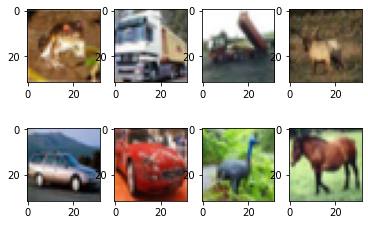

In [5]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [6]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [7]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [8]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [9]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...
class Mod_1(nn.Module):
    def __init__(self):
        super(Mod_1,self).__init__()
        
        self.conv1 = nn.Conv2d(3,  6, 5, padding = 1)
        
        self.conv2 = nn.Conv2d(6, 16, 5, padding = 1) 

        self.pool = nn.MaxPool2d(2, 2)
        
        self.linear1 = nn.Linear(576,128)
        
        self.linear2 = nn.Linear(128,64)
        
        self.linear3 = nn.Linear(64,10)
        
        self.dropout = nn.Dropout(p=0.3)
                
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.contiguous().view(-1,576)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device.type)

model = Mod_1().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)

epochs = 5000

size = 128

batchs = 50000//size

imgs_trans = (torch.from_numpy(imgs.transpose(0,3,1,2)).float()) / 255 * 2 - 1
labels_trans = torch.from_numpy(noisy_labels).long()

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    model.train()
    for i in range(batchs):
        data = imgs_trans[size*i:size*i+size]
        data = data.to(device)
        target = labels_trans[size*i:size*i+size]
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)        
    print("Epoch :%d, Loss: %.3f"%(epoch,train_loss/n_img))


cuda
Epoch :0, Loss: 2.300
Epoch :1, Loss: 2.301
Epoch :2, Loss: 2.300
Epoch :3, Loss: 2.300
Epoch :4, Loss: 2.300
Epoch :5, Loss: 2.300
Epoch :6, Loss: 2.300
Epoch :7, Loss: 2.300
Epoch :8, Loss: 2.299
Epoch :9, Loss: 2.299
Epoch :10, Loss: 2.299
Epoch :11, Loss: 2.299
Epoch :12, Loss: 2.299
Epoch :13, Loss: 2.299
Epoch :14, Loss: 2.299
Epoch :15, Loss: 2.299
Epoch :16, Loss: 2.299
Epoch :17, Loss: 2.299
Epoch :18, Loss: 2.299
Epoch :19, Loss: 2.299
Epoch :20, Loss: 2.299
Epoch :21, Loss: 2.299
Epoch :22, Loss: 2.299
Epoch :23, Loss: 2.299
Epoch :24, Loss: 2.298
Epoch :25, Loss: 2.299
Epoch :26, Loss: 2.298
Epoch :27, Loss: 2.298
Epoch :28, Loss: 2.298
Epoch :29, Loss: 2.298
Epoch :30, Loss: 2.298
Epoch :31, Loss: 2.298
Epoch :32, Loss: 2.298
Epoch :33, Loss: 2.298
Epoch :34, Loss: 2.298
Epoch :35, Loss: 2.298
Epoch :36, Loss: 2.298
Epoch :37, Loss: 2.298
Epoch :38, Loss: 2.298
Epoch :39, Loss: 2.298
Epoch :40, Loss: 2.298
Epoch :41, Loss: 2.298
Epoch :42, Loss: 2.298
Epoch :43, Loss:

Epoch :346, Loss: 2.253
Epoch :347, Loss: 2.253
Epoch :348, Loss: 2.253
Epoch :349, Loss: 2.253
Epoch :350, Loss: 2.254
Epoch :351, Loss: 2.253
Epoch :352, Loss: 2.253
Epoch :353, Loss: 2.251
Epoch :354, Loss: 2.254
Epoch :355, Loss: 2.252
Epoch :356, Loss: 2.252
Epoch :357, Loss: 2.252
Epoch :358, Loss: 2.252
Epoch :359, Loss: 2.252
Epoch :360, Loss: 2.253
Epoch :361, Loss: 2.252
Epoch :362, Loss: 2.251
Epoch :363, Loss: 2.252
Epoch :364, Loss: 2.251
Epoch :365, Loss: 2.251
Epoch :366, Loss: 2.252
Epoch :367, Loss: 2.252
Epoch :368, Loss: 2.251
Epoch :369, Loss: 2.251
Epoch :370, Loss: 2.252
Epoch :371, Loss: 2.251
Epoch :372, Loss: 2.251
Epoch :373, Loss: 2.251
Epoch :374, Loss: 2.251
Epoch :375, Loss: 2.252
Epoch :376, Loss: 2.251
Epoch :377, Loss: 2.251
Epoch :378, Loss: 2.250
Epoch :379, Loss: 2.252
Epoch :380, Loss: 2.250
Epoch :381, Loss: 2.250
Epoch :382, Loss: 2.251
Epoch :383, Loss: 2.251
Epoch :384, Loss: 2.250
Epoch :385, Loss: 2.250
Epoch :386, Loss: 2.248
Epoch :387, Loss

Epoch :688, Loss: 2.227
Epoch :689, Loss: 2.229
Epoch :690, Loss: 2.229
Epoch :691, Loss: 2.229
Epoch :692, Loss: 2.229
Epoch :693, Loss: 2.229
Epoch :694, Loss: 2.229
Epoch :695, Loss: 2.228
Epoch :696, Loss: 2.229
Epoch :697, Loss: 2.229
Epoch :698, Loss: 2.228
Epoch :699, Loss: 2.229
Epoch :700, Loss: 2.227
Epoch :701, Loss: 2.229
Epoch :702, Loss: 2.229
Epoch :703, Loss: 2.229
Epoch :704, Loss: 2.228
Epoch :705, Loss: 2.228
Epoch :706, Loss: 2.226
Epoch :707, Loss: 2.228
Epoch :708, Loss: 2.227
Epoch :709, Loss: 2.228
Epoch :710, Loss: 2.227
Epoch :711, Loss: 2.227
Epoch :712, Loss: 2.229
Epoch :713, Loss: 2.228
Epoch :714, Loss: 2.228
Epoch :715, Loss: 2.228
Epoch :716, Loss: 2.227
Epoch :717, Loss: 2.227
Epoch :718, Loss: 2.228
Epoch :719, Loss: 2.228
Epoch :720, Loss: 2.227
Epoch :721, Loss: 2.228
Epoch :722, Loss: 2.227
Epoch :723, Loss: 2.228
Epoch :724, Loss: 2.227
Epoch :725, Loss: 2.228
Epoch :726, Loss: 2.227
Epoch :727, Loss: 2.227
Epoch :728, Loss: 2.227
Epoch :729, Loss

Epoch :1029, Loss: 2.210
Epoch :1030, Loss: 2.210
Epoch :1031, Loss: 2.209
Epoch :1032, Loss: 2.209
Epoch :1033, Loss: 2.210
Epoch :1034, Loss: 2.210
Epoch :1035, Loss: 2.210
Epoch :1036, Loss: 2.210
Epoch :1037, Loss: 2.210
Epoch :1038, Loss: 2.210
Epoch :1039, Loss: 2.211
Epoch :1040, Loss: 2.210
Epoch :1041, Loss: 2.210
Epoch :1042, Loss: 2.209
Epoch :1043, Loss: 2.208
Epoch :1044, Loss: 2.209
Epoch :1045, Loss: 2.210
Epoch :1046, Loss: 2.210
Epoch :1047, Loss: 2.209
Epoch :1048, Loss: 2.207
Epoch :1049, Loss: 2.208
Epoch :1050, Loss: 2.208
Epoch :1051, Loss: 2.208
Epoch :1052, Loss: 2.209
Epoch :1053, Loss: 2.209
Epoch :1054, Loss: 2.208
Epoch :1055, Loss: 2.208
Epoch :1056, Loss: 2.209
Epoch :1057, Loss: 2.208
Epoch :1058, Loss: 2.208
Epoch :1059, Loss: 2.208
Epoch :1060, Loss: 2.209
Epoch :1061, Loss: 2.209
Epoch :1062, Loss: 2.207
Epoch :1063, Loss: 2.210
Epoch :1064, Loss: 2.208
Epoch :1065, Loss: 2.207
Epoch :1066, Loss: 2.209
Epoch :1067, Loss: 2.207
Epoch :1068, Loss: 2.207


Epoch :1357, Loss: 2.193
Epoch :1358, Loss: 2.192
Epoch :1359, Loss: 2.192
Epoch :1360, Loss: 2.192
Epoch :1361, Loss: 2.192
Epoch :1362, Loss: 2.192
Epoch :1363, Loss: 2.192
Epoch :1364, Loss: 2.193
Epoch :1365, Loss: 2.193
Epoch :1366, Loss: 2.192
Epoch :1367, Loss: 2.192
Epoch :1368, Loss: 2.192
Epoch :1369, Loss: 2.193
Epoch :1370, Loss: 2.192
Epoch :1371, Loss: 2.192
Epoch :1372, Loss: 2.190
Epoch :1373, Loss: 2.191
Epoch :1374, Loss: 2.192
Epoch :1375, Loss: 2.192
Epoch :1376, Loss: 2.192
Epoch :1377, Loss: 2.192
Epoch :1378, Loss: 2.191
Epoch :1379, Loss: 2.191
Epoch :1380, Loss: 2.191
Epoch :1381, Loss: 2.192
Epoch :1382, Loss: 2.191
Epoch :1383, Loss: 2.192
Epoch :1384, Loss: 2.191
Epoch :1385, Loss: 2.192
Epoch :1386, Loss: 2.191
Epoch :1387, Loss: 2.190
Epoch :1388, Loss: 2.192
Epoch :1389, Loss: 2.190
Epoch :1390, Loss: 2.193
Epoch :1391, Loss: 2.190
Epoch :1392, Loss: 2.191
Epoch :1393, Loss: 2.191
Epoch :1394, Loss: 2.190
Epoch :1395, Loss: 2.190
Epoch :1396, Loss: 2.192


Epoch :1685, Loss: 2.176
Epoch :1686, Loss: 2.175
Epoch :1687, Loss: 2.176
Epoch :1688, Loss: 2.175
Epoch :1689, Loss: 2.175
Epoch :1690, Loss: 2.174
Epoch :1691, Loss: 2.175
Epoch :1692, Loss: 2.174
Epoch :1693, Loss: 2.176
Epoch :1694, Loss: 2.176
Epoch :1695, Loss: 2.173
Epoch :1696, Loss: 2.176
Epoch :1697, Loss: 2.175
Epoch :1698, Loss: 2.175
Epoch :1699, Loss: 2.175
Epoch :1700, Loss: 2.175
Epoch :1701, Loss: 2.175
Epoch :1702, Loss: 2.176
Epoch :1703, Loss: 2.176
Epoch :1704, Loss: 2.174
Epoch :1705, Loss: 2.173
Epoch :1706, Loss: 2.173
Epoch :1707, Loss: 2.175
Epoch :1708, Loss: 2.173
Epoch :1709, Loss: 2.173
Epoch :1710, Loss: 2.173
Epoch :1711, Loss: 2.173
Epoch :1712, Loss: 2.173
Epoch :1713, Loss: 2.174
Epoch :1714, Loss: 2.174
Epoch :1715, Loss: 2.174
Epoch :1716, Loss: 2.173
Epoch :1717, Loss: 2.172
Epoch :1718, Loss: 2.172
Epoch :1719, Loss: 2.173
Epoch :1720, Loss: 2.174
Epoch :1721, Loss: 2.176
Epoch :1722, Loss: 2.174
Epoch :1723, Loss: 2.172
Epoch :1724, Loss: 2.172


Epoch :2013, Loss: 2.156
Epoch :2014, Loss: 2.157
Epoch :2015, Loss: 2.157
Epoch :2016, Loss: 2.157
Epoch :2017, Loss: 2.154
Epoch :2018, Loss: 2.158
Epoch :2019, Loss: 2.157
Epoch :2020, Loss: 2.157
Epoch :2021, Loss: 2.156
Epoch :2022, Loss: 2.158
Epoch :2023, Loss: 2.156
Epoch :2024, Loss: 2.157
Epoch :2025, Loss: 2.158
Epoch :2026, Loss: 2.157
Epoch :2027, Loss: 2.157
Epoch :2028, Loss: 2.156
Epoch :2029, Loss: 2.158
Epoch :2030, Loss: 2.156
Epoch :2031, Loss: 2.155
Epoch :2032, Loss: 2.157
Epoch :2033, Loss: 2.155
Epoch :2034, Loss: 2.158
Epoch :2035, Loss: 2.158
Epoch :2036, Loss: 2.156
Epoch :2037, Loss: 2.155
Epoch :2038, Loss: 2.155
Epoch :2039, Loss: 2.155
Epoch :2040, Loss: 2.157
Epoch :2041, Loss: 2.156
Epoch :2042, Loss: 2.156
Epoch :2043, Loss: 2.154
Epoch :2044, Loss: 2.157
Epoch :2045, Loss: 2.155
Epoch :2046, Loss: 2.156
Epoch :2047, Loss: 2.156
Epoch :2048, Loss: 2.154
Epoch :2049, Loss: 2.157
Epoch :2050, Loss: 2.155
Epoch :2051, Loss: 2.155
Epoch :2052, Loss: 2.155


Epoch :2341, Loss: 2.140
Epoch :2342, Loss: 2.135
Epoch :2343, Loss: 2.138
Epoch :2344, Loss: 2.138
Epoch :2345, Loss: 2.136
Epoch :2346, Loss: 2.137
Epoch :2347, Loss: 2.137
Epoch :2348, Loss: 2.139
Epoch :2349, Loss: 2.135
Epoch :2350, Loss: 2.136
Epoch :2351, Loss: 2.136
Epoch :2352, Loss: 2.138
Epoch :2353, Loss: 2.135
Epoch :2354, Loss: 2.135
Epoch :2355, Loss: 2.136
Epoch :2356, Loss: 2.138
Epoch :2357, Loss: 2.135
Epoch :2358, Loss: 2.135
Epoch :2359, Loss: 2.137
Epoch :2360, Loss: 2.136
Epoch :2361, Loss: 2.136
Epoch :2362, Loss: 2.136
Epoch :2363, Loss: 2.136
Epoch :2364, Loss: 2.136
Epoch :2365, Loss: 2.136
Epoch :2366, Loss: 2.137
Epoch :2367, Loss: 2.132
Epoch :2368, Loss: 2.138
Epoch :2369, Loss: 2.136
Epoch :2370, Loss: 2.133
Epoch :2371, Loss: 2.137
Epoch :2372, Loss: 2.133
Epoch :2373, Loss: 2.135
Epoch :2374, Loss: 2.135
Epoch :2375, Loss: 2.135
Epoch :2376, Loss: 2.135
Epoch :2377, Loss: 2.135
Epoch :2378, Loss: 2.134
Epoch :2379, Loss: 2.134
Epoch :2380, Loss: 2.136


Epoch :2669, Loss: 2.112
Epoch :2670, Loss: 2.111
Epoch :2671, Loss: 2.113
Epoch :2672, Loss: 2.113
Epoch :2673, Loss: 2.116
Epoch :2674, Loss: 2.113
Epoch :2675, Loss: 2.113
Epoch :2676, Loss: 2.114
Epoch :2677, Loss: 2.113
Epoch :2678, Loss: 2.112
Epoch :2679, Loss: 2.112
Epoch :2680, Loss: 2.112
Epoch :2681, Loss: 2.111
Epoch :2682, Loss: 2.114
Epoch :2683, Loss: 2.114
Epoch :2684, Loss: 2.113
Epoch :2685, Loss: 2.112
Epoch :2686, Loss: 2.114
Epoch :2687, Loss: 2.110
Epoch :2688, Loss: 2.111
Epoch :2689, Loss: 2.110
Epoch :2690, Loss: 2.112
Epoch :2691, Loss: 2.112
Epoch :2692, Loss: 2.108
Epoch :2693, Loss: 2.109
Epoch :2694, Loss: 2.112
Epoch :2695, Loss: 2.112
Epoch :2696, Loss: 2.111
Epoch :2697, Loss: 2.113
Epoch :2698, Loss: 2.113
Epoch :2699, Loss: 2.111
Epoch :2700, Loss: 2.112
Epoch :2701, Loss: 2.112
Epoch :2702, Loss: 2.112
Epoch :2703, Loss: 2.111
Epoch :2704, Loss: 2.111
Epoch :2705, Loss: 2.112
Epoch :2706, Loss: 2.112
Epoch :2707, Loss: 2.110
Epoch :2708, Loss: 2.108


Epoch :2997, Loss: 2.085
Epoch :2998, Loss: 2.086
Epoch :2999, Loss: 2.083
Epoch :3000, Loss: 2.086
Epoch :3001, Loss: 2.084
Epoch :3002, Loss: 2.085
Epoch :3003, Loss: 2.083
Epoch :3004, Loss: 2.089
Epoch :3005, Loss: 2.084
Epoch :3006, Loss: 2.088
Epoch :3007, Loss: 2.090
Epoch :3008, Loss: 2.085
Epoch :3009, Loss: 2.086
Epoch :3010, Loss: 2.082
Epoch :3011, Loss: 2.085
Epoch :3012, Loss: 2.088
Epoch :3013, Loss: 2.085
Epoch :3014, Loss: 2.084
Epoch :3015, Loss: 2.084
Epoch :3016, Loss: 2.084
Epoch :3017, Loss: 2.084
Epoch :3018, Loss: 2.082
Epoch :3019, Loss: 2.084
Epoch :3020, Loss: 2.084
Epoch :3021, Loss: 2.086
Epoch :3022, Loss: 2.083
Epoch :3023, Loss: 2.079
Epoch :3024, Loss: 2.083
Epoch :3025, Loss: 2.084
Epoch :3026, Loss: 2.082
Epoch :3027, Loss: 2.082
Epoch :3028, Loss: 2.084
Epoch :3029, Loss: 2.082
Epoch :3030, Loss: 2.084
Epoch :3031, Loss: 2.080
Epoch :3032, Loss: 2.084
Epoch :3033, Loss: 2.085
Epoch :3034, Loss: 2.084
Epoch :3035, Loss: 2.085
Epoch :3036, Loss: 2.084


Epoch :3325, Loss: 2.056
Epoch :3326, Loss: 2.058
Epoch :3327, Loss: 2.055
Epoch :3328, Loss: 2.058
Epoch :3329, Loss: 2.056
Epoch :3330, Loss: 2.058
Epoch :3331, Loss: 2.057
Epoch :3332, Loss: 2.056
Epoch :3333, Loss: 2.056
Epoch :3334, Loss: 2.059
Epoch :3335, Loss: 2.058
Epoch :3336, Loss: 2.056
Epoch :3337, Loss: 2.057
Epoch :3338, Loss: 2.056
Epoch :3339, Loss: 2.053
Epoch :3340, Loss: 2.056
Epoch :3341, Loss: 2.057
Epoch :3342, Loss: 2.054
Epoch :3343, Loss: 2.056
Epoch :3344, Loss: 2.052
Epoch :3345, Loss: 2.054
Epoch :3346, Loss: 2.056
Epoch :3347, Loss: 2.052
Epoch :3348, Loss: 2.051
Epoch :3349, Loss: 2.053
Epoch :3350, Loss: 2.052
Epoch :3351, Loss: 2.051
Epoch :3352, Loss: 2.053
Epoch :3353, Loss: 2.057
Epoch :3354, Loss: 2.053
Epoch :3355, Loss: 2.056
Epoch :3356, Loss: 2.054
Epoch :3357, Loss: 2.052
Epoch :3358, Loss: 2.055
Epoch :3359, Loss: 2.052
Epoch :3360, Loss: 2.054
Epoch :3361, Loss: 2.057
Epoch :3362, Loss: 2.055
Epoch :3363, Loss: 2.051
Epoch :3364, Loss: 2.056


Epoch :3653, Loss: 2.028
Epoch :3654, Loss: 2.027
Epoch :3655, Loss: 2.035
Epoch :3656, Loss: 2.026
Epoch :3657, Loss: 2.033
Epoch :3658, Loss: 2.032
Epoch :3659, Loss: 2.029
Epoch :3660, Loss: 2.031
Epoch :3661, Loss: 2.033
Epoch :3662, Loss: 2.028
Epoch :3663, Loss: 2.028
Epoch :3664, Loss: 2.030
Epoch :3665, Loss: 2.026
Epoch :3666, Loss: 2.030
Epoch :3667, Loss: 2.027
Epoch :3668, Loss: 2.028
Epoch :3669, Loss: 2.031
Epoch :3670, Loss: 2.028
Epoch :3671, Loss: 2.031
Epoch :3672, Loss: 2.028
Epoch :3673, Loss: 2.028
Epoch :3674, Loss: 2.025
Epoch :3675, Loss: 2.028
Epoch :3676, Loss: 2.030
Epoch :3677, Loss: 2.028
Epoch :3678, Loss: 2.027
Epoch :3679, Loss: 2.025
Epoch :3680, Loss: 2.026
Epoch :3681, Loss: 2.029
Epoch :3682, Loss: 2.029
Epoch :3683, Loss: 2.026
Epoch :3684, Loss: 2.024
Epoch :3685, Loss: 2.027
Epoch :3686, Loss: 2.025
Epoch :3687, Loss: 2.029
Epoch :3688, Loss: 2.025
Epoch :3689, Loss: 2.025
Epoch :3690, Loss: 2.024
Epoch :3691, Loss: 2.025
Epoch :3692, Loss: 2.027


Epoch :3981, Loss: 2.006
Epoch :3982, Loss: 2.009
Epoch :3983, Loss: 2.007
Epoch :3984, Loss: 2.005
Epoch :3985, Loss: 2.005
Epoch :3986, Loss: 2.006
Epoch :3987, Loss: 2.004
Epoch :3988, Loss: 2.002
Epoch :3989, Loss: 2.003
Epoch :3990, Loss: 2.005
Epoch :3991, Loss: 2.003
Epoch :3992, Loss: 2.011
Epoch :3993, Loss: 2.004
Epoch :3994, Loss: 2.004
Epoch :3995, Loss: 2.006
Epoch :3996, Loss: 2.009
Epoch :3997, Loss: 2.005
Epoch :3998, Loss: 2.007
Epoch :3999, Loss: 2.003
Epoch :4000, Loss: 2.006
Epoch :4001, Loss: 2.007
Epoch :4002, Loss: 2.007
Epoch :4003, Loss: 2.008
Epoch :4004, Loss: 2.006
Epoch :4005, Loss: 2.001
Epoch :4006, Loss: 2.005
Epoch :4007, Loss: 2.004
Epoch :4008, Loss: 2.008
Epoch :4009, Loss: 2.008
Epoch :4010, Loss: 2.007
Epoch :4011, Loss: 2.004
Epoch :4012, Loss: 2.001
Epoch :4013, Loss: 2.008
Epoch :4014, Loss: 2.006
Epoch :4015, Loss: 2.006
Epoch :4016, Loss: 2.004
Epoch :4017, Loss: 2.006
Epoch :4018, Loss: 2.004
Epoch :4019, Loss: 2.006
Epoch :4020, Loss: 2.002


Epoch :4309, Loss: 1.990
Epoch :4310, Loss: 1.988
Epoch :4311, Loss: 1.990
Epoch :4312, Loss: 1.992
Epoch :4313, Loss: 1.987
Epoch :4314, Loss: 1.990
Epoch :4315, Loss: 1.986
Epoch :4316, Loss: 1.989
Epoch :4317, Loss: 1.985
Epoch :4318, Loss: 1.993
Epoch :4319, Loss: 1.985
Epoch :4320, Loss: 1.990
Epoch :4321, Loss: 1.991
Epoch :4322, Loss: 1.986
Epoch :4323, Loss: 1.990
Epoch :4324, Loss: 1.987
Epoch :4325, Loss: 1.984
Epoch :4326, Loss: 1.986
Epoch :4327, Loss: 1.987
Epoch :4328, Loss: 1.987
Epoch :4329, Loss: 1.990
Epoch :4330, Loss: 1.991
Epoch :4331, Loss: 1.984
Epoch :4332, Loss: 1.989
Epoch :4333, Loss: 1.989
Epoch :4334, Loss: 1.989
Epoch :4335, Loss: 1.984
Epoch :4336, Loss: 1.985
Epoch :4337, Loss: 1.983
Epoch :4338, Loss: 1.988
Epoch :4339, Loss: 1.985
Epoch :4340, Loss: 1.986
Epoch :4341, Loss: 1.985
Epoch :4342, Loss: 1.984
Epoch :4343, Loss: 1.985
Epoch :4344, Loss: 1.986
Epoch :4345, Loss: 1.989
Epoch :4346, Loss: 1.987
Epoch :4347, Loss: 1.986
Epoch :4348, Loss: 1.989


Epoch :4637, Loss: 1.973
Epoch :4638, Loss: 1.970
Epoch :4639, Loss: 1.974
Epoch :4640, Loss: 1.977
Epoch :4641, Loss: 1.974
Epoch :4642, Loss: 1.973
Epoch :4643, Loss: 1.971
Epoch :4644, Loss: 1.974
Epoch :4645, Loss: 1.975
Epoch :4646, Loss: 1.974
Epoch :4647, Loss: 1.976
Epoch :4648, Loss: 1.972
Epoch :4649, Loss: 1.971
Epoch :4650, Loss: 1.971
Epoch :4651, Loss: 1.972
Epoch :4652, Loss: 1.973
Epoch :4653, Loss: 1.976
Epoch :4654, Loss: 1.978
Epoch :4655, Loss: 1.974
Epoch :4656, Loss: 1.974
Epoch :4657, Loss: 1.972
Epoch :4658, Loss: 1.971
Epoch :4659, Loss: 1.971
Epoch :4660, Loss: 1.971
Epoch :4661, Loss: 1.969
Epoch :4662, Loss: 1.968
Epoch :4663, Loss: 1.978
Epoch :4664, Loss: 1.968
Epoch :4665, Loss: 1.972
Epoch :4666, Loss: 1.968
Epoch :4667, Loss: 1.976
Epoch :4668, Loss: 1.974
Epoch :4669, Loss: 1.968
Epoch :4670, Loss: 1.975
Epoch :4671, Loss: 1.975
Epoch :4672, Loss: 1.970
Epoch :4673, Loss: 1.972
Epoch :4674, Loss: 1.973
Epoch :4675, Loss: 1.969
Epoch :4676, Loss: 1.970


Epoch :4965, Loss: 1.963
Epoch :4966, Loss: 1.958
Epoch :4967, Loss: 1.962
Epoch :4968, Loss: 1.962
Epoch :4969, Loss: 1.961
Epoch :4970, Loss: 1.964
Epoch :4971, Loss: 1.958
Epoch :4972, Loss: 1.962
Epoch :4973, Loss: 1.962
Epoch :4974, Loss: 1.957
Epoch :4975, Loss: 1.959
Epoch :4976, Loss: 1.960
Epoch :4977, Loss: 1.962
Epoch :4978, Loss: 1.962
Epoch :4979, Loss: 1.958
Epoch :4980, Loss: 1.960
Epoch :4981, Loss: 1.965
Epoch :4982, Loss: 1.961
Epoch :4983, Loss: 1.957
Epoch :4984, Loss: 1.965
Epoch :4985, Loss: 1.959
Epoch :4986, Loss: 1.958
Epoch :4987, Loss: 1.963
Epoch :4988, Loss: 1.956
Epoch :4989, Loss: 1.960
Epoch :4990, Loss: 1.960
Epoch :4991, Loss: 1.962
Epoch :4992, Loss: 1.957
Epoch :4993, Loss: 1.961
Epoch :4994, Loss: 1.959
Epoch :4995, Loss: 1.963
Epoch :4996, Loss: 1.958
Epoch :4997, Loss: 1.959
Epoch :4998, Loss: 1.958
Epoch :4999, Loss: 1.956


In [9]:
path = '../output/model_1.pth'
torch.save(model.state_dict(),path)

In [10]:
test_mod = Mod_1()
test_mod.load_state_dict(torch.load(path))

<All keys matched successfully>

In [11]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

    predict_labels = torch.Tensor([])
    imgs_trans = (torch.from_numpy(image.transpose(0,3,1,2)).float()) / 255 * 2 - 1

    size = 16
    batchs = image.shape[0] //size
    
    with torch.no_grad():
        for i in range(batchs):
            data = imgs_trans[size*i:size*i+size]
            output = test_mod(data)
            _,y_hat = torch.max(output.data,dim=1)
            predict_labels = torch.cat((predict_labels,y_hat), 0)    
    return predict_labels.numpy().astype(int)

### 2.3. Model II

In [48]:
model2_clean = Mod_1().to(device)

optimizer = optim.SGD(model2_clean.parameters(), lr=0.001)

epochs = 20000

size = 128

batchs = 10000//size

imgs_trans = (torch.from_numpy(imgs[:10000].transpose(0,3,1,2)).float()) / 255 * 2 - 1
labels_trans = torch.from_numpy(clean_labels).long()

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    model.train()
    for i in range(batchs):
        data = imgs_trans[size*i:size*i+size]
        data = data.to(device)
        target = labels_trans[size*i:size*i+size]
        target = target.to(device)
        optimizer.zero_grad()
        output = model2_clean(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)    
    print("Epoch :%d, Loss: %.3f"%(epoch,train_loss/10000))
    

Epoch :0, Loss: 2.300
Epoch :1, Loss: 2.300
Epoch :2, Loss: 2.300
Epoch :3, Loss: 2.300
Epoch :4, Loss: 2.300
Epoch :5, Loss: 2.300
Epoch :6, Loss: 2.300
Epoch :7, Loss: 2.300
Epoch :8, Loss: 2.300
Epoch :9, Loss: 2.300
Epoch :10, Loss: 2.299
Epoch :11, Loss: 2.299
Epoch :12, Loss: 2.299
Epoch :13, Loss: 2.299
Epoch :14, Loss: 2.299
Epoch :15, Loss: 2.299
Epoch :16, Loss: 2.299
Epoch :17, Loss: 2.299
Epoch :18, Loss: 2.299
Epoch :19, Loss: 2.299
Epoch :20, Loss: 2.299
Epoch :21, Loss: 2.299
Epoch :22, Loss: 2.299
Epoch :23, Loss: 2.299
Epoch :24, Loss: 2.299
Epoch :25, Loss: 2.299
Epoch :26, Loss: 2.299
Epoch :27, Loss: 2.299
Epoch :28, Loss: 2.299
Epoch :29, Loss: 2.298
Epoch :30, Loss: 2.298
Epoch :31, Loss: 2.298
Epoch :32, Loss: 2.298
Epoch :33, Loss: 2.298
Epoch :34, Loss: 2.298
Epoch :35, Loss: 2.298
Epoch :36, Loss: 2.298
Epoch :37, Loss: 2.298
Epoch :38, Loss: 2.298
Epoch :39, Loss: 2.298
Epoch :40, Loss: 2.298
Epoch :41, Loss: 2.298
Epoch :42, Loss: 2.298
Epoch :43, Loss: 2.29

Epoch :346, Loss: 1.878
Epoch :347, Loss: 1.875
Epoch :348, Loss: 1.875
Epoch :349, Loss: 1.871
Epoch :350, Loss: 1.871
Epoch :351, Loss: 1.870
Epoch :352, Loss: 1.874
Epoch :353, Loss: 1.868
Epoch :354, Loss: 1.865
Epoch :355, Loss: 1.865
Epoch :356, Loss: 1.868
Epoch :357, Loss: 1.859
Epoch :358, Loss: 1.869
Epoch :359, Loss: 1.864
Epoch :360, Loss: 1.859
Epoch :361, Loss: 1.861
Epoch :362, Loss: 1.855
Epoch :363, Loss: 1.859
Epoch :364, Loss: 1.856
Epoch :365, Loss: 1.848
Epoch :366, Loss: 1.852
Epoch :367, Loss: 1.850
Epoch :368, Loss: 1.853
Epoch :369, Loss: 1.843
Epoch :370, Loss: 1.849
Epoch :371, Loss: 1.851
Epoch :372, Loss: 1.839
Epoch :373, Loss: 1.843
Epoch :374, Loss: 1.849
Epoch :375, Loss: 1.843
Epoch :376, Loss: 1.838
Epoch :377, Loss: 1.839
Epoch :378, Loss: 1.844
Epoch :379, Loss: 1.842
Epoch :380, Loss: 1.836
Epoch :381, Loss: 1.838
Epoch :382, Loss: 1.836
Epoch :383, Loss: 1.835
Epoch :384, Loss: 1.838
Epoch :385, Loss: 1.833
Epoch :386, Loss: 1.840
Epoch :387, Loss

Epoch :688, Loss: 1.611
Epoch :689, Loss: 1.624
Epoch :690, Loss: 1.616
Epoch :691, Loss: 1.622
Epoch :692, Loss: 1.622
Epoch :693, Loss: 1.624
Epoch :694, Loss: 1.619
Epoch :695, Loss: 1.623
Epoch :696, Loss: 1.622
Epoch :697, Loss: 1.619
Epoch :698, Loss: 1.613
Epoch :699, Loss: 1.621
Epoch :700, Loss: 1.614
Epoch :701, Loss: 1.610
Epoch :702, Loss: 1.614
Epoch :703, Loss: 1.627
Epoch :704, Loss: 1.612
Epoch :705, Loss: 1.615
Epoch :706, Loss: 1.619
Epoch :707, Loss: 1.618
Epoch :708, Loss: 1.618
Epoch :709, Loss: 1.616
Epoch :710, Loss: 1.607
Epoch :711, Loss: 1.613
Epoch :712, Loss: 1.617
Epoch :713, Loss: 1.611
Epoch :714, Loss: 1.606
Epoch :715, Loss: 1.613
Epoch :716, Loss: 1.606
Epoch :717, Loss: 1.607
Epoch :718, Loss: 1.600
Epoch :719, Loss: 1.613
Epoch :720, Loss: 1.604
Epoch :721, Loss: 1.605
Epoch :722, Loss: 1.604
Epoch :723, Loss: 1.606
Epoch :724, Loss: 1.600
Epoch :725, Loss: 1.598
Epoch :726, Loss: 1.607
Epoch :727, Loss: 1.606
Epoch :728, Loss: 1.600
Epoch :729, Loss

Epoch :1029, Loss: 1.480
Epoch :1030, Loss: 1.476
Epoch :1031, Loss: 1.470
Epoch :1032, Loss: 1.473
Epoch :1033, Loss: 1.475
Epoch :1034, Loss: 1.469
Epoch :1035, Loss: 1.464
Epoch :1036, Loss: 1.466
Epoch :1037, Loss: 1.468
Epoch :1038, Loss: 1.473
Epoch :1039, Loss: 1.471
Epoch :1040, Loss: 1.467
Epoch :1041, Loss: 1.462
Epoch :1042, Loss: 1.468
Epoch :1043, Loss: 1.460
Epoch :1044, Loss: 1.470
Epoch :1045, Loss: 1.464
Epoch :1046, Loss: 1.465
Epoch :1047, Loss: 1.466
Epoch :1048, Loss: 1.469
Epoch :1049, Loss: 1.461
Epoch :1050, Loss: 1.465
Epoch :1051, Loss: 1.466
Epoch :1052, Loss: 1.466
Epoch :1053, Loss: 1.469
Epoch :1054, Loss: 1.468
Epoch :1055, Loss: 1.465
Epoch :1056, Loss: 1.465
Epoch :1057, Loss: 1.460
Epoch :1058, Loss: 1.466
Epoch :1059, Loss: 1.452
Epoch :1060, Loss: 1.460
Epoch :1061, Loss: 1.453
Epoch :1062, Loss: 1.452
Epoch :1063, Loss: 1.459
Epoch :1064, Loss: 1.462
Epoch :1065, Loss: 1.455
Epoch :1066, Loss: 1.455
Epoch :1067, Loss: 1.447
Epoch :1068, Loss: 1.456


Epoch :1357, Loss: 1.342
Epoch :1358, Loss: 1.337
Epoch :1359, Loss: 1.337
Epoch :1360, Loss: 1.346
Epoch :1361, Loss: 1.347
Epoch :1362, Loss: 1.338
Epoch :1363, Loss: 1.345
Epoch :1364, Loss: 1.337
Epoch :1365, Loss: 1.339
Epoch :1366, Loss: 1.340
Epoch :1367, Loss: 1.345
Epoch :1368, Loss: 1.330
Epoch :1369, Loss: 1.335
Epoch :1370, Loss: 1.341
Epoch :1371, Loss: 1.338
Epoch :1372, Loss: 1.326
Epoch :1373, Loss: 1.331
Epoch :1374, Loss: 1.334
Epoch :1375, Loss: 1.326
Epoch :1376, Loss: 1.330
Epoch :1377, Loss: 1.330
Epoch :1378, Loss: 1.328
Epoch :1379, Loss: 1.326
Epoch :1380, Loss: 1.333
Epoch :1381, Loss: 1.330
Epoch :1382, Loss: 1.332
Epoch :1383, Loss: 1.329
Epoch :1384, Loss: 1.318
Epoch :1385, Loss: 1.327
Epoch :1386, Loss: 1.330
Epoch :1387, Loss: 1.323
Epoch :1388, Loss: 1.331
Epoch :1389, Loss: 1.328
Epoch :1390, Loss: 1.318
Epoch :1391, Loss: 1.333
Epoch :1392, Loss: 1.335
Epoch :1393, Loss: 1.325
Epoch :1394, Loss: 1.330
Epoch :1395, Loss: 1.321
Epoch :1396, Loss: 1.322


Epoch :1685, Loss: 1.229
Epoch :1686, Loss: 1.224
Epoch :1687, Loss: 1.233
Epoch :1688, Loss: 1.224
Epoch :1689, Loss: 1.234
Epoch :1690, Loss: 1.223
Epoch :1691, Loss: 1.226
Epoch :1692, Loss: 1.220
Epoch :1693, Loss: 1.227
Epoch :1694, Loss: 1.228
Epoch :1695, Loss: 1.220
Epoch :1696, Loss: 1.218
Epoch :1697, Loss: 1.223
Epoch :1698, Loss: 1.211
Epoch :1699, Loss: 1.223
Epoch :1700, Loss: 1.216
Epoch :1701, Loss: 1.231
Epoch :1702, Loss: 1.224
Epoch :1703, Loss: 1.224
Epoch :1704, Loss: 1.231
Epoch :1705, Loss: 1.227
Epoch :1706, Loss: 1.226
Epoch :1707, Loss: 1.229
Epoch :1708, Loss: 1.231
Epoch :1709, Loss: 1.220
Epoch :1710, Loss: 1.226
Epoch :1711, Loss: 1.221
Epoch :1712, Loss: 1.221
Epoch :1713, Loss: 1.221
Epoch :1714, Loss: 1.225
Epoch :1715, Loss: 1.215
Epoch :1716, Loss: 1.220
Epoch :1717, Loss: 1.227
Epoch :1718, Loss: 1.217
Epoch :1719, Loss: 1.230
Epoch :1720, Loss: 1.221
Epoch :1721, Loss: 1.216
Epoch :1722, Loss: 1.223
Epoch :1723, Loss: 1.222
Epoch :1724, Loss: 1.211


Epoch :2013, Loss: 1.145
Epoch :2014, Loss: 1.135
Epoch :2015, Loss: 1.135
Epoch :2016, Loss: 1.144
Epoch :2017, Loss: 1.135
Epoch :2018, Loss: 1.145
Epoch :2019, Loss: 1.150
Epoch :2020, Loss: 1.144
Epoch :2021, Loss: 1.142
Epoch :2022, Loss: 1.130
Epoch :2023, Loss: 1.138
Epoch :2024, Loss: 1.144
Epoch :2025, Loss: 1.137
Epoch :2026, Loss: 1.133
Epoch :2027, Loss: 1.131
Epoch :2028, Loss: 1.132
Epoch :2029, Loss: 1.126
Epoch :2030, Loss: 1.134
Epoch :2031, Loss: 1.128
Epoch :2032, Loss: 1.135
Epoch :2033, Loss: 1.128
Epoch :2034, Loss: 1.135
Epoch :2035, Loss: 1.135
Epoch :2036, Loss: 1.130
Epoch :2037, Loss: 1.127
Epoch :2038, Loss: 1.118
Epoch :2039, Loss: 1.131
Epoch :2040, Loss: 1.127
Epoch :2041, Loss: 1.125
Epoch :2042, Loss: 1.131
Epoch :2043, Loss: 1.147
Epoch :2044, Loss: 1.130
Epoch :2045, Loss: 1.127
Epoch :2046, Loss: 1.137
Epoch :2047, Loss: 1.123
Epoch :2048, Loss: 1.133
Epoch :2049, Loss: 1.128
Epoch :2050, Loss: 1.127
Epoch :2051, Loss: 1.125
Epoch :2052, Loss: 1.128


Epoch :2341, Loss: 1.046
Epoch :2342, Loss: 1.058
Epoch :2343, Loss: 1.050
Epoch :2344, Loss: 1.052
Epoch :2345, Loss: 1.053
Epoch :2346, Loss: 1.063
Epoch :2347, Loss: 1.065
Epoch :2348, Loss: 1.057
Epoch :2349, Loss: 1.060
Epoch :2350, Loss: 1.059
Epoch :2351, Loss: 1.062
Epoch :2352, Loss: 1.052
Epoch :2353, Loss: 1.053
Epoch :2354, Loss: 1.059
Epoch :2355, Loss: 1.058
Epoch :2356, Loss: 1.066
Epoch :2357, Loss: 1.059
Epoch :2358, Loss: 1.056
Epoch :2359, Loss: 1.049
Epoch :2360, Loss: 1.045
Epoch :2361, Loss: 1.048
Epoch :2362, Loss: 1.046
Epoch :2363, Loss: 1.045
Epoch :2364, Loss: 1.059
Epoch :2365, Loss: 1.049
Epoch :2366, Loss: 1.051
Epoch :2367, Loss: 1.044
Epoch :2368, Loss: 1.053
Epoch :2369, Loss: 1.053
Epoch :2370, Loss: 1.048
Epoch :2371, Loss: 1.050
Epoch :2372, Loss: 1.063
Epoch :2373, Loss: 1.051
Epoch :2374, Loss: 1.053
Epoch :2375, Loss: 1.043
Epoch :2376, Loss: 1.040
Epoch :2377, Loss: 1.049
Epoch :2378, Loss: 1.048
Epoch :2379, Loss: 1.045
Epoch :2380, Loss: 1.054


Epoch :2669, Loss: 0.977
Epoch :2670, Loss: 0.974
Epoch :2671, Loss: 0.981
Epoch :2672, Loss: 0.978
Epoch :2673, Loss: 0.971
Epoch :2674, Loss: 0.976
Epoch :2675, Loss: 0.978
Epoch :2676, Loss: 0.968
Epoch :2677, Loss: 0.971
Epoch :2678, Loss: 0.974
Epoch :2679, Loss: 0.991
Epoch :2680, Loss: 0.984
Epoch :2681, Loss: 0.986
Epoch :2682, Loss: 0.982
Epoch :2683, Loss: 0.979
Epoch :2684, Loss: 0.980
Epoch :2685, Loss: 0.979
Epoch :2686, Loss: 0.978
Epoch :2687, Loss: 0.981
Epoch :2688, Loss: 0.981
Epoch :2689, Loss: 0.978
Epoch :2690, Loss: 0.972
Epoch :2691, Loss: 0.978
Epoch :2692, Loss: 0.971
Epoch :2693, Loss: 0.974
Epoch :2694, Loss: 0.971
Epoch :2695, Loss: 0.971
Epoch :2696, Loss: 0.988
Epoch :2697, Loss: 0.981
Epoch :2698, Loss: 0.973
Epoch :2699, Loss: 0.974
Epoch :2700, Loss: 0.970
Epoch :2701, Loss: 0.977
Epoch :2702, Loss: 0.981
Epoch :2703, Loss: 0.962
Epoch :2704, Loss: 0.977
Epoch :2705, Loss: 0.972
Epoch :2706, Loss: 0.976
Epoch :2707, Loss: 0.974
Epoch :2708, Loss: 0.963


Epoch :2997, Loss: 0.909
Epoch :2998, Loss: 0.911
Epoch :2999, Loss: 0.914
Epoch :3000, Loss: 0.908
Epoch :3001, Loss: 0.915
Epoch :3002, Loss: 0.901
Epoch :3003, Loss: 0.904
Epoch :3004, Loss: 0.914
Epoch :3005, Loss: 0.905
Epoch :3006, Loss: 0.895
Epoch :3007, Loss: 0.913
Epoch :3008, Loss: 0.912
Epoch :3009, Loss: 0.902
Epoch :3010, Loss: 0.890
Epoch :3011, Loss: 0.911
Epoch :3012, Loss: 0.896
Epoch :3013, Loss: 0.910
Epoch :3014, Loss: 0.912
Epoch :3015, Loss: 0.909
Epoch :3016, Loss: 0.897
Epoch :3017, Loss: 0.902
Epoch :3018, Loss: 0.897
Epoch :3019, Loss: 0.902
Epoch :3020, Loss: 0.917
Epoch :3021, Loss: 0.905
Epoch :3022, Loss: 0.906
Epoch :3023, Loss: 0.902
Epoch :3024, Loss: 0.913
Epoch :3025, Loss: 0.899
Epoch :3026, Loss: 0.896
Epoch :3027, Loss: 0.908
Epoch :3028, Loss: 0.895
Epoch :3029, Loss: 0.910
Epoch :3030, Loss: 0.909
Epoch :3031, Loss: 0.895
Epoch :3032, Loss: 0.902
Epoch :3033, Loss: 0.898
Epoch :3034, Loss: 0.911
Epoch :3035, Loss: 0.889
Epoch :3036, Loss: 0.905


Epoch :3325, Loss: 0.843
Epoch :3326, Loss: 0.860
Epoch :3327, Loss: 0.845
Epoch :3328, Loss: 0.832
Epoch :3329, Loss: 0.848
Epoch :3330, Loss: 0.839
Epoch :3331, Loss: 0.834
Epoch :3332, Loss: 0.841
Epoch :3333, Loss: 0.831
Epoch :3334, Loss: 0.841
Epoch :3335, Loss: 0.848
Epoch :3336, Loss: 0.845
Epoch :3337, Loss: 0.838
Epoch :3338, Loss: 0.843
Epoch :3339, Loss: 0.843
Epoch :3340, Loss: 0.840
Epoch :3341, Loss: 0.834
Epoch :3342, Loss: 0.830
Epoch :3343, Loss: 0.836
Epoch :3344, Loss: 0.824
Epoch :3345, Loss: 0.844
Epoch :3346, Loss: 0.846
Epoch :3347, Loss: 0.843
Epoch :3348, Loss: 0.839
Epoch :3349, Loss: 0.835
Epoch :3350, Loss: 0.848
Epoch :3351, Loss: 0.829
Epoch :3352, Loss: 0.834
Epoch :3353, Loss: 0.842
Epoch :3354, Loss: 0.841
Epoch :3355, Loss: 0.834
Epoch :3356, Loss: 0.841
Epoch :3357, Loss: 0.835
Epoch :3358, Loss: 0.834
Epoch :3359, Loss: 0.841
Epoch :3360, Loss: 0.830
Epoch :3361, Loss: 0.835
Epoch :3362, Loss: 0.843
Epoch :3363, Loss: 0.829
Epoch :3364, Loss: 0.840


Epoch :3653, Loss: 0.788
Epoch :3654, Loss: 0.783
Epoch :3655, Loss: 0.792
Epoch :3656, Loss: 0.782
Epoch :3657, Loss: 0.782
Epoch :3658, Loss: 0.772
Epoch :3659, Loss: 0.771
Epoch :3660, Loss: 0.769
Epoch :3661, Loss: 0.790
Epoch :3662, Loss: 0.781
Epoch :3663, Loss: 0.780
Epoch :3664, Loss: 0.791
Epoch :3665, Loss: 0.776
Epoch :3666, Loss: 0.769
Epoch :3667, Loss: 0.780
Epoch :3668, Loss: 0.779
Epoch :3669, Loss: 0.772
Epoch :3670, Loss: 0.775
Epoch :3671, Loss: 0.777
Epoch :3672, Loss: 0.776
Epoch :3673, Loss: 0.774
Epoch :3674, Loss: 0.788
Epoch :3675, Loss: 0.772
Epoch :3676, Loss: 0.786
Epoch :3677, Loss: 0.781
Epoch :3678, Loss: 0.774
Epoch :3679, Loss: 0.768
Epoch :3680, Loss: 0.771
Epoch :3681, Loss: 0.784
Epoch :3682, Loss: 0.770
Epoch :3683, Loss: 0.786
Epoch :3684, Loss: 0.780
Epoch :3685, Loss: 0.772
Epoch :3686, Loss: 0.772
Epoch :3687, Loss: 0.764
Epoch :3688, Loss: 0.786
Epoch :3689, Loss: 0.769
Epoch :3690, Loss: 0.768
Epoch :3691, Loss: 0.764
Epoch :3692, Loss: 0.780


Epoch :3981, Loss: 0.727
Epoch :3982, Loss: 0.725
Epoch :3983, Loss: 0.718
Epoch :3984, Loss: 0.727
Epoch :3985, Loss: 0.725
Epoch :3986, Loss: 0.725
Epoch :3987, Loss: 0.724
Epoch :3988, Loss: 0.734
Epoch :3989, Loss: 0.729
Epoch :3990, Loss: 0.722
Epoch :3991, Loss: 0.726
Epoch :3992, Loss: 0.710
Epoch :3993, Loss: 0.728
Epoch :3994, Loss: 0.730
Epoch :3995, Loss: 0.720
Epoch :3996, Loss: 0.731
Epoch :3997, Loss: 0.735
Epoch :3998, Loss: 0.718
Epoch :3999, Loss: 0.713
Epoch :4000, Loss: 0.716
Epoch :4001, Loss: 0.712
Epoch :4002, Loss: 0.720
Epoch :4003, Loss: 0.725
Epoch :4004, Loss: 0.722
Epoch :4005, Loss: 0.736
Epoch :4006, Loss: 0.729
Epoch :4007, Loss: 0.721
Epoch :4008, Loss: 0.724
Epoch :4009, Loss: 0.737
Epoch :4010, Loss: 0.713
Epoch :4011, Loss: 0.716
Epoch :4012, Loss: 0.716
Epoch :4013, Loss: 0.726
Epoch :4014, Loss: 0.735
Epoch :4015, Loss: 0.725
Epoch :4016, Loss: 0.722
Epoch :4017, Loss: 0.721
Epoch :4018, Loss: 0.713
Epoch :4019, Loss: 0.728
Epoch :4020, Loss: 0.720


Epoch :4309, Loss: 0.688
Epoch :4310, Loss: 0.676
Epoch :4311, Loss: 0.674
Epoch :4312, Loss: 0.674
Epoch :4313, Loss: 0.675
Epoch :4314, Loss: 0.683
Epoch :4315, Loss: 0.695
Epoch :4316, Loss: 0.687
Epoch :4317, Loss: 0.676
Epoch :4318, Loss: 0.689
Epoch :4319, Loss: 0.680
Epoch :4320, Loss: 0.662
Epoch :4321, Loss: 0.673
Epoch :4322, Loss: 0.679
Epoch :4323, Loss: 0.666
Epoch :4324, Loss: 0.676
Epoch :4325, Loss: 0.668
Epoch :4326, Loss: 0.675
Epoch :4327, Loss: 0.677
Epoch :4328, Loss: 0.667
Epoch :4329, Loss: 0.676
Epoch :4330, Loss: 0.683
Epoch :4331, Loss: 0.665
Epoch :4332, Loss: 0.681
Epoch :4333, Loss: 0.680
Epoch :4334, Loss: 0.661
Epoch :4335, Loss: 0.672
Epoch :4336, Loss: 0.681
Epoch :4337, Loss: 0.672
Epoch :4338, Loss: 0.660
Epoch :4339, Loss: 0.678
Epoch :4340, Loss: 0.675
Epoch :4341, Loss: 0.665
Epoch :4342, Loss: 0.674
Epoch :4343, Loss: 0.679
Epoch :4344, Loss: 0.669
Epoch :4345, Loss: 0.675
Epoch :4346, Loss: 0.675
Epoch :4347, Loss: 0.678
Epoch :4348, Loss: 0.667


Epoch :4637, Loss: 0.638
Epoch :4638, Loss: 0.625
Epoch :4639, Loss: 0.630
Epoch :4640, Loss: 0.622
Epoch :4641, Loss: 0.633
Epoch :4642, Loss: 0.626
Epoch :4643, Loss: 0.622
Epoch :4644, Loss: 0.634
Epoch :4645, Loss: 0.630
Epoch :4646, Loss: 0.636
Epoch :4647, Loss: 0.652
Epoch :4648, Loss: 0.641
Epoch :4649, Loss: 0.626
Epoch :4650, Loss: 0.633
Epoch :4651, Loss: 0.635
Epoch :4652, Loss: 0.637
Epoch :4653, Loss: 0.625
Epoch :4654, Loss: 0.628
Epoch :4655, Loss: 0.633
Epoch :4656, Loss: 0.639
Epoch :4657, Loss: 0.630
Epoch :4658, Loss: 0.648
Epoch :4659, Loss: 0.627
Epoch :4660, Loss: 0.624
Epoch :4661, Loss: 0.632
Epoch :4662, Loss: 0.649
Epoch :4663, Loss: 0.634
Epoch :4664, Loss: 0.624
Epoch :4665, Loss: 0.639
Epoch :4666, Loss: 0.624
Epoch :4667, Loss: 0.633
Epoch :4668, Loss: 0.638
Epoch :4669, Loss: 0.642
Epoch :4670, Loss: 0.627
Epoch :4671, Loss: 0.617
Epoch :4672, Loss: 0.627
Epoch :4673, Loss: 0.634
Epoch :4674, Loss: 0.637
Epoch :4675, Loss: 0.629
Epoch :4676, Loss: 0.630


Epoch :4965, Loss: 0.609
Epoch :4966, Loss: 0.593
Epoch :4967, Loss: 0.611
Epoch :4968, Loss: 0.609
Epoch :4969, Loss: 0.600
Epoch :4970, Loss: 0.585
Epoch :4971, Loss: 0.591
Epoch :4972, Loss: 0.598
Epoch :4973, Loss: 0.594
Epoch :4974, Loss: 0.601
Epoch :4975, Loss: 0.601
Epoch :4976, Loss: 0.601
Epoch :4977, Loss: 0.601
Epoch :4978, Loss: 0.600
Epoch :4979, Loss: 0.597
Epoch :4980, Loss: 0.593
Epoch :4981, Loss: 0.596
Epoch :4982, Loss: 0.606
Epoch :4983, Loss: 0.604
Epoch :4984, Loss: 0.599
Epoch :4985, Loss: 0.604
Epoch :4986, Loss: 0.600
Epoch :4987, Loss: 0.599
Epoch :4988, Loss: 0.593
Epoch :4989, Loss: 0.599
Epoch :4990, Loss: 0.587
Epoch :4991, Loss: 0.605
Epoch :4992, Loss: 0.593
Epoch :4993, Loss: 0.592
Epoch :4994, Loss: 0.601
Epoch :4995, Loss: 0.596
Epoch :4996, Loss: 0.604
Epoch :4997, Loss: 0.609
Epoch :4998, Loss: 0.590
Epoch :4999, Loss: 0.600
Epoch :5000, Loss: 0.612
Epoch :5001, Loss: 0.585
Epoch :5002, Loss: 0.603
Epoch :5003, Loss: 0.592
Epoch :5004, Loss: 0.589


Epoch :5293, Loss: 0.572
Epoch :5294, Loss: 0.566
Epoch :5295, Loss: 0.570
Epoch :5296, Loss: 0.572
Epoch :5297, Loss: 0.565
Epoch :5298, Loss: 0.561
Epoch :5299, Loss: 0.562
Epoch :5300, Loss: 0.554
Epoch :5301, Loss: 0.563
Epoch :5302, Loss: 0.565
Epoch :5303, Loss: 0.573
Epoch :5304, Loss: 0.571
Epoch :5305, Loss: 0.565
Epoch :5306, Loss: 0.570
Epoch :5307, Loss: 0.550
Epoch :5308, Loss: 0.574
Epoch :5309, Loss: 0.559
Epoch :5310, Loss: 0.563
Epoch :5311, Loss: 0.570
Epoch :5312, Loss: 0.585
Epoch :5313, Loss: 0.569
Epoch :5314, Loss: 0.566
Epoch :5315, Loss: 0.572
Epoch :5316, Loss: 0.568
Epoch :5317, Loss: 0.559
Epoch :5318, Loss: 0.575
Epoch :5319, Loss: 0.565
Epoch :5320, Loss: 0.571
Epoch :5321, Loss: 0.580
Epoch :5322, Loss: 0.573
Epoch :5323, Loss: 0.568
Epoch :5324, Loss: 0.559
Epoch :5325, Loss: 0.553
Epoch :5326, Loss: 0.562
Epoch :5327, Loss: 0.575
Epoch :5328, Loss: 0.562
Epoch :5329, Loss: 0.569
Epoch :5330, Loss: 0.556
Epoch :5331, Loss: 0.574
Epoch :5332, Loss: 0.570


Epoch :5621, Loss: 0.552
Epoch :5622, Loss: 0.530
Epoch :5623, Loss: 0.548
Epoch :5624, Loss: 0.546
Epoch :5625, Loss: 0.557
Epoch :5626, Loss: 0.533
Epoch :5627, Loss: 0.544
Epoch :5628, Loss: 0.537
Epoch :5629, Loss: 0.537
Epoch :5630, Loss: 0.539
Epoch :5631, Loss: 0.545
Epoch :5632, Loss: 0.552
Epoch :5633, Loss: 0.538
Epoch :5634, Loss: 0.537
Epoch :5635, Loss: 0.537
Epoch :5636, Loss: 0.543
Epoch :5637, Loss: 0.540
Epoch :5638, Loss: 0.534
Epoch :5639, Loss: 0.538
Epoch :5640, Loss: 0.531
Epoch :5641, Loss: 0.541
Epoch :5642, Loss: 0.543
Epoch :5643, Loss: 0.538
Epoch :5644, Loss: 0.532
Epoch :5645, Loss: 0.533
Epoch :5646, Loss: 0.538
Epoch :5647, Loss: 0.542
Epoch :5648, Loss: 0.545
Epoch :5649, Loss: 0.538
Epoch :5650, Loss: 0.538
Epoch :5651, Loss: 0.544
Epoch :5652, Loss: 0.531
Epoch :5653, Loss: 0.544
Epoch :5654, Loss: 0.527
Epoch :5655, Loss: 0.535
Epoch :5656, Loss: 0.540
Epoch :5657, Loss: 0.535
Epoch :5658, Loss: 0.538
Epoch :5659, Loss: 0.538
Epoch :5660, Loss: 0.522


Epoch :5949, Loss: 0.512
Epoch :5950, Loss: 0.517
Epoch :5951, Loss: 0.522
Epoch :5952, Loss: 0.515
Epoch :5953, Loss: 0.522
Epoch :5954, Loss: 0.508
Epoch :5955, Loss: 0.511
Epoch :5956, Loss: 0.508
Epoch :5957, Loss: 0.517
Epoch :5958, Loss: 0.501
Epoch :5959, Loss: 0.524
Epoch :5960, Loss: 0.528
Epoch :5961, Loss: 0.518
Epoch :5962, Loss: 0.518
Epoch :5963, Loss: 0.516
Epoch :5964, Loss: 0.519
Epoch :5965, Loss: 0.525
Epoch :5966, Loss: 0.511
Epoch :5967, Loss: 0.515
Epoch :5968, Loss: 0.529
Epoch :5969, Loss: 0.515
Epoch :5970, Loss: 0.504
Epoch :5971, Loss: 0.508
Epoch :5972, Loss: 0.527
Epoch :5973, Loss: 0.518
Epoch :5974, Loss: 0.503
Epoch :5975, Loss: 0.521
Epoch :5976, Loss: 0.504
Epoch :5977, Loss: 0.497
Epoch :5978, Loss: 0.512
Epoch :5979, Loss: 0.511
Epoch :5980, Loss: 0.520
Epoch :5981, Loss: 0.518
Epoch :5982, Loss: 0.514
Epoch :5983, Loss: 0.512
Epoch :5984, Loss: 0.524
Epoch :5985, Loss: 0.522
Epoch :5986, Loss: 0.516
Epoch :5987, Loss: 0.533
Epoch :5988, Loss: 0.518


Epoch :6277, Loss: 0.488
Epoch :6278, Loss: 0.500
Epoch :6279, Loss: 0.500
Epoch :6280, Loss: 0.494
Epoch :6281, Loss: 0.500
Epoch :6282, Loss: 0.497
Epoch :6283, Loss: 0.494
Epoch :6284, Loss: 0.504
Epoch :6285, Loss: 0.494
Epoch :6286, Loss: 0.495
Epoch :6287, Loss: 0.494
Epoch :6288, Loss: 0.508
Epoch :6289, Loss: 0.490
Epoch :6290, Loss: 0.488
Epoch :6291, Loss: 0.506
Epoch :6292, Loss: 0.499
Epoch :6293, Loss: 0.514
Epoch :6294, Loss: 0.491
Epoch :6295, Loss: 0.494
Epoch :6296, Loss: 0.488
Epoch :6297, Loss: 0.501
Epoch :6298, Loss: 0.497
Epoch :6299, Loss: 0.504
Epoch :6300, Loss: 0.508
Epoch :6301, Loss: 0.495
Epoch :6302, Loss: 0.491
Epoch :6303, Loss: 0.502
Epoch :6304, Loss: 0.496
Epoch :6305, Loss: 0.487
Epoch :6306, Loss: 0.500
Epoch :6307, Loss: 0.509
Epoch :6308, Loss: 0.501
Epoch :6309, Loss: 0.492
Epoch :6310, Loss: 0.514
Epoch :6311, Loss: 0.497
Epoch :6312, Loss: 0.503
Epoch :6313, Loss: 0.492
Epoch :6314, Loss: 0.490
Epoch :6315, Loss: 0.485
Epoch :6316, Loss: 0.494


Epoch :6605, Loss: 0.488
Epoch :6606, Loss: 0.474
Epoch :6607, Loss: 0.467
Epoch :6608, Loss: 0.481
Epoch :6609, Loss: 0.475
Epoch :6610, Loss: 0.483
Epoch :6611, Loss: 0.486
Epoch :6612, Loss: 0.471
Epoch :6613, Loss: 0.468
Epoch :6614, Loss: 0.482
Epoch :6615, Loss: 0.484
Epoch :6616, Loss: 0.480
Epoch :6617, Loss: 0.495
Epoch :6618, Loss: 0.487
Epoch :6619, Loss: 0.477
Epoch :6620, Loss: 0.484
Epoch :6621, Loss: 0.479
Epoch :6622, Loss: 0.478
Epoch :6623, Loss: 0.469
Epoch :6624, Loss: 0.477
Epoch :6625, Loss: 0.486
Epoch :6626, Loss: 0.481
Epoch :6627, Loss: 0.476
Epoch :6628, Loss: 0.469
Epoch :6629, Loss: 0.480
Epoch :6630, Loss: 0.480
Epoch :6631, Loss: 0.484
Epoch :6632, Loss: 0.480
Epoch :6633, Loss: 0.480
Epoch :6634, Loss: 0.487
Epoch :6635, Loss: 0.482
Epoch :6636, Loss: 0.470
Epoch :6637, Loss: 0.478
Epoch :6638, Loss: 0.492
Epoch :6639, Loss: 0.473
Epoch :6640, Loss: 0.474
Epoch :6641, Loss: 0.475
Epoch :6642, Loss: 0.478
Epoch :6643, Loss: 0.484
Epoch :6644, Loss: 0.478


Epoch :6933, Loss: 0.462
Epoch :6934, Loss: 0.458
Epoch :6935, Loss: 0.475
Epoch :6936, Loss: 0.460
Epoch :6937, Loss: 0.475
Epoch :6938, Loss: 0.454
Epoch :6939, Loss: 0.463
Epoch :6940, Loss: 0.468
Epoch :6941, Loss: 0.467
Epoch :6942, Loss: 0.482
Epoch :6943, Loss: 0.468
Epoch :6944, Loss: 0.468
Epoch :6945, Loss: 0.464
Epoch :6946, Loss: 0.460
Epoch :6947, Loss: 0.471
Epoch :6948, Loss: 0.478
Epoch :6949, Loss: 0.461
Epoch :6950, Loss: 0.467
Epoch :6951, Loss: 0.456
Epoch :6952, Loss: 0.458
Epoch :6953, Loss: 0.460
Epoch :6954, Loss: 0.463
Epoch :6955, Loss: 0.451
Epoch :6956, Loss: 0.464
Epoch :6957, Loss: 0.473
Epoch :6958, Loss: 0.459
Epoch :6959, Loss: 0.454
Epoch :6960, Loss: 0.479
Epoch :6961, Loss: 0.461
Epoch :6962, Loss: 0.451
Epoch :6963, Loss: 0.470
Epoch :6964, Loss: 0.463
Epoch :6965, Loss: 0.462
Epoch :6966, Loss: 0.461
Epoch :6967, Loss: 0.461
Epoch :6968, Loss: 0.465
Epoch :6969, Loss: 0.464
Epoch :6970, Loss: 0.470
Epoch :6971, Loss: 0.470
Epoch :6972, Loss: 0.459


Epoch :7261, Loss: 0.444
Epoch :7262, Loss: 0.453
Epoch :7263, Loss: 0.452
Epoch :7264, Loss: 0.446
Epoch :7265, Loss: 0.453
Epoch :7266, Loss: 0.440
Epoch :7267, Loss: 0.449
Epoch :7268, Loss: 0.470
Epoch :7269, Loss: 0.444
Epoch :7270, Loss: 0.452
Epoch :7271, Loss: 0.452
Epoch :7272, Loss: 0.450
Epoch :7273, Loss: 0.448
Epoch :7274, Loss: 0.449
Epoch :7275, Loss: 0.449
Epoch :7276, Loss: 0.454
Epoch :7277, Loss: 0.443
Epoch :7278, Loss: 0.448
Epoch :7279, Loss: 0.449
Epoch :7280, Loss: 0.443
Epoch :7281, Loss: 0.448
Epoch :7282, Loss: 0.452
Epoch :7283, Loss: 0.435
Epoch :7284, Loss: 0.456
Epoch :7285, Loss: 0.448
Epoch :7286, Loss: 0.451
Epoch :7287, Loss: 0.449
Epoch :7288, Loss: 0.446
Epoch :7289, Loss: 0.459
Epoch :7290, Loss: 0.450
Epoch :7291, Loss: 0.452
Epoch :7292, Loss: 0.478
Epoch :7293, Loss: 0.447
Epoch :7294, Loss: 0.467
Epoch :7295, Loss: 0.462
Epoch :7296, Loss: 0.456
Epoch :7297, Loss: 0.460
Epoch :7298, Loss: 0.462
Epoch :7299, Loss: 0.460
Epoch :7300, Loss: 0.455


Epoch :7589, Loss: 0.436
Epoch :7590, Loss: 0.436
Epoch :7591, Loss: 0.450
Epoch :7592, Loss: 0.440
Epoch :7593, Loss: 0.454
Epoch :7594, Loss: 0.446
Epoch :7595, Loss: 0.451
Epoch :7596, Loss: 0.460
Epoch :7597, Loss: 0.442
Epoch :7598, Loss: 0.438
Epoch :7599, Loss: 0.435
Epoch :7600, Loss: 0.441
Epoch :7601, Loss: 0.440
Epoch :7602, Loss: 0.435
Epoch :7603, Loss: 0.421
Epoch :7604, Loss: 0.440
Epoch :7605, Loss: 0.433
Epoch :7606, Loss: 0.445
Epoch :7607, Loss: 0.454
Epoch :7608, Loss: 0.443
Epoch :7609, Loss: 0.439
Epoch :7610, Loss: 0.441
Epoch :7611, Loss: 0.437
Epoch :7612, Loss: 0.438
Epoch :7613, Loss: 0.443
Epoch :7614, Loss: 0.431
Epoch :7615, Loss: 0.439
Epoch :7616, Loss: 0.436
Epoch :7617, Loss: 0.433
Epoch :7618, Loss: 0.449
Epoch :7619, Loss: 0.442
Epoch :7620, Loss: 0.437
Epoch :7621, Loss: 0.438
Epoch :7622, Loss: 0.443
Epoch :7623, Loss: 0.439
Epoch :7624, Loss: 0.450
Epoch :7625, Loss: 0.434
Epoch :7626, Loss: 0.445
Epoch :7627, Loss: 0.448
Epoch :7628, Loss: 0.431


Epoch :7917, Loss: 0.436
Epoch :7918, Loss: 0.446
Epoch :7919, Loss: 0.420
Epoch :7920, Loss: 0.441
Epoch :7921, Loss: 0.424
Epoch :7922, Loss: 0.427
Epoch :7923, Loss: 0.428
Epoch :7924, Loss: 0.438
Epoch :7925, Loss: 0.430
Epoch :7926, Loss: 0.423
Epoch :7927, Loss: 0.436
Epoch :7928, Loss: 0.433
Epoch :7929, Loss: 0.411
Epoch :7930, Loss: 0.430
Epoch :7931, Loss: 0.445
Epoch :7932, Loss: 0.438
Epoch :7933, Loss: 0.427
Epoch :7934, Loss: 0.434
Epoch :7935, Loss: 0.441
Epoch :7936, Loss: 0.426
Epoch :7937, Loss: 0.430
Epoch :7938, Loss: 0.421
Epoch :7939, Loss: 0.441
Epoch :7940, Loss: 0.423
Epoch :7941, Loss: 0.436
Epoch :7942, Loss: 0.430
Epoch :7943, Loss: 0.439
Epoch :7944, Loss: 0.437
Epoch :7945, Loss: 0.438
Epoch :7946, Loss: 0.441
Epoch :7947, Loss: 0.439
Epoch :7948, Loss: 0.427
Epoch :7949, Loss: 0.428
Epoch :7950, Loss: 0.428
Epoch :7951, Loss: 0.438
Epoch :7952, Loss: 0.432
Epoch :7953, Loss: 0.427
Epoch :7954, Loss: 0.441
Epoch :7955, Loss: 0.432
Epoch :7956, Loss: 0.427


Epoch :8245, Loss: 0.424
Epoch :8246, Loss: 0.415
Epoch :8247, Loss: 0.424
Epoch :8248, Loss: 0.415
Epoch :8249, Loss: 0.413
Epoch :8250, Loss: 0.423
Epoch :8251, Loss: 0.421
Epoch :8252, Loss: 0.408
Epoch :8253, Loss: 0.426
Epoch :8254, Loss: 0.419
Epoch :8255, Loss: 0.427
Epoch :8256, Loss: 0.420
Epoch :8257, Loss: 0.427
Epoch :8258, Loss: 0.423
Epoch :8259, Loss: 0.418
Epoch :8260, Loss: 0.426
Epoch :8261, Loss: 0.417
Epoch :8262, Loss: 0.433
Epoch :8263, Loss: 0.424
Epoch :8264, Loss: 0.418
Epoch :8265, Loss: 0.419
Epoch :8266, Loss: 0.410
Epoch :8267, Loss: 0.426
Epoch :8268, Loss: 0.423
Epoch :8269, Loss: 0.437
Epoch :8270, Loss: 0.417
Epoch :8271, Loss: 0.417
Epoch :8272, Loss: 0.413
Epoch :8273, Loss: 0.431
Epoch :8274, Loss: 0.424
Epoch :8275, Loss: 0.416
Epoch :8276, Loss: 0.415
Epoch :8277, Loss: 0.417
Epoch :8278, Loss: 0.425
Epoch :8279, Loss: 0.428
Epoch :8280, Loss: 0.428
Epoch :8281, Loss: 0.428
Epoch :8282, Loss: 0.425
Epoch :8283, Loss: 0.423
Epoch :8284, Loss: 0.413


Epoch :8573, Loss: 0.401
Epoch :8574, Loss: 0.417
Epoch :8575, Loss: 0.417
Epoch :8576, Loss: 0.414
Epoch :8577, Loss: 0.421
Epoch :8578, Loss: 0.406
Epoch :8579, Loss: 0.425
Epoch :8580, Loss: 0.411
Epoch :8581, Loss: 0.421
Epoch :8582, Loss: 0.416
Epoch :8583, Loss: 0.408
Epoch :8584, Loss: 0.418
Epoch :8585, Loss: 0.408
Epoch :8586, Loss: 0.420
Epoch :8587, Loss: 0.407
Epoch :8588, Loss: 0.396
Epoch :8589, Loss: 0.407
Epoch :8590, Loss: 0.406
Epoch :8591, Loss: 0.407
Epoch :8592, Loss: 0.432
Epoch :8593, Loss: 0.424
Epoch :8594, Loss: 0.419
Epoch :8595, Loss: 0.405
Epoch :8596, Loss: 0.403
Epoch :8597, Loss: 0.420
Epoch :8598, Loss: 0.411
Epoch :8599, Loss: 0.409
Epoch :8600, Loss: 0.417
Epoch :8601, Loss: 0.412
Epoch :8602, Loss: 0.414
Epoch :8603, Loss: 0.418
Epoch :8604, Loss: 0.406
Epoch :8605, Loss: 0.411
Epoch :8606, Loss: 0.417
Epoch :8607, Loss: 0.413
Epoch :8608, Loss: 0.408
Epoch :8609, Loss: 0.415
Epoch :8610, Loss: 0.410
Epoch :8611, Loss: 0.421
Epoch :8612, Loss: 0.426


Epoch :8901, Loss: 0.407
Epoch :8902, Loss: 0.404
Epoch :8903, Loss: 0.409
Epoch :8904, Loss: 0.405
Epoch :8905, Loss: 0.410
Epoch :8906, Loss: 0.408
Epoch :8907, Loss: 0.405
Epoch :8908, Loss: 0.400
Epoch :8909, Loss: 0.404
Epoch :8910, Loss: 0.414
Epoch :8911, Loss: 0.431
Epoch :8912, Loss: 0.401
Epoch :8913, Loss: 0.422
Epoch :8914, Loss: 0.395
Epoch :8915, Loss: 0.396
Epoch :8916, Loss: 0.409
Epoch :8917, Loss: 0.407
Epoch :8918, Loss: 0.405
Epoch :8919, Loss: 0.402
Epoch :8920, Loss: 0.404
Epoch :8921, Loss: 0.409
Epoch :8922, Loss: 0.408
Epoch :8923, Loss: 0.414
Epoch :8924, Loss: 0.400
Epoch :8925, Loss: 0.409
Epoch :8926, Loss: 0.420
Epoch :8927, Loss: 0.401
Epoch :8928, Loss: 0.431
Epoch :8929, Loss: 0.387
Epoch :8930, Loss: 0.412
Epoch :8931, Loss: 0.408
Epoch :8932, Loss: 0.405
Epoch :8933, Loss: 0.408
Epoch :8934, Loss: 0.407
Epoch :8935, Loss: 0.401
Epoch :8936, Loss: 0.410
Epoch :8937, Loss: 0.401
Epoch :8938, Loss: 0.400
Epoch :8939, Loss: 0.418
Epoch :8940, Loss: 0.415


Epoch :9229, Loss: 0.424
Epoch :9230, Loss: 0.417
Epoch :9231, Loss: 0.405
Epoch :9232, Loss: 0.396
Epoch :9233, Loss: 0.396
Epoch :9234, Loss: 0.402
Epoch :9235, Loss: 0.401
Epoch :9236, Loss: 0.413
Epoch :9237, Loss: 0.396
Epoch :9238, Loss: 0.398
Epoch :9239, Loss: 0.407
Epoch :9240, Loss: 0.400
Epoch :9241, Loss: 0.413
Epoch :9242, Loss: 0.409
Epoch :9243, Loss: 0.405
Epoch :9244, Loss: 0.412
Epoch :9245, Loss: 0.397
Epoch :9246, Loss: 0.415
Epoch :9247, Loss: 0.385
Epoch :9248, Loss: 0.406
Epoch :9249, Loss: 0.408
Epoch :9250, Loss: 0.402
Epoch :9251, Loss: 0.400
Epoch :9252, Loss: 0.386
Epoch :9253, Loss: 0.403
Epoch :9254, Loss: 0.404
Epoch :9255, Loss: 0.403
Epoch :9256, Loss: 0.402
Epoch :9257, Loss: 0.406
Epoch :9258, Loss: 0.406
Epoch :9259, Loss: 0.414
Epoch :9260, Loss: 0.394
Epoch :9261, Loss: 0.398
Epoch :9262, Loss: 0.402
Epoch :9263, Loss: 0.402
Epoch :9264, Loss: 0.400
Epoch :9265, Loss: 0.402
Epoch :9266, Loss: 0.404
Epoch :9267, Loss: 0.402
Epoch :9268, Loss: 0.397


Epoch :9557, Loss: 0.384
Epoch :9558, Loss: 0.386
Epoch :9559, Loss: 0.383
Epoch :9560, Loss: 0.394
Epoch :9561, Loss: 0.406
Epoch :9562, Loss: 0.398
Epoch :9563, Loss: 0.407
Epoch :9564, Loss: 0.396
Epoch :9565, Loss: 0.399
Epoch :9566, Loss: 0.403
Epoch :9567, Loss: 0.401
Epoch :9568, Loss: 0.387
Epoch :9569, Loss: 0.394
Epoch :9570, Loss: 0.400
Epoch :9571, Loss: 0.396
Epoch :9572, Loss: 0.404
Epoch :9573, Loss: 0.395
Epoch :9574, Loss: 0.391
Epoch :9575, Loss: 0.394
Epoch :9576, Loss: 0.394
Epoch :9577, Loss: 0.391
Epoch :9578, Loss: 0.402
Epoch :9579, Loss: 0.389
Epoch :9580, Loss: 0.389
Epoch :9581, Loss: 0.395
Epoch :9582, Loss: 0.382
Epoch :9583, Loss: 0.401
Epoch :9584, Loss: 0.397
Epoch :9585, Loss: 0.403
Epoch :9586, Loss: 0.399
Epoch :9587, Loss: 0.397
Epoch :9588, Loss: 0.390
Epoch :9589, Loss: 0.385
Epoch :9590, Loss: 0.393
Epoch :9591, Loss: 0.394
Epoch :9592, Loss: 0.394
Epoch :9593, Loss: 0.391
Epoch :9594, Loss: 0.398
Epoch :9595, Loss: 0.392
Epoch :9596, Loss: 0.399


Epoch :9885, Loss: 0.391
Epoch :9886, Loss: 0.393
Epoch :9887, Loss: 0.378
Epoch :9888, Loss: 0.391
Epoch :9889, Loss: 0.391
Epoch :9890, Loss: 0.393
Epoch :9891, Loss: 0.383
Epoch :9892, Loss: 0.383
Epoch :9893, Loss: 0.397
Epoch :9894, Loss: 0.388
Epoch :9895, Loss: 0.391
Epoch :9896, Loss: 0.389
Epoch :9897, Loss: 0.386
Epoch :9898, Loss: 0.395
Epoch :9899, Loss: 0.388
Epoch :9900, Loss: 0.392
Epoch :9901, Loss: 0.393
Epoch :9902, Loss: 0.388
Epoch :9903, Loss: 0.393
Epoch :9904, Loss: 0.391
Epoch :9905, Loss: 0.389
Epoch :9906, Loss: 0.388
Epoch :9907, Loss: 0.378
Epoch :9908, Loss: 0.390
Epoch :9909, Loss: 0.386
Epoch :9910, Loss: 0.392
Epoch :9911, Loss: 0.381
Epoch :9912, Loss: 0.392
Epoch :9913, Loss: 0.377
Epoch :9914, Loss: 0.393
Epoch :9915, Loss: 0.385
Epoch :9916, Loss: 0.403
Epoch :9917, Loss: 0.397
Epoch :9918, Loss: 0.389
Epoch :9919, Loss: 0.393
Epoch :9920, Loss: 0.384
Epoch :9921, Loss: 0.399
Epoch :9922, Loss: 0.382
Epoch :9923, Loss: 0.374
Epoch :9924, Loss: 0.392


Epoch :10205, Loss: 0.393
Epoch :10206, Loss: 0.387
Epoch :10207, Loss: 0.387
Epoch :10208, Loss: 0.391
Epoch :10209, Loss: 0.388
Epoch :10210, Loss: 0.378
Epoch :10211, Loss: 0.391
Epoch :10212, Loss: 0.386
Epoch :10213, Loss: 0.376
Epoch :10214, Loss: 0.380
Epoch :10215, Loss: 0.382
Epoch :10216, Loss: 0.389
Epoch :10217, Loss: 0.376
Epoch :10218, Loss: 0.395
Epoch :10219, Loss: 0.382
Epoch :10220, Loss: 0.382
Epoch :10221, Loss: 0.401
Epoch :10222, Loss: 0.374
Epoch :10223, Loss: 0.386
Epoch :10224, Loss: 0.391
Epoch :10225, Loss: 0.387
Epoch :10226, Loss: 0.378
Epoch :10227, Loss: 0.384
Epoch :10228, Loss: 0.392
Epoch :10229, Loss: 0.400
Epoch :10230, Loss: 0.382
Epoch :10231, Loss: 0.396
Epoch :10232, Loss: 0.384
Epoch :10233, Loss: 0.389
Epoch :10234, Loss: 0.385
Epoch :10235, Loss: 0.378
Epoch :10236, Loss: 0.395
Epoch :10237, Loss: 0.391
Epoch :10238, Loss: 0.401
Epoch :10239, Loss: 0.375
Epoch :10240, Loss: 0.368
Epoch :10241, Loss: 0.387
Epoch :10242, Loss: 0.393
Epoch :10243

Epoch :10521, Loss: 0.373
Epoch :10522, Loss: 0.375
Epoch :10523, Loss: 0.383
Epoch :10524, Loss: 0.375
Epoch :10525, Loss: 0.385
Epoch :10526, Loss: 0.383
Epoch :10527, Loss: 0.379
Epoch :10528, Loss: 0.387
Epoch :10529, Loss: 0.384
Epoch :10530, Loss: 0.388
Epoch :10531, Loss: 0.388
Epoch :10532, Loss: 0.378
Epoch :10533, Loss: 0.377
Epoch :10534, Loss: 0.393
Epoch :10535, Loss: 0.377
Epoch :10536, Loss: 0.365
Epoch :10537, Loss: 0.371
Epoch :10538, Loss: 0.385
Epoch :10539, Loss: 0.384
Epoch :10540, Loss: 0.387
Epoch :10541, Loss: 0.372
Epoch :10542, Loss: 0.379
Epoch :10543, Loss: 0.375
Epoch :10544, Loss: 0.376
Epoch :10545, Loss: 0.381
Epoch :10546, Loss: 0.393
Epoch :10547, Loss: 0.380
Epoch :10548, Loss: 0.380
Epoch :10549, Loss: 0.375
Epoch :10550, Loss: 0.386
Epoch :10551, Loss: 0.381
Epoch :10552, Loss: 0.377
Epoch :10553, Loss: 0.385
Epoch :10554, Loss: 0.373
Epoch :10555, Loss: 0.382
Epoch :10556, Loss: 0.376
Epoch :10557, Loss: 0.388
Epoch :10558, Loss: 0.382
Epoch :10559

Epoch :10837, Loss: 0.381
Epoch :10838, Loss: 0.372
Epoch :10839, Loss: 0.373
Epoch :10840, Loss: 0.376
Epoch :10841, Loss: 0.375
Epoch :10842, Loss: 0.384
Epoch :10843, Loss: 0.371
Epoch :10844, Loss: 0.381
Epoch :10845, Loss: 0.378
Epoch :10846, Loss: 0.377
Epoch :10847, Loss: 0.390
Epoch :10848, Loss: 0.385
Epoch :10849, Loss: 0.376
Epoch :10850, Loss: 0.369
Epoch :10851, Loss: 0.377
Epoch :10852, Loss: 0.374
Epoch :10853, Loss: 0.371
Epoch :10854, Loss: 0.379
Epoch :10855, Loss: 0.373
Epoch :10856, Loss: 0.380
Epoch :10857, Loss: 0.362
Epoch :10858, Loss: 0.385
Epoch :10859, Loss: 0.379
Epoch :10860, Loss: 0.374
Epoch :10861, Loss: 0.377
Epoch :10862, Loss: 0.377
Epoch :10863, Loss: 0.366
Epoch :10864, Loss: 0.377
Epoch :10865, Loss: 0.386
Epoch :10866, Loss: 0.376
Epoch :10867, Loss: 0.357
Epoch :10868, Loss: 0.368
Epoch :10869, Loss: 0.392
Epoch :10870, Loss: 0.361
Epoch :10871, Loss: 0.377
Epoch :10872, Loss: 0.357
Epoch :10873, Loss: 0.377
Epoch :10874, Loss: 0.371
Epoch :10875

Epoch :11153, Loss: 0.375
Epoch :11154, Loss: 0.370
Epoch :11155, Loss: 0.370
Epoch :11156, Loss: 0.376
Epoch :11157, Loss: 0.368
Epoch :11158, Loss: 0.389
Epoch :11159, Loss: 0.364
Epoch :11160, Loss: 0.377
Epoch :11161, Loss: 0.366
Epoch :11162, Loss: 0.368
Epoch :11163, Loss: 0.376
Epoch :11164, Loss: 0.370
Epoch :11165, Loss: 0.365
Epoch :11166, Loss: 0.385
Epoch :11167, Loss: 0.370
Epoch :11168, Loss: 0.371
Epoch :11169, Loss: 0.378
Epoch :11170, Loss: 0.380
Epoch :11171, Loss: 0.360
Epoch :11172, Loss: 0.384
Epoch :11173, Loss: 0.364
Epoch :11174, Loss: 0.372
Epoch :11175, Loss: 0.368
Epoch :11176, Loss: 0.364
Epoch :11177, Loss: 0.377
Epoch :11178, Loss: 0.364
Epoch :11179, Loss: 0.374
Epoch :11180, Loss: 0.363
Epoch :11181, Loss: 0.368
Epoch :11182, Loss: 0.372
Epoch :11183, Loss: 0.371
Epoch :11184, Loss: 0.366
Epoch :11185, Loss: 0.372
Epoch :11186, Loss: 0.383
Epoch :11187, Loss: 0.373
Epoch :11188, Loss: 0.380
Epoch :11189, Loss: 0.381
Epoch :11190, Loss: 0.377
Epoch :11191

Epoch :11469, Loss: 0.366
Epoch :11470, Loss: 0.355
Epoch :11471, Loss: 0.374
Epoch :11472, Loss: 0.373
Epoch :11473, Loss: 0.372
Epoch :11474, Loss: 0.368
Epoch :11475, Loss: 0.359
Epoch :11476, Loss: 0.366
Epoch :11477, Loss: 0.376
Epoch :11478, Loss: 0.356
Epoch :11479, Loss: 0.367
Epoch :11480, Loss: 0.383
Epoch :11481, Loss: 0.358
Epoch :11482, Loss: 0.384
Epoch :11483, Loss: 0.364
Epoch :11484, Loss: 0.370
Epoch :11485, Loss: 0.364
Epoch :11486, Loss: 0.381
Epoch :11487, Loss: 0.360
Epoch :11488, Loss: 0.356
Epoch :11489, Loss: 0.377
Epoch :11490, Loss: 0.360
Epoch :11491, Loss: 0.381
Epoch :11492, Loss: 0.361
Epoch :11493, Loss: 0.372
Epoch :11494, Loss: 0.370
Epoch :11495, Loss: 0.373
Epoch :11496, Loss: 0.380
Epoch :11497, Loss: 0.362
Epoch :11498, Loss: 0.355
Epoch :11499, Loss: 0.377
Epoch :11500, Loss: 0.359
Epoch :11501, Loss: 0.350
Epoch :11502, Loss: 0.362
Epoch :11503, Loss: 0.380
Epoch :11504, Loss: 0.367
Epoch :11505, Loss: 0.371
Epoch :11506, Loss: 0.361
Epoch :11507

Epoch :11785, Loss: 0.371
Epoch :11786, Loss: 0.364
Epoch :11787, Loss: 0.364
Epoch :11788, Loss: 0.364
Epoch :11789, Loss: 0.357
Epoch :11790, Loss: 0.367
Epoch :11791, Loss: 0.367
Epoch :11792, Loss: 0.366
Epoch :11793, Loss: 0.349
Epoch :11794, Loss: 0.370
Epoch :11795, Loss: 0.371
Epoch :11796, Loss: 0.367
Epoch :11797, Loss: 0.355
Epoch :11798, Loss: 0.366
Epoch :11799, Loss: 0.365
Epoch :11800, Loss: 0.379
Epoch :11801, Loss: 0.364
Epoch :11802, Loss: 0.363
Epoch :11803, Loss: 0.368
Epoch :11804, Loss: 0.374
Epoch :11805, Loss: 0.362
Epoch :11806, Loss: 0.368
Epoch :11807, Loss: 0.358
Epoch :11808, Loss: 0.353
Epoch :11809, Loss: 0.368
Epoch :11810, Loss: 0.346
Epoch :11811, Loss: 0.359
Epoch :11812, Loss: 0.347
Epoch :11813, Loss: 0.355
Epoch :11814, Loss: 0.365
Epoch :11815, Loss: 0.369
Epoch :11816, Loss: 0.361
Epoch :11817, Loss: 0.371
Epoch :11818, Loss: 0.366
Epoch :11819, Loss: 0.366
Epoch :11820, Loss: 0.361
Epoch :11821, Loss: 0.350
Epoch :11822, Loss: 0.364
Epoch :11823

Epoch :12101, Loss: 0.360
Epoch :12102, Loss: 0.362
Epoch :12103, Loss: 0.362
Epoch :12104, Loss: 0.361
Epoch :12105, Loss: 0.361
Epoch :12106, Loss: 0.359
Epoch :12107, Loss: 0.363
Epoch :12108, Loss: 0.358
Epoch :12109, Loss: 0.363
Epoch :12110, Loss: 0.353
Epoch :12111, Loss: 0.376
Epoch :12112, Loss: 0.356
Epoch :12113, Loss: 0.354
Epoch :12114, Loss: 0.366
Epoch :12115, Loss: 0.351
Epoch :12116, Loss: 0.356
Epoch :12117, Loss: 0.360
Epoch :12118, Loss: 0.353
Epoch :12119, Loss: 0.365
Epoch :12120, Loss: 0.356
Epoch :12121, Loss: 0.362
Epoch :12122, Loss: 0.371
Epoch :12123, Loss: 0.358
Epoch :12124, Loss: 0.351
Epoch :12125, Loss: 0.369
Epoch :12126, Loss: 0.361
Epoch :12127, Loss: 0.350
Epoch :12128, Loss: 0.349
Epoch :12129, Loss: 0.369
Epoch :12130, Loss: 0.365
Epoch :12131, Loss: 0.364
Epoch :12132, Loss: 0.349
Epoch :12133, Loss: 0.357
Epoch :12134, Loss: 0.380
Epoch :12135, Loss: 0.370
Epoch :12136, Loss: 0.359
Epoch :12137, Loss: 0.352
Epoch :12138, Loss: 0.365
Epoch :12139

Epoch :12417, Loss: 0.348
Epoch :12418, Loss: 0.370
Epoch :12419, Loss: 0.357
Epoch :12420, Loss: 0.361
Epoch :12421, Loss: 0.358
Epoch :12422, Loss: 0.360
Epoch :12423, Loss: 0.354
Epoch :12424, Loss: 0.349
Epoch :12425, Loss: 0.351
Epoch :12426, Loss: 0.357
Epoch :12427, Loss: 0.359
Epoch :12428, Loss: 0.360
Epoch :12429, Loss: 0.359
Epoch :12430, Loss: 0.360
Epoch :12431, Loss: 0.377
Epoch :12432, Loss: 0.371
Epoch :12433, Loss: 0.355
Epoch :12434, Loss: 0.372
Epoch :12435, Loss: 0.340
Epoch :12436, Loss: 0.371
Epoch :12437, Loss: 0.366
Epoch :12438, Loss: 0.373
Epoch :12439, Loss: 0.349
Epoch :12440, Loss: 0.348
Epoch :12441, Loss: 0.359
Epoch :12442, Loss: 0.363
Epoch :12443, Loss: 0.349
Epoch :12444, Loss: 0.366
Epoch :12445, Loss: 0.356
Epoch :12446, Loss: 0.353
Epoch :12447, Loss: 0.351
Epoch :12448, Loss: 0.358
Epoch :12449, Loss: 0.362
Epoch :12450, Loss: 0.364
Epoch :12451, Loss: 0.360
Epoch :12452, Loss: 0.342
Epoch :12453, Loss: 0.352
Epoch :12454, Loss: 0.374
Epoch :12455

Epoch :12733, Loss: 0.356
Epoch :12734, Loss: 0.362
Epoch :12735, Loss: 0.355
Epoch :12736, Loss: 0.370
Epoch :12737, Loss: 0.358
Epoch :12738, Loss: 0.347
Epoch :12739, Loss: 0.357
Epoch :12740, Loss: 0.362
Epoch :12741, Loss: 0.363
Epoch :12742, Loss: 0.350
Epoch :12743, Loss: 0.373
Epoch :12744, Loss: 0.351
Epoch :12745, Loss: 0.370
Epoch :12746, Loss: 0.346
Epoch :12747, Loss: 0.335
Epoch :12748, Loss: 0.355
Epoch :12749, Loss: 0.361
Epoch :12750, Loss: 0.348
Epoch :12751, Loss: 0.368
Epoch :12752, Loss: 0.359
Epoch :12753, Loss: 0.350
Epoch :12754, Loss: 0.357
Epoch :12755, Loss: 0.352
Epoch :12756, Loss: 0.353
Epoch :12757, Loss: 0.355
Epoch :12758, Loss: 0.341
Epoch :12759, Loss: 0.364
Epoch :12760, Loss: 0.366
Epoch :12761, Loss: 0.349
Epoch :12762, Loss: 0.343
Epoch :12763, Loss: 0.358
Epoch :12764, Loss: 0.357
Epoch :12765, Loss: 0.358
Epoch :12766, Loss: 0.350
Epoch :12767, Loss: 0.354
Epoch :12768, Loss: 0.359
Epoch :12769, Loss: 0.358
Epoch :12770, Loss: 0.348
Epoch :12771

Epoch :13049, Loss: 0.353
Epoch :13050, Loss: 0.336
Epoch :13051, Loss: 0.352
Epoch :13052, Loss: 0.364
Epoch :13053, Loss: 0.350
Epoch :13054, Loss: 0.352
Epoch :13055, Loss: 0.334
Epoch :13056, Loss: 0.367
Epoch :13057, Loss: 0.345
Epoch :13058, Loss: 0.350
Epoch :13059, Loss: 0.341
Epoch :13060, Loss: 0.356
Epoch :13061, Loss: 0.341
Epoch :13062, Loss: 0.353
Epoch :13063, Loss: 0.362
Epoch :13064, Loss: 0.349
Epoch :13065, Loss: 0.337
Epoch :13066, Loss: 0.360
Epoch :13067, Loss: 0.357
Epoch :13068, Loss: 0.363
Epoch :13069, Loss: 0.363
Epoch :13070, Loss: 0.348
Epoch :13071, Loss: 0.365
Epoch :13072, Loss: 0.353
Epoch :13073, Loss: 0.358
Epoch :13074, Loss: 0.357
Epoch :13075, Loss: 0.342
Epoch :13076, Loss: 0.352
Epoch :13077, Loss: 0.349
Epoch :13078, Loss: 0.355
Epoch :13079, Loss: 0.356
Epoch :13080, Loss: 0.345
Epoch :13081, Loss: 0.355
Epoch :13082, Loss: 0.357
Epoch :13083, Loss: 0.346
Epoch :13084, Loss: 0.355
Epoch :13085, Loss: 0.348
Epoch :13086, Loss: 0.355
Epoch :13087

Epoch :13365, Loss: 0.359
Epoch :13366, Loss: 0.368
Epoch :13367, Loss: 0.368
Epoch :13368, Loss: 0.364
Epoch :13369, Loss: 0.343
Epoch :13370, Loss: 0.354
Epoch :13371, Loss: 0.346
Epoch :13372, Loss: 0.334
Epoch :13373, Loss: 0.356
Epoch :13374, Loss: 0.352
Epoch :13375, Loss: 0.354
Epoch :13376, Loss: 0.358
Epoch :13377, Loss: 0.347
Epoch :13378, Loss: 0.348
Epoch :13379, Loss: 0.347
Epoch :13380, Loss: 0.354
Epoch :13381, Loss: 0.343
Epoch :13382, Loss: 0.350
Epoch :13383, Loss: 0.357
Epoch :13384, Loss: 0.349
Epoch :13385, Loss: 0.339
Epoch :13386, Loss: 0.364
Epoch :13387, Loss: 0.344
Epoch :13388, Loss: 0.352
Epoch :13389, Loss: 0.362
Epoch :13390, Loss: 0.341
Epoch :13391, Loss: 0.337
Epoch :13392, Loss: 0.350
Epoch :13393, Loss: 0.336
Epoch :13394, Loss: 0.360
Epoch :13395, Loss: 0.354
Epoch :13396, Loss: 0.347
Epoch :13397, Loss: 0.358
Epoch :13398, Loss: 0.356
Epoch :13399, Loss: 0.348
Epoch :13400, Loss: 0.341
Epoch :13401, Loss: 0.347
Epoch :13402, Loss: 0.352
Epoch :13403

Epoch :13681, Loss: 0.354
Epoch :13682, Loss: 0.349
Epoch :13683, Loss: 0.357
Epoch :13684, Loss: 0.331
Epoch :13685, Loss: 0.342
Epoch :13686, Loss: 0.341
Epoch :13687, Loss: 0.340
Epoch :13688, Loss: 0.342
Epoch :13689, Loss: 0.343
Epoch :13690, Loss: 0.357
Epoch :13691, Loss: 0.342
Epoch :13692, Loss: 0.329
Epoch :13693, Loss: 0.336
Epoch :13694, Loss: 0.339
Epoch :13695, Loss: 0.344
Epoch :13696, Loss: 0.351
Epoch :13697, Loss: 0.353
Epoch :13698, Loss: 0.360
Epoch :13699, Loss: 0.334
Epoch :13700, Loss: 0.341
Epoch :13701, Loss: 0.342
Epoch :13702, Loss: 0.359
Epoch :13703, Loss: 0.333
Epoch :13704, Loss: 0.353
Epoch :13705, Loss: 0.363
Epoch :13706, Loss: 0.347
Epoch :13707, Loss: 0.341
Epoch :13708, Loss: 0.339
Epoch :13709, Loss: 0.359
Epoch :13710, Loss: 0.351
Epoch :13711, Loss: 0.335
Epoch :13712, Loss: 0.342
Epoch :13713, Loss: 0.339
Epoch :13714, Loss: 0.353
Epoch :13715, Loss: 0.356
Epoch :13716, Loss: 0.334
Epoch :13717, Loss: 0.338
Epoch :13718, Loss: 0.327
Epoch :13719

Epoch :13997, Loss: 0.344
Epoch :13998, Loss: 0.337
Epoch :13999, Loss: 0.331
Epoch :14000, Loss: 0.350
Epoch :14001, Loss: 0.345
Epoch :14002, Loss: 0.347
Epoch :14003, Loss: 0.334
Epoch :14004, Loss: 0.340
Epoch :14005, Loss: 0.349
Epoch :14006, Loss: 0.350
Epoch :14007, Loss: 0.342
Epoch :14008, Loss: 0.349
Epoch :14009, Loss: 0.343
Epoch :14010, Loss: 0.357
Epoch :14011, Loss: 0.343
Epoch :14012, Loss: 0.355
Epoch :14013, Loss: 0.340
Epoch :14014, Loss: 0.334
Epoch :14015, Loss: 0.340
Epoch :14016, Loss: 0.333
Epoch :14017, Loss: 0.341
Epoch :14018, Loss: 0.351
Epoch :14019, Loss: 0.349
Epoch :14020, Loss: 0.335
Epoch :14021, Loss: 0.343
Epoch :14022, Loss: 0.346
Epoch :14023, Loss: 0.340
Epoch :14024, Loss: 0.330
Epoch :14025, Loss: 0.353
Epoch :14026, Loss: 0.350
Epoch :14027, Loss: 0.342
Epoch :14028, Loss: 0.338
Epoch :14029, Loss: 0.344
Epoch :14030, Loss: 0.338
Epoch :14031, Loss: 0.338
Epoch :14032, Loss: 0.344
Epoch :14033, Loss: 0.354
Epoch :14034, Loss: 0.340
Epoch :14035

Epoch :14313, Loss: 0.348
Epoch :14314, Loss: 0.339
Epoch :14315, Loss: 0.335
Epoch :14316, Loss: 0.348
Epoch :14317, Loss: 0.342
Epoch :14318, Loss: 0.345
Epoch :14319, Loss: 0.339
Epoch :14320, Loss: 0.344
Epoch :14321, Loss: 0.357
Epoch :14322, Loss: 0.339
Epoch :14323, Loss: 0.348
Epoch :14324, Loss: 0.344
Epoch :14325, Loss: 0.345
Epoch :14326, Loss: 0.344
Epoch :14327, Loss: 0.353
Epoch :14328, Loss: 0.350
Epoch :14329, Loss: 0.344
Epoch :14330, Loss: 0.352
Epoch :14331, Loss: 0.335
Epoch :14332, Loss: 0.335
Epoch :14333, Loss: 0.338
Epoch :14334, Loss: 0.354
Epoch :14335, Loss: 0.349
Epoch :14336, Loss: 0.356
Epoch :14337, Loss: 0.334
Epoch :14338, Loss: 0.337
Epoch :14339, Loss: 0.336
Epoch :14340, Loss: 0.346
Epoch :14341, Loss: 0.355
Epoch :14342, Loss: 0.340
Epoch :14343, Loss: 0.359
Epoch :14344, Loss: 0.329
Epoch :14345, Loss: 0.335
Epoch :14346, Loss: 0.338
Epoch :14347, Loss: 0.345
Epoch :14348, Loss: 0.345
Epoch :14349, Loss: 0.340
Epoch :14350, Loss: 0.343
Epoch :14351

Epoch :14629, Loss: 0.341
Epoch :14630, Loss: 0.333
Epoch :14631, Loss: 0.331
Epoch :14632, Loss: 0.339
Epoch :14633, Loss: 0.354
Epoch :14634, Loss: 0.335
Epoch :14635, Loss: 0.336
Epoch :14636, Loss: 0.344
Epoch :14637, Loss: 0.337
Epoch :14638, Loss: 0.342
Epoch :14639, Loss: 0.335
Epoch :14640, Loss: 0.335
Epoch :14641, Loss: 0.343
Epoch :14642, Loss: 0.330
Epoch :14643, Loss: 0.332
Epoch :14644, Loss: 0.338
Epoch :14645, Loss: 0.337
Epoch :14646, Loss: 0.330
Epoch :14647, Loss: 0.341
Epoch :14648, Loss: 0.344
Epoch :14649, Loss: 0.332
Epoch :14650, Loss: 0.350
Epoch :14651, Loss: 0.341
Epoch :14652, Loss: 0.340
Epoch :14653, Loss: 0.332
Epoch :14654, Loss: 0.336
Epoch :14655, Loss: 0.324
Epoch :14656, Loss: 0.328
Epoch :14657, Loss: 0.357
Epoch :14658, Loss: 0.339
Epoch :14659, Loss: 0.350
Epoch :14660, Loss: 0.340
Epoch :14661, Loss: 0.333
Epoch :14662, Loss: 0.337
Epoch :14663, Loss: 0.348
Epoch :14664, Loss: 0.321
Epoch :14665, Loss: 0.344
Epoch :14666, Loss: 0.337
Epoch :14667

Epoch :14945, Loss: 0.322
Epoch :14946, Loss: 0.330
Epoch :14947, Loss: 0.338
Epoch :14948, Loss: 0.336
Epoch :14949, Loss: 0.346
Epoch :14950, Loss: 0.348
Epoch :14951, Loss: 0.330
Epoch :14952, Loss: 0.343
Epoch :14953, Loss: 0.341
Epoch :14954, Loss: 0.342
Epoch :14955, Loss: 0.345
Epoch :14956, Loss: 0.346
Epoch :14957, Loss: 0.343
Epoch :14958, Loss: 0.345
Epoch :14959, Loss: 0.337
Epoch :14960, Loss: 0.337
Epoch :14961, Loss: 0.334
Epoch :14962, Loss: 0.339
Epoch :14963, Loss: 0.341
Epoch :14964, Loss: 0.328
Epoch :14965, Loss: 0.342
Epoch :14966, Loss: 0.345
Epoch :14967, Loss: 0.340
Epoch :14968, Loss: 0.343
Epoch :14969, Loss: 0.363
Epoch :14970, Loss: 0.337
Epoch :14971, Loss: 0.341
Epoch :14972, Loss: 0.338
Epoch :14973, Loss: 0.332
Epoch :14974, Loss: 0.348
Epoch :14975, Loss: 0.327
Epoch :14976, Loss: 0.342
Epoch :14977, Loss: 0.347
Epoch :14978, Loss: 0.342
Epoch :14979, Loss: 0.338
Epoch :14980, Loss: 0.333
Epoch :14981, Loss: 0.326
Epoch :14982, Loss: 0.331
Epoch :14983

Epoch :15261, Loss: 0.346
Epoch :15262, Loss: 0.336
Epoch :15263, Loss: 0.326
Epoch :15264, Loss: 0.344
Epoch :15265, Loss: 0.329
Epoch :15266, Loss: 0.325
Epoch :15267, Loss: 0.340
Epoch :15268, Loss: 0.331
Epoch :15269, Loss: 0.330
Epoch :15270, Loss: 0.343
Epoch :15271, Loss: 0.346
Epoch :15272, Loss: 0.334
Epoch :15273, Loss: 0.339
Epoch :15274, Loss: 0.327
Epoch :15275, Loss: 0.337
Epoch :15276, Loss: 0.332
Epoch :15277, Loss: 0.334
Epoch :15278, Loss: 0.341
Epoch :15279, Loss: 0.341
Epoch :15280, Loss: 0.340
Epoch :15281, Loss: 0.335
Epoch :15282, Loss: 0.336
Epoch :15283, Loss: 0.343
Epoch :15284, Loss: 0.342
Epoch :15285, Loss: 0.345
Epoch :15286, Loss: 0.341
Epoch :15287, Loss: 0.339
Epoch :15288, Loss: 0.333
Epoch :15289, Loss: 0.348
Epoch :15290, Loss: 0.341
Epoch :15291, Loss: 0.327
Epoch :15292, Loss: 0.334
Epoch :15293, Loss: 0.337
Epoch :15294, Loss: 0.351
Epoch :15295, Loss: 0.334
Epoch :15296, Loss: 0.337
Epoch :15297, Loss: 0.335
Epoch :15298, Loss: 0.342
Epoch :15299

Epoch :15577, Loss: 0.339
Epoch :15578, Loss: 0.346
Epoch :15579, Loss: 0.335
Epoch :15580, Loss: 0.336
Epoch :15581, Loss: 0.327
Epoch :15582, Loss: 0.326
Epoch :15583, Loss: 0.344
Epoch :15584, Loss: 0.338
Epoch :15585, Loss: 0.329
Epoch :15586, Loss: 0.332
Epoch :15587, Loss: 0.334
Epoch :15588, Loss: 0.333
Epoch :15589, Loss: 0.327
Epoch :15590, Loss: 0.336
Epoch :15591, Loss: 0.333
Epoch :15592, Loss: 0.326
Epoch :15593, Loss: 0.325
Epoch :15594, Loss: 0.343
Epoch :15595, Loss: 0.334
Epoch :15596, Loss: 0.327
Epoch :15597, Loss: 0.326
Epoch :15598, Loss: 0.336
Epoch :15599, Loss: 0.339
Epoch :15600, Loss: 0.339
Epoch :15601, Loss: 0.330
Epoch :15602, Loss: 0.341
Epoch :15603, Loss: 0.329
Epoch :15604, Loss: 0.338
Epoch :15605, Loss: 0.331
Epoch :15606, Loss: 0.332
Epoch :15607, Loss: 0.330
Epoch :15608, Loss: 0.347
Epoch :15609, Loss: 0.341
Epoch :15610, Loss: 0.340
Epoch :15611, Loss: 0.330
Epoch :15612, Loss: 0.329
Epoch :15613, Loss: 0.330
Epoch :15614, Loss: 0.331
Epoch :15615

Epoch :15893, Loss: 0.345
Epoch :15894, Loss: 0.351
Epoch :15895, Loss: 0.340
Epoch :15896, Loss: 0.331
Epoch :15897, Loss: 0.314
Epoch :15898, Loss: 0.323
Epoch :15899, Loss: 0.333
Epoch :15900, Loss: 0.338
Epoch :15901, Loss: 0.339
Epoch :15902, Loss: 0.326
Epoch :15903, Loss: 0.334
Epoch :15904, Loss: 0.331
Epoch :15905, Loss: 0.346
Epoch :15906, Loss: 0.343
Epoch :15907, Loss: 0.342
Epoch :15908, Loss: 0.339
Epoch :15909, Loss: 0.328
Epoch :15910, Loss: 0.322
Epoch :15911, Loss: 0.315
Epoch :15912, Loss: 0.335
Epoch :15913, Loss: 0.321
Epoch :15914, Loss: 0.341
Epoch :15915, Loss: 0.342
Epoch :15916, Loss: 0.328
Epoch :15917, Loss: 0.334
Epoch :15918, Loss: 0.349
Epoch :15919, Loss: 0.330
Epoch :15920, Loss: 0.335
Epoch :15921, Loss: 0.322
Epoch :15922, Loss: 0.339
Epoch :15923, Loss: 0.330
Epoch :15924, Loss: 0.333
Epoch :15925, Loss: 0.331
Epoch :15926, Loss: 0.347
Epoch :15927, Loss: 0.341
Epoch :15928, Loss: 0.345
Epoch :15929, Loss: 0.326
Epoch :15930, Loss: 0.321
Epoch :15931

Epoch :16209, Loss: 0.329
Epoch :16210, Loss: 0.336
Epoch :16211, Loss: 0.327
Epoch :16212, Loss: 0.338
Epoch :16213, Loss: 0.325
Epoch :16214, Loss: 0.334
Epoch :16215, Loss: 0.312
Epoch :16216, Loss: 0.334
Epoch :16217, Loss: 0.335
Epoch :16218, Loss: 0.322
Epoch :16219, Loss: 0.326
Epoch :16220, Loss: 0.339
Epoch :16221, Loss: 0.344
Epoch :16222, Loss: 0.322
Epoch :16223, Loss: 0.331
Epoch :16224, Loss: 0.326
Epoch :16225, Loss: 0.328
Epoch :16226, Loss: 0.322
Epoch :16227, Loss: 0.339
Epoch :16228, Loss: 0.336
Epoch :16229, Loss: 0.326
Epoch :16230, Loss: 0.331
Epoch :16231, Loss: 0.340
Epoch :16232, Loss: 0.326
Epoch :16233, Loss: 0.320
Epoch :16234, Loss: 0.330
Epoch :16235, Loss: 0.331
Epoch :16236, Loss: 0.323
Epoch :16237, Loss: 0.333
Epoch :16238, Loss: 0.328
Epoch :16239, Loss: 0.318
Epoch :16240, Loss: 0.329
Epoch :16241, Loss: 0.318
Epoch :16242, Loss: 0.320
Epoch :16243, Loss: 0.338
Epoch :16244, Loss: 0.329
Epoch :16245, Loss: 0.328
Epoch :16246, Loss: 0.323
Epoch :16247

Epoch :16525, Loss: 0.337
Epoch :16526, Loss: 0.334
Epoch :16527, Loss: 0.324
Epoch :16528, Loss: 0.321
Epoch :16529, Loss: 0.322
Epoch :16530, Loss: 0.299
Epoch :16531, Loss: 0.338
Epoch :16532, Loss: 0.321
Epoch :16533, Loss: 0.337
Epoch :16534, Loss: 0.334
Epoch :16535, Loss: 0.334
Epoch :16536, Loss: 0.329
Epoch :16537, Loss: 0.328
Epoch :16538, Loss: 0.330
Epoch :16539, Loss: 0.319
Epoch :16540, Loss: 0.319
Epoch :16541, Loss: 0.322
Epoch :16542, Loss: 0.331
Epoch :16543, Loss: 0.330
Epoch :16544, Loss: 0.338
Epoch :16545, Loss: 0.320
Epoch :16546, Loss: 0.330
Epoch :16547, Loss: 0.328
Epoch :16548, Loss: 0.317
Epoch :16549, Loss: 0.336
Epoch :16550, Loss: 0.335
Epoch :16551, Loss: 0.332
Epoch :16552, Loss: 0.326
Epoch :16553, Loss: 0.322
Epoch :16554, Loss: 0.338
Epoch :16555, Loss: 0.324
Epoch :16556, Loss: 0.331
Epoch :16557, Loss: 0.317
Epoch :16558, Loss: 0.332
Epoch :16559, Loss: 0.324
Epoch :16560, Loss: 0.322
Epoch :16561, Loss: 0.318
Epoch :16562, Loss: 0.318
Epoch :16563

Epoch :16841, Loss: 0.328
Epoch :16842, Loss: 0.322
Epoch :16843, Loss: 0.336
Epoch :16844, Loss: 0.326
Epoch :16845, Loss: 0.325
Epoch :16846, Loss: 0.318
Epoch :16847, Loss: 0.322
Epoch :16848, Loss: 0.327
Epoch :16849, Loss: 0.319
Epoch :16850, Loss: 0.334
Epoch :16851, Loss: 0.335
Epoch :16852, Loss: 0.317
Epoch :16853, Loss: 0.317
Epoch :16854, Loss: 0.326
Epoch :16855, Loss: 0.332
Epoch :16856, Loss: 0.314
Epoch :16857, Loss: 0.324
Epoch :16858, Loss: 0.339
Epoch :16859, Loss: 0.332
Epoch :16860, Loss: 0.337
Epoch :16861, Loss: 0.331
Epoch :16862, Loss: 0.321
Epoch :16863, Loss: 0.330
Epoch :16864, Loss: 0.327
Epoch :16865, Loss: 0.325
Epoch :16866, Loss: 0.331
Epoch :16867, Loss: 0.326
Epoch :16868, Loss: 0.311
Epoch :16869, Loss: 0.328
Epoch :16870, Loss: 0.335
Epoch :16871, Loss: 0.318
Epoch :16872, Loss: 0.327
Epoch :16873, Loss: 0.335
Epoch :16874, Loss: 0.320
Epoch :16875, Loss: 0.329
Epoch :16876, Loss: 0.322
Epoch :16877, Loss: 0.332
Epoch :16878, Loss: 0.320
Epoch :16879

Epoch :17157, Loss: 0.327
Epoch :17158, Loss: 0.322
Epoch :17159, Loss: 0.335
Epoch :17160, Loss: 0.330
Epoch :17161, Loss: 0.330
Epoch :17162, Loss: 0.331
Epoch :17163, Loss: 0.328
Epoch :17164, Loss: 0.335
Epoch :17165, Loss: 0.340
Epoch :17166, Loss: 0.325
Epoch :17167, Loss: 0.315
Epoch :17168, Loss: 0.337
Epoch :17169, Loss: 0.333
Epoch :17170, Loss: 0.317
Epoch :17171, Loss: 0.316
Epoch :17172, Loss: 0.334
Epoch :17173, Loss: 0.336
Epoch :17174, Loss: 0.332
Epoch :17175, Loss: 0.320
Epoch :17176, Loss: 0.324
Epoch :17177, Loss: 0.313
Epoch :17178, Loss: 0.321
Epoch :17179, Loss: 0.319
Epoch :17180, Loss: 0.335
Epoch :17181, Loss: 0.329
Epoch :17182, Loss: 0.327
Epoch :17183, Loss: 0.331
Epoch :17184, Loss: 0.329
Epoch :17185, Loss: 0.325
Epoch :17186, Loss: 0.312
Epoch :17187, Loss: 0.331
Epoch :17188, Loss: 0.325
Epoch :17189, Loss: 0.319
Epoch :17190, Loss: 0.335
Epoch :17191, Loss: 0.327
Epoch :17192, Loss: 0.321
Epoch :17193, Loss: 0.327
Epoch :17194, Loss: 0.319
Epoch :17195

Epoch :17473, Loss: 0.319
Epoch :17474, Loss: 0.337
Epoch :17475, Loss: 0.332
Epoch :17476, Loss: 0.325
Epoch :17477, Loss: 0.329
Epoch :17478, Loss: 0.324
Epoch :17479, Loss: 0.329
Epoch :17480, Loss: 0.336
Epoch :17481, Loss: 0.326
Epoch :17482, Loss: 0.312
Epoch :17483, Loss: 0.324
Epoch :17484, Loss: 0.331
Epoch :17485, Loss: 0.330
Epoch :17486, Loss: 0.319
Epoch :17487, Loss: 0.325
Epoch :17488, Loss: 0.334
Epoch :17489, Loss: 0.328
Epoch :17490, Loss: 0.321
Epoch :17491, Loss: 0.334
Epoch :17492, Loss: 0.319
Epoch :17493, Loss: 0.319
Epoch :17494, Loss: 0.331
Epoch :17495, Loss: 0.332
Epoch :17496, Loss: 0.324
Epoch :17497, Loss: 0.333
Epoch :17498, Loss: 0.314
Epoch :17499, Loss: 0.327
Epoch :17500, Loss: 0.325
Epoch :17501, Loss: 0.329
Epoch :17502, Loss: 0.319
Epoch :17503, Loss: 0.329
Epoch :17504, Loss: 0.330
Epoch :17505, Loss: 0.316
Epoch :17506, Loss: 0.325
Epoch :17507, Loss: 0.317
Epoch :17508, Loss: 0.326
Epoch :17509, Loss: 0.320
Epoch :17510, Loss: 0.325
Epoch :17511

Epoch :17789, Loss: 0.315
Epoch :17790, Loss: 0.318
Epoch :17791, Loss: 0.307
Epoch :17792, Loss: 0.318
Epoch :17793, Loss: 0.316
Epoch :17794, Loss: 0.314
Epoch :17795, Loss: 0.321
Epoch :17796, Loss: 0.311
Epoch :17797, Loss: 0.333
Epoch :17798, Loss: 0.320
Epoch :17799, Loss: 0.321
Epoch :17800, Loss: 0.320
Epoch :17801, Loss: 0.318
Epoch :17802, Loss: 0.321
Epoch :17803, Loss: 0.321
Epoch :17804, Loss: 0.313
Epoch :17805, Loss: 0.319
Epoch :17806, Loss: 0.316
Epoch :17807, Loss: 0.318
Epoch :17808, Loss: 0.314
Epoch :17809, Loss: 0.312
Epoch :17810, Loss: 0.314
Epoch :17811, Loss: 0.327
Epoch :17812, Loss: 0.330
Epoch :17813, Loss: 0.318
Epoch :17814, Loss: 0.316
Epoch :17815, Loss: 0.322
Epoch :17816, Loss: 0.328
Epoch :17817, Loss: 0.315
Epoch :17818, Loss: 0.322
Epoch :17819, Loss: 0.334
Epoch :17820, Loss: 0.321
Epoch :17821, Loss: 0.336
Epoch :17822, Loss: 0.328
Epoch :17823, Loss: 0.341
Epoch :17824, Loss: 0.305
Epoch :17825, Loss: 0.320
Epoch :17826, Loss: 0.316
Epoch :17827

Epoch :18105, Loss: 0.310
Epoch :18106, Loss: 0.316
Epoch :18107, Loss: 0.321
Epoch :18108, Loss: 0.316
Epoch :18109, Loss: 0.314
Epoch :18110, Loss: 0.321
Epoch :18111, Loss: 0.329
Epoch :18112, Loss: 0.316
Epoch :18113, Loss: 0.325
Epoch :18114, Loss: 0.318
Epoch :18115, Loss: 0.326
Epoch :18116, Loss: 0.331
Epoch :18117, Loss: 0.319
Epoch :18118, Loss: 0.336
Epoch :18119, Loss: 0.317
Epoch :18120, Loss: 0.333
Epoch :18121, Loss: 0.324
Epoch :18122, Loss: 0.320
Epoch :18123, Loss: 0.323
Epoch :18124, Loss: 0.321
Epoch :18125, Loss: 0.322
Epoch :18126, Loss: 0.321
Epoch :18127, Loss: 0.322
Epoch :18128, Loss: 0.317
Epoch :18129, Loss: 0.319
Epoch :18130, Loss: 0.324
Epoch :18131, Loss: 0.331
Epoch :18132, Loss: 0.302
Epoch :18133, Loss: 0.321
Epoch :18134, Loss: 0.313
Epoch :18135, Loss: 0.313
Epoch :18136, Loss: 0.325
Epoch :18137, Loss: 0.323
Epoch :18138, Loss: 0.303
Epoch :18139, Loss: 0.325
Epoch :18140, Loss: 0.320
Epoch :18141, Loss: 0.323
Epoch :18142, Loss: 0.324
Epoch :18143

Epoch :18421, Loss: 0.311
Epoch :18422, Loss: 0.307
Epoch :18423, Loss: 0.317
Epoch :18424, Loss: 0.327
Epoch :18425, Loss: 0.323
Epoch :18426, Loss: 0.311
Epoch :18427, Loss: 0.322
Epoch :18428, Loss: 0.318
Epoch :18429, Loss: 0.305
Epoch :18430, Loss: 0.316
Epoch :18431, Loss: 0.306
Epoch :18432, Loss: 0.314
Epoch :18433, Loss: 0.332
Epoch :18434, Loss: 0.322
Epoch :18435, Loss: 0.307
Epoch :18436, Loss: 0.316
Epoch :18437, Loss: 0.306
Epoch :18438, Loss: 0.324
Epoch :18439, Loss: 0.322
Epoch :18440, Loss: 0.316
Epoch :18441, Loss: 0.318
Epoch :18442, Loss: 0.334
Epoch :18443, Loss: 0.320
Epoch :18444, Loss: 0.325
Epoch :18445, Loss: 0.312
Epoch :18446, Loss: 0.313
Epoch :18447, Loss: 0.316
Epoch :18448, Loss: 0.320
Epoch :18449, Loss: 0.316
Epoch :18450, Loss: 0.310
Epoch :18451, Loss: 0.329
Epoch :18452, Loss: 0.315
Epoch :18453, Loss: 0.316
Epoch :18454, Loss: 0.309
Epoch :18455, Loss: 0.324
Epoch :18456, Loss: 0.330
Epoch :18457, Loss: 0.321
Epoch :18458, Loss: 0.324
Epoch :18459

Epoch :18737, Loss: 0.331
Epoch :18738, Loss: 0.318
Epoch :18739, Loss: 0.319
Epoch :18740, Loss: 0.319
Epoch :18741, Loss: 0.320
Epoch :18742, Loss: 0.328
Epoch :18743, Loss: 0.326
Epoch :18744, Loss: 0.316
Epoch :18745, Loss: 0.318
Epoch :18746, Loss: 0.305
Epoch :18747, Loss: 0.317
Epoch :18748, Loss: 0.336
Epoch :18749, Loss: 0.320
Epoch :18750, Loss: 0.320
Epoch :18751, Loss: 0.318
Epoch :18752, Loss: 0.300
Epoch :18753, Loss: 0.307
Epoch :18754, Loss: 0.321
Epoch :18755, Loss: 0.307
Epoch :18756, Loss: 0.335
Epoch :18757, Loss: 0.317
Epoch :18758, Loss: 0.322
Epoch :18759, Loss: 0.325
Epoch :18760, Loss: 0.320
Epoch :18761, Loss: 0.324
Epoch :18762, Loss: 0.334
Epoch :18763, Loss: 0.317
Epoch :18764, Loss: 0.326
Epoch :18765, Loss: 0.317
Epoch :18766, Loss: 0.315
Epoch :18767, Loss: 0.320
Epoch :18768, Loss: 0.305
Epoch :18769, Loss: 0.320
Epoch :18770, Loss: 0.323
Epoch :18771, Loss: 0.335
Epoch :18772, Loss: 0.318
Epoch :18773, Loss: 0.327
Epoch :18774, Loss: 0.314
Epoch :18775

Epoch :19053, Loss: 0.320
Epoch :19054, Loss: 0.310
Epoch :19055, Loss: 0.313
Epoch :19056, Loss: 0.322
Epoch :19057, Loss: 0.322
Epoch :19058, Loss: 0.315
Epoch :19059, Loss: 0.318
Epoch :19060, Loss: 0.323
Epoch :19061, Loss: 0.313
Epoch :19062, Loss: 0.321
Epoch :19063, Loss: 0.309
Epoch :19064, Loss: 0.323
Epoch :19065, Loss: 0.327
Epoch :19066, Loss: 0.314
Epoch :19067, Loss: 0.317
Epoch :19068, Loss: 0.309
Epoch :19069, Loss: 0.323
Epoch :19070, Loss: 0.325
Epoch :19071, Loss: 0.316
Epoch :19072, Loss: 0.320
Epoch :19073, Loss: 0.323
Epoch :19074, Loss: 0.310
Epoch :19075, Loss: 0.321
Epoch :19076, Loss: 0.313
Epoch :19077, Loss: 0.307
Epoch :19078, Loss: 0.305
Epoch :19079, Loss: 0.310
Epoch :19080, Loss: 0.313
Epoch :19081, Loss: 0.318
Epoch :19082, Loss: 0.306
Epoch :19083, Loss: 0.321
Epoch :19084, Loss: 0.318
Epoch :19085, Loss: 0.326
Epoch :19086, Loss: 0.304
Epoch :19087, Loss: 0.325
Epoch :19088, Loss: 0.313
Epoch :19089, Loss: 0.324
Epoch :19090, Loss: 0.313
Epoch :19091

Epoch :19369, Loss: 0.311
Epoch :19370, Loss: 0.317
Epoch :19371, Loss: 0.302
Epoch :19372, Loss: 0.326
Epoch :19373, Loss: 0.310
Epoch :19374, Loss: 0.318
Epoch :19375, Loss: 0.327
Epoch :19376, Loss: 0.318
Epoch :19377, Loss: 0.313
Epoch :19378, Loss: 0.318
Epoch :19379, Loss: 0.317
Epoch :19380, Loss: 0.314
Epoch :19381, Loss: 0.311
Epoch :19382, Loss: 0.313
Epoch :19383, Loss: 0.313
Epoch :19384, Loss: 0.328
Epoch :19385, Loss: 0.307
Epoch :19386, Loss: 0.306
Epoch :19387, Loss: 0.329
Epoch :19388, Loss: 0.318
Epoch :19389, Loss: 0.303
Epoch :19390, Loss: 0.315
Epoch :19391, Loss: 0.315
Epoch :19392, Loss: 0.321
Epoch :19393, Loss: 0.309
Epoch :19394, Loss: 0.318
Epoch :19395, Loss: 0.333
Epoch :19396, Loss: 0.331
Epoch :19397, Loss: 0.317
Epoch :19398, Loss: 0.315
Epoch :19399, Loss: 0.313
Epoch :19400, Loss: 0.309
Epoch :19401, Loss: 0.328
Epoch :19402, Loss: 0.302
Epoch :19403, Loss: 0.305
Epoch :19404, Loss: 0.300
Epoch :19405, Loss: 0.317
Epoch :19406, Loss: 0.315
Epoch :19407

Epoch :19685, Loss: 0.312
Epoch :19686, Loss: 0.316
Epoch :19687, Loss: 0.308
Epoch :19688, Loss: 0.315
Epoch :19689, Loss: 0.317
Epoch :19690, Loss: 0.315
Epoch :19691, Loss: 0.304
Epoch :19692, Loss: 0.309
Epoch :19693, Loss: 0.305
Epoch :19694, Loss: 0.321
Epoch :19695, Loss: 0.323
Epoch :19696, Loss: 0.321
Epoch :19697, Loss: 0.316
Epoch :19698, Loss: 0.311
Epoch :19699, Loss: 0.316
Epoch :19700, Loss: 0.315
Epoch :19701, Loss: 0.311
Epoch :19702, Loss: 0.315
Epoch :19703, Loss: 0.314
Epoch :19704, Loss: 0.324
Epoch :19705, Loss: 0.322
Epoch :19706, Loss: 0.312
Epoch :19707, Loss: 0.311
Epoch :19708, Loss: 0.314
Epoch :19709, Loss: 0.320
Epoch :19710, Loss: 0.325
Epoch :19711, Loss: 0.313
Epoch :19712, Loss: 0.316
Epoch :19713, Loss: 0.307
Epoch :19714, Loss: 0.300
Epoch :19715, Loss: 0.302
Epoch :19716, Loss: 0.309
Epoch :19717, Loss: 0.315
Epoch :19718, Loss: 0.314
Epoch :19719, Loss: 0.324
Epoch :19720, Loss: 0.310
Epoch :19721, Loss: 0.308
Epoch :19722, Loss: 0.313
Epoch :19723

In [49]:
path = '../output/model_2_clean.pth'
torch.save(model2_clean.state_dict(),path)

In [10]:
path = '../output/model_2_clean.pth'
test_mod2_clean = Mod_1()
test_mod2_clean.load_state_dict(torch.load(path))

<All keys matched successfully>

In [11]:
def model_II_clean(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

    predict_labels = torch.Tensor([])
    imgs_trans = (torch.from_numpy(image.transpose(0,3,1,2)).float()) / 255 * 2 - 1

    size = 16
    batchs = image.shape[0] //size
    
    with torch.no_grad():
        for i in range(batchs):
            data = imgs_trans[size*i:size*i+size]
            output = test_mod2_clean(data)
            _,y_hat = torch.max(output.data,dim=1)
            predict_labels = torch.cat((predict_labels,y_hat), 0)    
    return predict_labels.numpy().astype(int)

In [12]:
y4000_hat = model_II_clean(imgs[10000:])
new_labels = np.concatenate((clean_labels,y4000_hat))

In [67]:
model2 = Mod_1().to(device)

optimizer = optim.SGD(model2.parameters(), lr=0.001)

epochs = 10000

size = 128

batchs = 50000//size

imgs_trans = (torch.from_numpy(imgs.transpose(0,3,1,2)).float()) / 255 * 2 - 1
labels_trans = torch.from_numpy(new_labels).long()

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    model.train()
    for i in range(batchs):
        data = imgs_trans[size*i:size*i+size]
        data = data.to(device)
        target = labels_trans[size*i:size*i+size]
        target = target.to(device)
        optimizer.zero_grad()
        output = model2(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)        
    print("Epoch :%d, Loss: %.3f"%(epoch,train_loss/n_img))

Epoch :0, Loss: 2.301
Epoch :1, Loss: 2.300
Epoch :2, Loss: 2.299
Epoch :3, Loss: 2.299
Epoch :4, Loss: 2.299
Epoch :5, Loss: 2.298
Epoch :6, Loss: 2.297
Epoch :7, Loss: 2.297
Epoch :8, Loss: 2.296
Epoch :9, Loss: 2.296
Epoch :10, Loss: 2.295
Epoch :11, Loss: 2.294
Epoch :12, Loss: 2.294
Epoch :13, Loss: 2.293
Epoch :14, Loss: 2.292
Epoch :15, Loss: 2.291
Epoch :16, Loss: 2.289
Epoch :17, Loss: 2.287
Epoch :18, Loss: 2.286
Epoch :19, Loss: 2.283
Epoch :20, Loss: 2.280
Epoch :21, Loss: 2.276
Epoch :22, Loss: 2.271
Epoch :23, Loss: 2.264
Epoch :24, Loss: 2.255
Epoch :25, Loss: 2.244
Epoch :26, Loss: 2.230
Epoch :27, Loss: 2.217
Epoch :28, Loss: 2.204
Epoch :29, Loss: 2.193
Epoch :30, Loss: 2.182
Epoch :31, Loss: 2.174
Epoch :32, Loss: 2.166
Epoch :33, Loss: 2.158
Epoch :34, Loss: 2.152
Epoch :35, Loss: 2.144
Epoch :36, Loss: 2.139
Epoch :37, Loss: 2.133
Epoch :38, Loss: 2.123
Epoch :39, Loss: 2.120
Epoch :40, Loss: 2.114
Epoch :41, Loss: 2.108
Epoch :42, Loss: 2.102
Epoch :43, Loss: 2.09

Epoch :346, Loss: 1.350
Epoch :347, Loss: 1.352
Epoch :348, Loss: 1.353
Epoch :349, Loss: 1.351
Epoch :350, Loss: 1.352
Epoch :351, Loss: 1.349
Epoch :352, Loss: 1.350
Epoch :353, Loss: 1.348
Epoch :354, Loss: 1.345
Epoch :355, Loss: 1.349
Epoch :356, Loss: 1.348
Epoch :357, Loss: 1.348
Epoch :358, Loss: 1.342
Epoch :359, Loss: 1.345
Epoch :360, Loss: 1.347
Epoch :361, Loss: 1.343
Epoch :362, Loss: 1.339
Epoch :363, Loss: 1.343
Epoch :364, Loss: 1.345
Epoch :365, Loss: 1.341
Epoch :366, Loss: 1.340
Epoch :367, Loss: 1.343
Epoch :368, Loss: 1.340
Epoch :369, Loss: 1.339
Epoch :370, Loss: 1.335
Epoch :371, Loss: 1.338
Epoch :372, Loss: 1.341
Epoch :373, Loss: 1.338
Epoch :374, Loss: 1.334
Epoch :375, Loss: 1.336
Epoch :376, Loss: 1.337
Epoch :377, Loss: 1.334
Epoch :378, Loss: 1.335
Epoch :379, Loss: 1.331
Epoch :380, Loss: 1.333
Epoch :381, Loss: 1.327
Epoch :382, Loss: 1.333
Epoch :383, Loss: 1.330
Epoch :384, Loss: 1.328
Epoch :385, Loss: 1.330
Epoch :386, Loss: 1.329
Epoch :387, Loss

Epoch :688, Loss: 1.214
Epoch :689, Loss: 1.215
Epoch :690, Loss: 1.217
Epoch :691, Loss: 1.214
Epoch :692, Loss: 1.214
Epoch :693, Loss: 1.218
Epoch :694, Loss: 1.217
Epoch :695, Loss: 1.215
Epoch :696, Loss: 1.218
Epoch :697, Loss: 1.214
Epoch :698, Loss: 1.217
Epoch :699, Loss: 1.215
Epoch :700, Loss: 1.211
Epoch :701, Loss: 1.214
Epoch :702, Loss: 1.215
Epoch :703, Loss: 1.214
Epoch :704, Loss: 1.218
Epoch :705, Loss: 1.213
Epoch :706, Loss: 1.217
Epoch :707, Loss: 1.212
Epoch :708, Loss: 1.211
Epoch :709, Loss: 1.215
Epoch :710, Loss: 1.211
Epoch :711, Loss: 1.214
Epoch :712, Loss: 1.209
Epoch :713, Loss: 1.211
Epoch :714, Loss: 1.208
Epoch :715, Loss: 1.213
Epoch :716, Loss: 1.214
Epoch :717, Loss: 1.211
Epoch :718, Loss: 1.211
Epoch :719, Loss: 1.208
Epoch :720, Loss: 1.209
Epoch :721, Loss: 1.206
Epoch :722, Loss: 1.208
Epoch :723, Loss: 1.205
Epoch :724, Loss: 1.212
Epoch :725, Loss: 1.206
Epoch :726, Loss: 1.206
Epoch :727, Loss: 1.210
Epoch :728, Loss: 1.209
Epoch :729, Loss

Epoch :1029, Loss: 1.152
Epoch :1030, Loss: 1.147
Epoch :1031, Loss: 1.151
Epoch :1032, Loss: 1.151
Epoch :1033, Loss: 1.147
Epoch :1034, Loss: 1.149
Epoch :1035, Loss: 1.148
Epoch :1036, Loss: 1.149
Epoch :1037, Loss: 1.148
Epoch :1038, Loss: 1.151
Epoch :1039, Loss: 1.153
Epoch :1040, Loss: 1.147
Epoch :1041, Loss: 1.145
Epoch :1042, Loss: 1.148
Epoch :1043, Loss: 1.148
Epoch :1044, Loss: 1.141
Epoch :1045, Loss: 1.149
Epoch :1046, Loss: 1.149
Epoch :1047, Loss: 1.149
Epoch :1048, Loss: 1.147
Epoch :1049, Loss: 1.144
Epoch :1050, Loss: 1.147
Epoch :1051, Loss: 1.142
Epoch :1052, Loss: 1.148
Epoch :1053, Loss: 1.144
Epoch :1054, Loss: 1.144
Epoch :1055, Loss: 1.148
Epoch :1056, Loss: 1.145
Epoch :1057, Loss: 1.146
Epoch :1058, Loss: 1.145
Epoch :1059, Loss: 1.145
Epoch :1060, Loss: 1.142
Epoch :1061, Loss: 1.145
Epoch :1062, Loss: 1.146
Epoch :1063, Loss: 1.146
Epoch :1064, Loss: 1.143
Epoch :1065, Loss: 1.141
Epoch :1066, Loss: 1.146
Epoch :1067, Loss: 1.139
Epoch :1068, Loss: 1.144


Epoch :1357, Loss: 1.102
Epoch :1358, Loss: 1.101
Epoch :1359, Loss: 1.097
Epoch :1360, Loss: 1.108
Epoch :1361, Loss: 1.102
Epoch :1362, Loss: 1.105
Epoch :1363, Loss: 1.101
Epoch :1364, Loss: 1.101
Epoch :1365, Loss: 1.108
Epoch :1366, Loss: 1.102
Epoch :1367, Loss: 1.095
Epoch :1368, Loss: 1.099
Epoch :1369, Loss: 1.102
Epoch :1370, Loss: 1.102
Epoch :1371, Loss: 1.099
Epoch :1372, Loss: 1.103
Epoch :1373, Loss: 1.102
Epoch :1374, Loss: 1.097
Epoch :1375, Loss: 1.101
Epoch :1376, Loss: 1.103
Epoch :1377, Loss: 1.100
Epoch :1378, Loss: 1.102
Epoch :1379, Loss: 1.103
Epoch :1380, Loss: 1.107
Epoch :1381, Loss: 1.098
Epoch :1382, Loss: 1.099
Epoch :1383, Loss: 1.098
Epoch :1384, Loss: 1.103
Epoch :1385, Loss: 1.100
Epoch :1386, Loss: 1.099
Epoch :1387, Loss: 1.097
Epoch :1388, Loss: 1.100
Epoch :1389, Loss: 1.097
Epoch :1390, Loss: 1.101
Epoch :1391, Loss: 1.095
Epoch :1392, Loss: 1.096
Epoch :1393, Loss: 1.100
Epoch :1394, Loss: 1.101
Epoch :1395, Loss: 1.100
Epoch :1396, Loss: 1.098


Epoch :1685, Loss: 1.065
Epoch :1686, Loss: 1.066
Epoch :1687, Loss: 1.062
Epoch :1688, Loss: 1.064
Epoch :1689, Loss: 1.061
Epoch :1690, Loss: 1.065
Epoch :1691, Loss: 1.067
Epoch :1692, Loss: 1.067
Epoch :1693, Loss: 1.063
Epoch :1694, Loss: 1.064
Epoch :1695, Loss: 1.066
Epoch :1696, Loss: 1.064
Epoch :1697, Loss: 1.063
Epoch :1698, Loss: 1.067
Epoch :1699, Loss: 1.064
Epoch :1700, Loss: 1.059
Epoch :1701, Loss: 1.066
Epoch :1702, Loss: 1.067
Epoch :1703, Loss: 1.058
Epoch :1704, Loss: 1.064
Epoch :1705, Loss: 1.064
Epoch :1706, Loss: 1.064
Epoch :1707, Loss: 1.067
Epoch :1708, Loss: 1.065
Epoch :1709, Loss: 1.063
Epoch :1710, Loss: 1.063
Epoch :1711, Loss: 1.061
Epoch :1712, Loss: 1.062
Epoch :1713, Loss: 1.063
Epoch :1714, Loss: 1.062
Epoch :1715, Loss: 1.062
Epoch :1716, Loss: 1.064
Epoch :1717, Loss: 1.062
Epoch :1718, Loss: 1.061
Epoch :1719, Loss: 1.063
Epoch :1720, Loss: 1.063
Epoch :1721, Loss: 1.061
Epoch :1722, Loss: 1.061
Epoch :1723, Loss: 1.062
Epoch :1724, Loss: 1.065


Epoch :2013, Loss: 1.041
Epoch :2014, Loss: 1.037
Epoch :2015, Loss: 1.037
Epoch :2016, Loss: 1.030
Epoch :2017, Loss: 1.037
Epoch :2018, Loss: 1.036
Epoch :2019, Loss: 1.034
Epoch :2020, Loss: 1.038
Epoch :2021, Loss: 1.030
Epoch :2022, Loss: 1.034
Epoch :2023, Loss: 1.032
Epoch :2024, Loss: 1.036
Epoch :2025, Loss: 1.034
Epoch :2026, Loss: 1.032
Epoch :2027, Loss: 1.038
Epoch :2028, Loss: 1.035
Epoch :2029, Loss: 1.032
Epoch :2030, Loss: 1.030
Epoch :2031, Loss: 1.032
Epoch :2032, Loss: 1.031
Epoch :2033, Loss: 1.031
Epoch :2034, Loss: 1.030
Epoch :2035, Loss: 1.032
Epoch :2036, Loss: 1.035
Epoch :2037, Loss: 1.033
Epoch :2038, Loss: 1.030
Epoch :2039, Loss: 1.032
Epoch :2040, Loss: 1.031
Epoch :2041, Loss: 1.025
Epoch :2042, Loss: 1.034
Epoch :2043, Loss: 1.029
Epoch :2044, Loss: 1.030
Epoch :2045, Loss: 1.036
Epoch :2046, Loss: 1.034
Epoch :2047, Loss: 1.030
Epoch :2048, Loss: 1.036
Epoch :2049, Loss: 1.029
Epoch :2050, Loss: 1.029
Epoch :2051, Loss: 1.034
Epoch :2052, Loss: 1.030


Epoch :2341, Loss: 1.015
Epoch :2342, Loss: 1.007
Epoch :2343, Loss: 1.011
Epoch :2344, Loss: 1.012
Epoch :2345, Loss: 1.016
Epoch :2346, Loss: 1.013
Epoch :2347, Loss: 1.011
Epoch :2348, Loss: 1.014
Epoch :2349, Loss: 1.012
Epoch :2350, Loss: 1.011
Epoch :2351, Loss: 1.009
Epoch :2352, Loss: 1.013
Epoch :2353, Loss: 1.005
Epoch :2354, Loss: 1.010
Epoch :2355, Loss: 1.008
Epoch :2356, Loss: 1.013
Epoch :2357, Loss: 1.004
Epoch :2358, Loss: 1.012
Epoch :2359, Loss: 1.011
Epoch :2360, Loss: 1.010
Epoch :2361, Loss: 1.010
Epoch :2362, Loss: 1.009
Epoch :2363, Loss: 1.011
Epoch :2364, Loss: 1.010
Epoch :2365, Loss: 1.008
Epoch :2366, Loss: 1.011
Epoch :2367, Loss: 1.007
Epoch :2368, Loss: 1.011
Epoch :2369, Loss: 1.010
Epoch :2370, Loss: 1.010
Epoch :2371, Loss: 1.013
Epoch :2372, Loss: 1.006
Epoch :2373, Loss: 1.009
Epoch :2374, Loss: 1.010
Epoch :2375, Loss: 1.006
Epoch :2376, Loss: 1.008
Epoch :2377, Loss: 1.009
Epoch :2378, Loss: 1.005
Epoch :2379, Loss: 1.012
Epoch :2380, Loss: 1.014


Epoch :2669, Loss: 0.999
Epoch :2670, Loss: 0.998
Epoch :2671, Loss: 0.993
Epoch :2672, Loss: 0.990
Epoch :2673, Loss: 0.995
Epoch :2674, Loss: 0.996
Epoch :2675, Loss: 0.993
Epoch :2676, Loss: 0.990
Epoch :2677, Loss: 0.995
Epoch :2678, Loss: 0.998
Epoch :2679, Loss: 0.991
Epoch :2680, Loss: 0.991
Epoch :2681, Loss: 0.990
Epoch :2682, Loss: 0.994
Epoch :2683, Loss: 0.996
Epoch :2684, Loss: 0.992
Epoch :2685, Loss: 0.989
Epoch :2686, Loss: 0.996
Epoch :2687, Loss: 0.991
Epoch :2688, Loss: 0.987
Epoch :2689, Loss: 0.999
Epoch :2690, Loss: 0.994
Epoch :2691, Loss: 0.997
Epoch :2692, Loss: 0.989
Epoch :2693, Loss: 0.993
Epoch :2694, Loss: 0.992
Epoch :2695, Loss: 0.992
Epoch :2696, Loss: 0.993
Epoch :2697, Loss: 0.996
Epoch :2698, Loss: 0.993
Epoch :2699, Loss: 0.992
Epoch :2700, Loss: 0.993
Epoch :2701, Loss: 0.997
Epoch :2702, Loss: 0.986
Epoch :2703, Loss: 0.989
Epoch :2704, Loss: 0.993
Epoch :2705, Loss: 0.993
Epoch :2706, Loss: 0.991
Epoch :2707, Loss: 0.996
Epoch :2708, Loss: 0.987


Epoch :2997, Loss: 0.983
Epoch :2998, Loss: 0.977
Epoch :2999, Loss: 0.979
Epoch :3000, Loss: 0.981
Epoch :3001, Loss: 0.976
Epoch :3002, Loss: 0.976
Epoch :3003, Loss: 0.980
Epoch :3004, Loss: 0.983
Epoch :3005, Loss: 0.976
Epoch :3006, Loss: 0.980
Epoch :3007, Loss: 0.981
Epoch :3008, Loss: 0.978
Epoch :3009, Loss: 0.979
Epoch :3010, Loss: 0.982
Epoch :3011, Loss: 0.978
Epoch :3012, Loss: 0.981
Epoch :3013, Loss: 0.978
Epoch :3014, Loss: 0.982
Epoch :3015, Loss: 0.976
Epoch :3016, Loss: 0.977
Epoch :3017, Loss: 0.976
Epoch :3018, Loss: 0.978
Epoch :3019, Loss: 0.981
Epoch :3020, Loss: 0.980
Epoch :3021, Loss: 0.982
Epoch :3022, Loss: 0.985
Epoch :3023, Loss: 0.980
Epoch :3024, Loss: 0.975
Epoch :3025, Loss: 0.981
Epoch :3026, Loss: 0.983
Epoch :3027, Loss: 0.976
Epoch :3028, Loss: 0.976
Epoch :3029, Loss: 0.982
Epoch :3030, Loss: 0.978
Epoch :3031, Loss: 0.977
Epoch :3032, Loss: 0.978
Epoch :3033, Loss: 0.974
Epoch :3034, Loss: 0.983
Epoch :3035, Loss: 0.983
Epoch :3036, Loss: 0.978


Epoch :3325, Loss: 0.967
Epoch :3326, Loss: 0.969
Epoch :3327, Loss: 0.965
Epoch :3328, Loss: 0.968
Epoch :3329, Loss: 0.967
Epoch :3330, Loss: 0.970
Epoch :3331, Loss: 0.968
Epoch :3332, Loss: 0.969
Epoch :3333, Loss: 0.964
Epoch :3334, Loss: 0.969
Epoch :3335, Loss: 0.970
Epoch :3336, Loss: 0.969
Epoch :3337, Loss: 0.967
Epoch :3338, Loss: 0.967
Epoch :3339, Loss: 0.965
Epoch :3340, Loss: 0.970
Epoch :3341, Loss: 0.968
Epoch :3342, Loss: 0.976
Epoch :3343, Loss: 0.973
Epoch :3344, Loss: 0.970
Epoch :3345, Loss: 0.972
Epoch :3346, Loss: 0.967
Epoch :3347, Loss: 0.967
Epoch :3348, Loss: 0.968
Epoch :3349, Loss: 0.963
Epoch :3350, Loss: 0.967
Epoch :3351, Loss: 0.973
Epoch :3352, Loss: 0.972
Epoch :3353, Loss: 0.968
Epoch :3354, Loss: 0.967
Epoch :3355, Loss: 0.969
Epoch :3356, Loss: 0.970
Epoch :3357, Loss: 0.969
Epoch :3358, Loss: 0.969
Epoch :3359, Loss: 0.968
Epoch :3360, Loss: 0.966
Epoch :3361, Loss: 0.967
Epoch :3362, Loss: 0.968
Epoch :3363, Loss: 0.974
Epoch :3364, Loss: 0.972


Epoch :3653, Loss: 0.956
Epoch :3654, Loss: 0.965
Epoch :3655, Loss: 0.963
Epoch :3656, Loss: 0.959
Epoch :3657, Loss: 0.962
Epoch :3658, Loss: 0.957
Epoch :3659, Loss: 0.960
Epoch :3660, Loss: 0.962
Epoch :3661, Loss: 0.962
Epoch :3662, Loss: 0.958
Epoch :3663, Loss: 0.965
Epoch :3664, Loss: 0.963
Epoch :3665, Loss: 0.961
Epoch :3666, Loss: 0.962
Epoch :3667, Loss: 0.963
Epoch :3668, Loss: 0.961
Epoch :3669, Loss: 0.957
Epoch :3670, Loss: 0.962
Epoch :3671, Loss: 0.962
Epoch :3672, Loss: 0.960
Epoch :3673, Loss: 0.952
Epoch :3674, Loss: 0.963
Epoch :3675, Loss: 0.961
Epoch :3676, Loss: 0.958
Epoch :3677, Loss: 0.956
Epoch :3678, Loss: 0.963
Epoch :3679, Loss: 0.955
Epoch :3680, Loss: 0.954
Epoch :3681, Loss: 0.958
Epoch :3682, Loss: 0.955
Epoch :3683, Loss: 0.960
Epoch :3684, Loss: 0.961
Epoch :3685, Loss: 0.960
Epoch :3686, Loss: 0.958
Epoch :3687, Loss: 0.962
Epoch :3688, Loss: 0.958
Epoch :3689, Loss: 0.966
Epoch :3690, Loss: 0.961
Epoch :3691, Loss: 0.961
Epoch :3692, Loss: 0.957


Epoch :3981, Loss: 0.954
Epoch :3982, Loss: 0.949
Epoch :3983, Loss: 0.956
Epoch :3984, Loss: 0.951
Epoch :3985, Loss: 0.950
Epoch :3986, Loss: 0.948
Epoch :3987, Loss: 0.949
Epoch :3988, Loss: 0.950
Epoch :3989, Loss: 0.952
Epoch :3990, Loss: 0.948
Epoch :3991, Loss: 0.949
Epoch :3992, Loss: 0.953
Epoch :3993, Loss: 0.947
Epoch :3994, Loss: 0.947
Epoch :3995, Loss: 0.953
Epoch :3996, Loss: 0.955
Epoch :3997, Loss: 0.950
Epoch :3998, Loss: 0.956
Epoch :3999, Loss: 0.949
Epoch :4000, Loss: 0.956
Epoch :4001, Loss: 0.951
Epoch :4002, Loss: 0.951
Epoch :4003, Loss: 0.954
Epoch :4004, Loss: 0.952
Epoch :4005, Loss: 0.948
Epoch :4006, Loss: 0.954
Epoch :4007, Loss: 0.949
Epoch :4008, Loss: 0.953
Epoch :4009, Loss: 0.953
Epoch :4010, Loss: 0.952
Epoch :4011, Loss: 0.947
Epoch :4012, Loss: 0.954
Epoch :4013, Loss: 0.952
Epoch :4014, Loss: 0.953
Epoch :4015, Loss: 0.948
Epoch :4016, Loss: 0.954
Epoch :4017, Loss: 0.953
Epoch :4018, Loss: 0.950
Epoch :4019, Loss: 0.954
Epoch :4020, Loss: 0.951


Epoch :4309, Loss: 0.945
Epoch :4310, Loss: 0.946
Epoch :4311, Loss: 0.947
Epoch :4312, Loss: 0.945
Epoch :4313, Loss: 0.947
Epoch :4314, Loss: 0.949
Epoch :4315, Loss: 0.945
Epoch :4316, Loss: 0.941
Epoch :4317, Loss: 0.946
Epoch :4318, Loss: 0.942
Epoch :4319, Loss: 0.944
Epoch :4320, Loss: 0.941
Epoch :4321, Loss: 0.947
Epoch :4322, Loss: 0.944
Epoch :4323, Loss: 0.945
Epoch :4324, Loss: 0.948
Epoch :4325, Loss: 0.945
Epoch :4326, Loss: 0.944
Epoch :4327, Loss: 0.947
Epoch :4328, Loss: 0.944
Epoch :4329, Loss: 0.945
Epoch :4330, Loss: 0.945
Epoch :4331, Loss: 0.945
Epoch :4332, Loss: 0.950
Epoch :4333, Loss: 0.943
Epoch :4334, Loss: 0.945
Epoch :4335, Loss: 0.946
Epoch :4336, Loss: 0.945
Epoch :4337, Loss: 0.951
Epoch :4338, Loss: 0.945
Epoch :4339, Loss: 0.943
Epoch :4340, Loss: 0.941
Epoch :4341, Loss: 0.943
Epoch :4342, Loss: 0.949
Epoch :4343, Loss: 0.946
Epoch :4344, Loss: 0.947
Epoch :4345, Loss: 0.944
Epoch :4346, Loss: 0.942
Epoch :4347, Loss: 0.946
Epoch :4348, Loss: 0.944


Epoch :4637, Loss: 0.939
Epoch :4638, Loss: 0.941
Epoch :4639, Loss: 0.941
Epoch :4640, Loss: 0.937
Epoch :4641, Loss: 0.940
Epoch :4642, Loss: 0.942
Epoch :4643, Loss: 0.940
Epoch :4644, Loss: 0.945
Epoch :4645, Loss: 0.940
Epoch :4646, Loss: 0.943
Epoch :4647, Loss: 0.943
Epoch :4648, Loss: 0.940
Epoch :4649, Loss: 0.939
Epoch :4650, Loss: 0.937
Epoch :4651, Loss: 0.947
Epoch :4652, Loss: 0.937
Epoch :4653, Loss: 0.948
Epoch :4654, Loss: 0.942
Epoch :4655, Loss: 0.940
Epoch :4656, Loss: 0.944
Epoch :4657, Loss: 0.939
Epoch :4658, Loss: 0.942
Epoch :4659, Loss: 0.938
Epoch :4660, Loss: 0.937
Epoch :4661, Loss: 0.940
Epoch :4662, Loss: 0.937
Epoch :4663, Loss: 0.938
Epoch :4664, Loss: 0.941
Epoch :4665, Loss: 0.933
Epoch :4666, Loss: 0.938
Epoch :4667, Loss: 0.941
Epoch :4668, Loss: 0.943
Epoch :4669, Loss: 0.942
Epoch :4670, Loss: 0.940
Epoch :4671, Loss: 0.944
Epoch :4672, Loss: 0.936
Epoch :4673, Loss: 0.940
Epoch :4674, Loss: 0.939
Epoch :4675, Loss: 0.937
Epoch :4676, Loss: 0.939


Epoch :4965, Loss: 0.935
Epoch :4966, Loss: 0.934
Epoch :4967, Loss: 0.932
Epoch :4968, Loss: 0.931
Epoch :4969, Loss: 0.934
Epoch :4970, Loss: 0.932
Epoch :4971, Loss: 0.931
Epoch :4972, Loss: 0.941
Epoch :4973, Loss: 0.930
Epoch :4974, Loss: 0.937
Epoch :4975, Loss: 0.939
Epoch :4976, Loss: 0.939
Epoch :4977, Loss: 0.941
Epoch :4978, Loss: 0.931
Epoch :4979, Loss: 0.930
Epoch :4980, Loss: 0.934
Epoch :4981, Loss: 0.928
Epoch :4982, Loss: 0.930
Epoch :4983, Loss: 0.932
Epoch :4984, Loss: 0.931
Epoch :4985, Loss: 0.940
Epoch :4986, Loss: 0.931
Epoch :4987, Loss: 0.934
Epoch :4988, Loss: 0.931
Epoch :4989, Loss: 0.935
Epoch :4990, Loss: 0.936
Epoch :4991, Loss: 0.934
Epoch :4992, Loss: 0.932
Epoch :4993, Loss: 0.934
Epoch :4994, Loss: 0.932
Epoch :4995, Loss: 0.938
Epoch :4996, Loss: 0.936
Epoch :4997, Loss: 0.933
Epoch :4998, Loss: 0.934
Epoch :4999, Loss: 0.938
Epoch :5000, Loss: 0.933
Epoch :5001, Loss: 0.935
Epoch :5002, Loss: 0.933
Epoch :5003, Loss: 0.930
Epoch :5004, Loss: 0.933


Epoch :5293, Loss: 0.930
Epoch :5294, Loss: 0.931
Epoch :5295, Loss: 0.934
Epoch :5296, Loss: 0.932
Epoch :5297, Loss: 0.932
Epoch :5298, Loss: 0.928
Epoch :5299, Loss: 0.929
Epoch :5300, Loss: 0.930
Epoch :5301, Loss: 0.934
Epoch :5302, Loss: 0.928
Epoch :5303, Loss: 0.931
Epoch :5304, Loss: 0.928
Epoch :5305, Loss: 0.930
Epoch :5306, Loss: 0.926
Epoch :5307, Loss: 0.932
Epoch :5308, Loss: 0.928
Epoch :5309, Loss: 0.936
Epoch :5310, Loss: 0.934
Epoch :5311, Loss: 0.932
Epoch :5312, Loss: 0.926
Epoch :5313, Loss: 0.928
Epoch :5314, Loss: 0.936
Epoch :5315, Loss: 0.929
Epoch :5316, Loss: 0.929
Epoch :5317, Loss: 0.936
Epoch :5318, Loss: 0.930
Epoch :5319, Loss: 0.928
Epoch :5320, Loss: 0.929
Epoch :5321, Loss: 0.930
Epoch :5322, Loss: 0.929
Epoch :5323, Loss: 0.936
Epoch :5324, Loss: 0.928
Epoch :5325, Loss: 0.932
Epoch :5326, Loss: 0.928
Epoch :5327, Loss: 0.928
Epoch :5328, Loss: 0.929
Epoch :5329, Loss: 0.931
Epoch :5330, Loss: 0.929
Epoch :5331, Loss: 0.931
Epoch :5332, Loss: 0.925


Epoch :5621, Loss: 0.923
Epoch :5622, Loss: 0.926
Epoch :5623, Loss: 0.924
Epoch :5624, Loss: 0.926
Epoch :5625, Loss: 0.929
Epoch :5626, Loss: 0.931
Epoch :5627, Loss: 0.926
Epoch :5628, Loss: 0.927
Epoch :5629, Loss: 0.927
Epoch :5630, Loss: 0.923
Epoch :5631, Loss: 0.926
Epoch :5632, Loss: 0.921
Epoch :5633, Loss: 0.924
Epoch :5634, Loss: 0.929
Epoch :5635, Loss: 0.930
Epoch :5636, Loss: 0.927
Epoch :5637, Loss: 0.922
Epoch :5638, Loss: 0.928
Epoch :5639, Loss: 0.924
Epoch :5640, Loss: 0.924
Epoch :5641, Loss: 0.925
Epoch :5642, Loss: 0.924
Epoch :5643, Loss: 0.929
Epoch :5644, Loss: 0.922
Epoch :5645, Loss: 0.922
Epoch :5646, Loss: 0.930
Epoch :5647, Loss: 0.924
Epoch :5648, Loss: 0.928
Epoch :5649, Loss: 0.926
Epoch :5650, Loss: 0.927
Epoch :5651, Loss: 0.919
Epoch :5652, Loss: 0.921
Epoch :5653, Loss: 0.926
Epoch :5654, Loss: 0.923
Epoch :5655, Loss: 0.926
Epoch :5656, Loss: 0.926
Epoch :5657, Loss: 0.921
Epoch :5658, Loss: 0.918
Epoch :5659, Loss: 0.931
Epoch :5660, Loss: 0.927


Epoch :5949, Loss: 0.920
Epoch :5950, Loss: 0.928
Epoch :5951, Loss: 0.924
Epoch :5952, Loss: 0.928
Epoch :5953, Loss: 0.929
Epoch :5954, Loss: 0.923
Epoch :5955, Loss: 0.925
Epoch :5956, Loss: 0.926
Epoch :5957, Loss: 0.918
Epoch :5958, Loss: 0.924
Epoch :5959, Loss: 0.921
Epoch :5960, Loss: 0.925
Epoch :5961, Loss: 0.925
Epoch :5962, Loss: 0.926
Epoch :5963, Loss: 0.919
Epoch :5964, Loss: 0.923
Epoch :5965, Loss: 0.927
Epoch :5966, Loss: 0.926
Epoch :5967, Loss: 0.924
Epoch :5968, Loss: 0.914
Epoch :5969, Loss: 0.925
Epoch :5970, Loss: 0.925
Epoch :5971, Loss: 0.927
Epoch :5972, Loss: 0.921
Epoch :5973, Loss: 0.924
Epoch :5974, Loss: 0.925
Epoch :5975, Loss: 0.921
Epoch :5976, Loss: 0.917
Epoch :5977, Loss: 0.927
Epoch :5978, Loss: 0.924
Epoch :5979, Loss: 0.925
Epoch :5980, Loss: 0.924
Epoch :5981, Loss: 0.926
Epoch :5982, Loss: 0.926
Epoch :5983, Loss: 0.930
Epoch :5984, Loss: 0.923
Epoch :5985, Loss: 0.922
Epoch :5986, Loss: 0.925
Epoch :5987, Loss: 0.926
Epoch :5988, Loss: 0.918


Epoch :6277, Loss: 0.924
Epoch :6278, Loss: 0.917
Epoch :6279, Loss: 0.920
Epoch :6280, Loss: 0.917
Epoch :6281, Loss: 0.918
Epoch :6282, Loss: 0.922
Epoch :6283, Loss: 0.924
Epoch :6284, Loss: 0.924
Epoch :6285, Loss: 0.928
Epoch :6286, Loss: 0.927
Epoch :6287, Loss: 0.922
Epoch :6288, Loss: 0.918
Epoch :6289, Loss: 0.918
Epoch :6290, Loss: 0.919
Epoch :6291, Loss: 0.922
Epoch :6292, Loss: 0.918
Epoch :6293, Loss: 0.926
Epoch :6294, Loss: 0.921
Epoch :6295, Loss: 0.925
Epoch :6296, Loss: 0.919
Epoch :6297, Loss: 0.919
Epoch :6298, Loss: 0.923
Epoch :6299, Loss: 0.923
Epoch :6300, Loss: 0.925
Epoch :6301, Loss: 0.914
Epoch :6302, Loss: 0.917
Epoch :6303, Loss: 0.917
Epoch :6304, Loss: 0.921
Epoch :6305, Loss: 0.921
Epoch :6306, Loss: 0.922
Epoch :6307, Loss: 0.920
Epoch :6308, Loss: 0.917
Epoch :6309, Loss: 0.918
Epoch :6310, Loss: 0.920
Epoch :6311, Loss: 0.917
Epoch :6312, Loss: 0.920
Epoch :6313, Loss: 0.918
Epoch :6314, Loss: 0.916
Epoch :6315, Loss: 0.919
Epoch :6316, Loss: 0.927


Epoch :6605, Loss: 0.918
Epoch :6606, Loss: 0.915
Epoch :6607, Loss: 0.920
Epoch :6608, Loss: 0.919
Epoch :6609, Loss: 0.919
Epoch :6610, Loss: 0.918
Epoch :6611, Loss: 0.914
Epoch :6612, Loss: 0.915
Epoch :6613, Loss: 0.914
Epoch :6614, Loss: 0.921
Epoch :6615, Loss: 0.923
Epoch :6616, Loss: 0.913
Epoch :6617, Loss: 0.921
Epoch :6618, Loss: 0.916
Epoch :6619, Loss: 0.923
Epoch :6620, Loss: 0.917
Epoch :6621, Loss: 0.919
Epoch :6622, Loss: 0.916
Epoch :6623, Loss: 0.918
Epoch :6624, Loss: 0.920
Epoch :6625, Loss: 0.914
Epoch :6626, Loss: 0.914
Epoch :6627, Loss: 0.919
Epoch :6628, Loss: 0.923
Epoch :6629, Loss: 0.919
Epoch :6630, Loss: 0.917
Epoch :6631, Loss: 0.916
Epoch :6632, Loss: 0.917
Epoch :6633, Loss: 0.921
Epoch :6634, Loss: 0.918
Epoch :6635, Loss: 0.915
Epoch :6636, Loss: 0.922
Epoch :6637, Loss: 0.920
Epoch :6638, Loss: 0.917
Epoch :6639, Loss: 0.920
Epoch :6640, Loss: 0.921
Epoch :6641, Loss: 0.922
Epoch :6642, Loss: 0.922
Epoch :6643, Loss: 0.916
Epoch :6644, Loss: 0.926


Epoch :6933, Loss: 0.912
Epoch :6934, Loss: 0.913
Epoch :6935, Loss: 0.914
Epoch :6936, Loss: 0.912
Epoch :6937, Loss: 0.913
Epoch :6938, Loss: 0.916
Epoch :6939, Loss: 0.919
Epoch :6940, Loss: 0.916
Epoch :6941, Loss: 0.919
Epoch :6942, Loss: 0.916
Epoch :6943, Loss: 0.911
Epoch :6944, Loss: 0.917
Epoch :6945, Loss: 0.918
Epoch :6946, Loss: 0.918
Epoch :6947, Loss: 0.908
Epoch :6948, Loss: 0.915
Epoch :6949, Loss: 0.914
Epoch :6950, Loss: 0.919
Epoch :6951, Loss: 0.916
Epoch :6952, Loss: 0.915
Epoch :6953, Loss: 0.915
Epoch :6954, Loss: 0.918
Epoch :6955, Loss: 0.914
Epoch :6956, Loss: 0.914
Epoch :6957, Loss: 0.911
Epoch :6958, Loss: 0.915
Epoch :6959, Loss: 0.914
Epoch :6960, Loss: 0.916
Epoch :6961, Loss: 0.915
Epoch :6962, Loss: 0.917
Epoch :6963, Loss: 0.913
Epoch :6964, Loss: 0.919
Epoch :6965, Loss: 0.914
Epoch :6966, Loss: 0.910
Epoch :6967, Loss: 0.917
Epoch :6968, Loss: 0.909
Epoch :6969, Loss: 0.913
Epoch :6970, Loss: 0.909
Epoch :6971, Loss: 0.920
Epoch :6972, Loss: 0.917


Epoch :7261, Loss: 0.913
Epoch :7262, Loss: 0.916
Epoch :7263, Loss: 0.919
Epoch :7264, Loss: 0.916
Epoch :7265, Loss: 0.910
Epoch :7266, Loss: 0.919
Epoch :7267, Loss: 0.912
Epoch :7268, Loss: 0.914
Epoch :7269, Loss: 0.910
Epoch :7270, Loss: 0.909
Epoch :7271, Loss: 0.910
Epoch :7272, Loss: 0.910
Epoch :7273, Loss: 0.915
Epoch :7274, Loss: 0.906
Epoch :7275, Loss: 0.909
Epoch :7276, Loss: 0.919
Epoch :7277, Loss: 0.915
Epoch :7278, Loss: 0.916
Epoch :7279, Loss: 0.913
Epoch :7280, Loss: 0.913
Epoch :7281, Loss: 0.915
Epoch :7282, Loss: 0.912
Epoch :7283, Loss: 0.914
Epoch :7284, Loss: 0.902
Epoch :7285, Loss: 0.912
Epoch :7286, Loss: 0.919
Epoch :7287, Loss: 0.916
Epoch :7288, Loss: 0.913
Epoch :7289, Loss: 0.923
Epoch :7290, Loss: 0.912
Epoch :7291, Loss: 0.911
Epoch :7292, Loss: 0.912
Epoch :7293, Loss: 0.913
Epoch :7294, Loss: 0.912
Epoch :7295, Loss: 0.912
Epoch :7296, Loss: 0.915
Epoch :7297, Loss: 0.919
Epoch :7298, Loss: 0.913
Epoch :7299, Loss: 0.919
Epoch :7300, Loss: 0.915


Epoch :7589, Loss: 0.908
Epoch :7590, Loss: 0.911
Epoch :7591, Loss: 0.911
Epoch :7592, Loss: 0.916
Epoch :7593, Loss: 0.914
Epoch :7594, Loss: 0.914
Epoch :7595, Loss: 0.912
Epoch :7596, Loss: 0.910
Epoch :7597, Loss: 0.909
Epoch :7598, Loss: 0.910
Epoch :7599, Loss: 0.913
Epoch :7600, Loss: 0.906
Epoch :7601, Loss: 0.913
Epoch :7602, Loss: 0.909
Epoch :7603, Loss: 0.909
Epoch :7604, Loss: 0.908
Epoch :7605, Loss: 0.910
Epoch :7606, Loss: 0.911
Epoch :7607, Loss: 0.911
Epoch :7608, Loss: 0.909
Epoch :7609, Loss: 0.912
Epoch :7610, Loss: 0.902
Epoch :7611, Loss: 0.906
Epoch :7612, Loss: 0.909
Epoch :7613, Loss: 0.910
Epoch :7614, Loss: 0.912
Epoch :7615, Loss: 0.911
Epoch :7616, Loss: 0.911
Epoch :7617, Loss: 0.914
Epoch :7618, Loss: 0.911
Epoch :7619, Loss: 0.912
Epoch :7620, Loss: 0.915
Epoch :7621, Loss: 0.911
Epoch :7622, Loss: 0.915
Epoch :7623, Loss: 0.907
Epoch :7624, Loss: 0.921
Epoch :7625, Loss: 0.909
Epoch :7626, Loss: 0.909
Epoch :7627, Loss: 0.907
Epoch :7628, Loss: 0.912


Epoch :7917, Loss: 0.907
Epoch :7918, Loss: 0.906
Epoch :7919, Loss: 0.914
Epoch :7920, Loss: 0.910
Epoch :7921, Loss: 0.912
Epoch :7922, Loss: 0.912
Epoch :7923, Loss: 0.910
Epoch :7924, Loss: 0.911
Epoch :7925, Loss: 0.912
Epoch :7926, Loss: 0.913
Epoch :7927, Loss: 0.904
Epoch :7928, Loss: 0.907
Epoch :7929, Loss: 0.910
Epoch :7930, Loss: 0.911
Epoch :7931, Loss: 0.912
Epoch :7932, Loss: 0.907
Epoch :7933, Loss: 0.909
Epoch :7934, Loss: 0.912
Epoch :7935, Loss: 0.908
Epoch :7936, Loss: 0.911
Epoch :7937, Loss: 0.910
Epoch :7938, Loss: 0.910
Epoch :7939, Loss: 0.907
Epoch :7940, Loss: 0.905
Epoch :7941, Loss: 0.913
Epoch :7942, Loss: 0.905
Epoch :7943, Loss: 0.910
Epoch :7944, Loss: 0.910
Epoch :7945, Loss: 0.912
Epoch :7946, Loss: 0.914
Epoch :7947, Loss: 0.916
Epoch :7948, Loss: 0.910
Epoch :7949, Loss: 0.907
Epoch :7950, Loss: 0.913
Epoch :7951, Loss: 0.908
Epoch :7952, Loss: 0.915
Epoch :7953, Loss: 0.908
Epoch :7954, Loss: 0.899
Epoch :7955, Loss: 0.909
Epoch :7956, Loss: 0.910


Epoch :8245, Loss: 0.904
Epoch :8246, Loss: 0.909
Epoch :8247, Loss: 0.909
Epoch :8248, Loss: 0.904
Epoch :8249, Loss: 0.909
Epoch :8250, Loss: 0.906
Epoch :8251, Loss: 0.908
Epoch :8252, Loss: 0.915
Epoch :8253, Loss: 0.908
Epoch :8254, Loss: 0.908
Epoch :8255, Loss: 0.906
Epoch :8256, Loss: 0.906
Epoch :8257, Loss: 0.901
Epoch :8258, Loss: 0.906
Epoch :8259, Loss: 0.905
Epoch :8260, Loss: 0.906
Epoch :8261, Loss: 0.910
Epoch :8262, Loss: 0.909
Epoch :8263, Loss: 0.903
Epoch :8264, Loss: 0.904
Epoch :8265, Loss: 0.912
Epoch :8266, Loss: 0.905
Epoch :8267, Loss: 0.904
Epoch :8268, Loss: 0.905
Epoch :8269, Loss: 0.909
Epoch :8270, Loss: 0.908
Epoch :8271, Loss: 0.902
Epoch :8272, Loss: 0.908
Epoch :8273, Loss: 0.909
Epoch :8274, Loss: 0.907
Epoch :8275, Loss: 0.904
Epoch :8276, Loss: 0.910
Epoch :8277, Loss: 0.909
Epoch :8278, Loss: 0.909
Epoch :8279, Loss: 0.907
Epoch :8280, Loss: 0.903
Epoch :8281, Loss: 0.909
Epoch :8282, Loss: 0.904
Epoch :8283, Loss: 0.911
Epoch :8284, Loss: 0.905


Epoch :8573, Loss: 0.906
Epoch :8574, Loss: 0.900
Epoch :8575, Loss: 0.911
Epoch :8576, Loss: 0.908
Epoch :8577, Loss: 0.909
Epoch :8578, Loss: 0.898
Epoch :8579, Loss: 0.907
Epoch :8580, Loss: 0.908
Epoch :8581, Loss: 0.904
Epoch :8582, Loss: 0.907
Epoch :8583, Loss: 0.908
Epoch :8584, Loss: 0.904
Epoch :8585, Loss: 0.905
Epoch :8586, Loss: 0.908
Epoch :8587, Loss: 0.908
Epoch :8588, Loss: 0.906
Epoch :8589, Loss: 0.901
Epoch :8590, Loss: 0.904
Epoch :8591, Loss: 0.908
Epoch :8592, Loss: 0.907
Epoch :8593, Loss: 0.905
Epoch :8594, Loss: 0.908
Epoch :8595, Loss: 0.907
Epoch :8596, Loss: 0.908
Epoch :8597, Loss: 0.907
Epoch :8598, Loss: 0.905
Epoch :8599, Loss: 0.907
Epoch :8600, Loss: 0.909
Epoch :8601, Loss: 0.906
Epoch :8602, Loss: 0.908
Epoch :8603, Loss: 0.909
Epoch :8604, Loss: 0.906
Epoch :8605, Loss: 0.902
Epoch :8606, Loss: 0.905
Epoch :8607, Loss: 0.904
Epoch :8608, Loss: 0.906
Epoch :8609, Loss: 0.909
Epoch :8610, Loss: 0.906
Epoch :8611, Loss: 0.902
Epoch :8612, Loss: 0.904


Epoch :8901, Loss: 0.906
Epoch :8902, Loss: 0.908
Epoch :8903, Loss: 0.907
Epoch :8904, Loss: 0.906
Epoch :8905, Loss: 0.899
Epoch :8906, Loss: 0.906
Epoch :8907, Loss: 0.905
Epoch :8908, Loss: 0.902
Epoch :8909, Loss: 0.905
Epoch :8910, Loss: 0.903
Epoch :8911, Loss: 0.905
Epoch :8912, Loss: 0.906
Epoch :8913, Loss: 0.899
Epoch :8914, Loss: 0.902
Epoch :8915, Loss: 0.903
Epoch :8916, Loss: 0.901
Epoch :8917, Loss: 0.903
Epoch :8918, Loss: 0.902
Epoch :8919, Loss: 0.906
Epoch :8920, Loss: 0.904
Epoch :8921, Loss: 0.904
Epoch :8922, Loss: 0.904
Epoch :8923, Loss: 0.906
Epoch :8924, Loss: 0.902
Epoch :8925, Loss: 0.906
Epoch :8926, Loss: 0.895
Epoch :8927, Loss: 0.912
Epoch :8928, Loss: 0.903
Epoch :8929, Loss: 0.904
Epoch :8930, Loss: 0.905
Epoch :8931, Loss: 0.904
Epoch :8932, Loss: 0.900
Epoch :8933, Loss: 0.904
Epoch :8934, Loss: 0.905
Epoch :8935, Loss: 0.910
Epoch :8936, Loss: 0.909
Epoch :8937, Loss: 0.909
Epoch :8938, Loss: 0.906
Epoch :8939, Loss: 0.909
Epoch :8940, Loss: 0.900


Epoch :9229, Loss: 0.909
Epoch :9230, Loss: 0.905
Epoch :9231, Loss: 0.907
Epoch :9232, Loss: 0.898
Epoch :9233, Loss: 0.905
Epoch :9234, Loss: 0.907
Epoch :9235, Loss: 0.896
Epoch :9236, Loss: 0.906
Epoch :9237, Loss: 0.906
Epoch :9238, Loss: 0.905
Epoch :9239, Loss: 0.902
Epoch :9240, Loss: 0.903
Epoch :9241, Loss: 0.898
Epoch :9242, Loss: 0.904
Epoch :9243, Loss: 0.901
Epoch :9244, Loss: 0.902
Epoch :9245, Loss: 0.903
Epoch :9246, Loss: 0.902
Epoch :9247, Loss: 0.902
Epoch :9248, Loss: 0.908
Epoch :9249, Loss: 0.906
Epoch :9250, Loss: 0.899
Epoch :9251, Loss: 0.902
Epoch :9252, Loss: 0.907
Epoch :9253, Loss: 0.904
Epoch :9254, Loss: 0.904
Epoch :9255, Loss: 0.901
Epoch :9256, Loss: 0.906
Epoch :9257, Loss: 0.900
Epoch :9258, Loss: 0.899
Epoch :9259, Loss: 0.911
Epoch :9260, Loss: 0.902
Epoch :9261, Loss: 0.903
Epoch :9262, Loss: 0.904
Epoch :9263, Loss: 0.904
Epoch :9264, Loss: 0.902
Epoch :9265, Loss: 0.901
Epoch :9266, Loss: 0.904
Epoch :9267, Loss: 0.904
Epoch :9268, Loss: 0.899


Epoch :9557, Loss: 0.900
Epoch :9558, Loss: 0.903
Epoch :9559, Loss: 0.898
Epoch :9560, Loss: 0.902
Epoch :9561, Loss: 0.901
Epoch :9562, Loss: 0.900
Epoch :9563, Loss: 0.900
Epoch :9564, Loss: 0.901
Epoch :9565, Loss: 0.898
Epoch :9566, Loss: 0.904
Epoch :9567, Loss: 0.902
Epoch :9568, Loss: 0.899
Epoch :9569, Loss: 0.904
Epoch :9570, Loss: 0.900
Epoch :9571, Loss: 0.897
Epoch :9572, Loss: 0.901
Epoch :9573, Loss: 0.907
Epoch :9574, Loss: 0.896
Epoch :9575, Loss: 0.898
Epoch :9576, Loss: 0.904
Epoch :9577, Loss: 0.904
Epoch :9578, Loss: 0.909
Epoch :9579, Loss: 0.896
Epoch :9580, Loss: 0.895
Epoch :9581, Loss: 0.905
Epoch :9582, Loss: 0.901
Epoch :9583, Loss: 0.898
Epoch :9584, Loss: 0.905
Epoch :9585, Loss: 0.904
Epoch :9586, Loss: 0.899
Epoch :9587, Loss: 0.905
Epoch :9588, Loss: 0.900
Epoch :9589, Loss: 0.901
Epoch :9590, Loss: 0.897
Epoch :9591, Loss: 0.896
Epoch :9592, Loss: 0.902
Epoch :9593, Loss: 0.900
Epoch :9594, Loss: 0.909
Epoch :9595, Loss: 0.901
Epoch :9596, Loss: 0.897


Epoch :9885, Loss: 0.899
Epoch :9886, Loss: 0.903
Epoch :9887, Loss: 0.897
Epoch :9888, Loss: 0.903
Epoch :9889, Loss: 0.895
Epoch :9890, Loss: 0.903
Epoch :9891, Loss: 0.903
Epoch :9892, Loss: 0.902
Epoch :9893, Loss: 0.906
Epoch :9894, Loss: 0.906
Epoch :9895, Loss: 0.901
Epoch :9896, Loss: 0.903
Epoch :9897, Loss: 0.903
Epoch :9898, Loss: 0.899
Epoch :9899, Loss: 0.903
Epoch :9900, Loss: 0.904
Epoch :9901, Loss: 0.898
Epoch :9902, Loss: 0.902
Epoch :9903, Loss: 0.895
Epoch :9904, Loss: 0.902
Epoch :9905, Loss: 0.896
Epoch :9906, Loss: 0.897
Epoch :9907, Loss: 0.897
Epoch :9908, Loss: 0.904
Epoch :9909, Loss: 0.896
Epoch :9910, Loss: 0.898
Epoch :9911, Loss: 0.906
Epoch :9912, Loss: 0.902
Epoch :9913, Loss: 0.894
Epoch :9914, Loss: 0.903
Epoch :9915, Loss: 0.903
Epoch :9916, Loss: 0.898
Epoch :9917, Loss: 0.900
Epoch :9918, Loss: 0.905
Epoch :9919, Loss: 0.901
Epoch :9920, Loss: 0.899
Epoch :9921, Loss: 0.903
Epoch :9922, Loss: 0.895
Epoch :9923, Loss: 0.902
Epoch :9924, Loss: 0.902


In [68]:
path = '../output/model_2_2.pth'
torch.save(model2.state_dict(),path)

In [69]:
test_mod2 = Mod_1()
test_mod2.load_state_dict(torch.load(path))

<All keys matched successfully>

In [70]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

    predict_labels = torch.Tensor([])
    imgs_trans = (torch.from_numpy(image.transpose(0,3,1,2)).float()) / 255 * 2 - 1

    size = 16
    batchs = image.shape[0] //size
    
    with torch.no_grad():
        for i in range(batchs):
            data = imgs_trans[size*i:size*i+size]
            output = test_mod2(data)
            _,y_hat = torch.max(output.data,dim=1)
            predict_labels = torch.cat((predict_labels,y_hat), 0)    
    return predict_labels.numpy().astype(int)

In [28]:
same_labels = np.concatenate((clean_labels, noisy_labels[10000:][noisy_labels[10000:] == y4000_hat]))
same_label_imgs = np.concatenate((imgs[:10000], imgs[10000:][noisy_labels[10000:] == y4000_hat]))

In [ ]:
## Levi's

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model2_Levis = Mod_1().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model2_Levis.parameters(), lr=0.001)

epochs = 10000

size = 128

batchs = 19775//size

imgs_trans = (torch.from_numpy(same_label_imgs.transpose(0,3,1,2)).float()) / 255 * 2 - 1
labels_trans = torch.from_numpy(same_labels).long()

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    model2_Levis.train()
    for i in range(batchs):
        data = imgs_trans[size*i:size*i+size]
        data = data.to(device)
        target = labels_trans[size*i:size*i+size]
        target = target.to(device)
        optimizer.zero_grad()
        output = model2_Levis(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)        
    print("Epoch :%d, Loss: %.3f"%(epoch,train_loss/19775))

Epoch :0, Loss: 2.298
Epoch :1, Loss: 2.298
Epoch :2, Loss: 2.297
Epoch :3, Loss: 2.297
Epoch :4, Loss: 2.296
Epoch :5, Loss: 2.296
Epoch :6, Loss: 2.296
Epoch :7, Loss: 2.295
Epoch :8, Loss: 2.294
Epoch :9, Loss: 2.294
Epoch :10, Loss: 2.294
Epoch :11, Loss: 2.293
Epoch :12, Loss: 2.293
Epoch :13, Loss: 2.292
Epoch :14, Loss: 2.292
Epoch :15, Loss: 2.291
Epoch :16, Loss: 2.291
Epoch :17, Loss: 2.290
Epoch :18, Loss: 2.290
Epoch :19, Loss: 2.289
Epoch :20, Loss: 2.289
Epoch :21, Loss: 2.288
Epoch :22, Loss: 2.287
Epoch :23, Loss: 2.287
Epoch :24, Loss: 2.286
Epoch :25, Loss: 2.284
Epoch :26, Loss: 2.284
Epoch :27, Loss: 2.282
Epoch :28, Loss: 2.281
Epoch :29, Loss: 2.279
Epoch :30, Loss: 2.278
Epoch :31, Loss: 2.277
Epoch :32, Loss: 2.274
Epoch :33, Loss: 2.273
Epoch :34, Loss: 2.270
Epoch :35, Loss: 2.267
Epoch :36, Loss: 2.264
Epoch :37, Loss: 2.262
Epoch :38, Loss: 2.258
Epoch :39, Loss: 2.255
Epoch :40, Loss: 2.251
Epoch :41, Loss: 2.247
Epoch :42, Loss: 2.243
Epoch :43, Loss: 2.23

Epoch :346, Loss: 1.466
Epoch :347, Loss: 1.466
Epoch :348, Loss: 1.467
Epoch :349, Loss: 1.466
Epoch :350, Loss: 1.465
Epoch :351, Loss: 1.469
Epoch :352, Loss: 1.463
Epoch :353, Loss: 1.452
Epoch :354, Loss: 1.458
Epoch :355, Loss: 1.459
Epoch :356, Loss: 1.459
Epoch :357, Loss: 1.456
Epoch :358, Loss: 1.457
Epoch :359, Loss: 1.455
Epoch :360, Loss: 1.459
Epoch :361, Loss: 1.455
Epoch :362, Loss: 1.456
Epoch :363, Loss: 1.449
Epoch :364, Loss: 1.450
Epoch :365, Loss: 1.451
Epoch :366, Loss: 1.444
Epoch :367, Loss: 1.445
Epoch :368, Loss: 1.444
Epoch :369, Loss: 1.436
Epoch :370, Loss: 1.450
Epoch :371, Loss: 1.441
Epoch :372, Loss: 1.442
Epoch :373, Loss: 1.450
Epoch :374, Loss: 1.442
Epoch :375, Loss: 1.440
Epoch :376, Loss: 1.435
Epoch :377, Loss: 1.441
Epoch :378, Loss: 1.436
Epoch :379, Loss: 1.433
Epoch :380, Loss: 1.435
Epoch :381, Loss: 1.433
Epoch :382, Loss: 1.439
Epoch :383, Loss: 1.433
Epoch :384, Loss: 1.428
Epoch :385, Loss: 1.437
Epoch :386, Loss: 1.430
Epoch :387, Loss

Epoch :688, Loss: 1.233
Epoch :689, Loss: 1.224
Epoch :690, Loss: 1.228
Epoch :691, Loss: 1.230
Epoch :692, Loss: 1.224
Epoch :693, Loss: 1.223
Epoch :694, Loss: 1.229
Epoch :695, Loss: 1.227
Epoch :696, Loss: 1.219
Epoch :697, Loss: 1.221
Epoch :698, Loss: 1.223
Epoch :699, Loss: 1.221
Epoch :700, Loss: 1.219
Epoch :701, Loss: 1.225
Epoch :702, Loss: 1.226
Epoch :703, Loss: 1.224
Epoch :704, Loss: 1.223
Epoch :705, Loss: 1.221
Epoch :706, Loss: 1.217
Epoch :707, Loss: 1.219
Epoch :708, Loss: 1.220
Epoch :709, Loss: 1.217
Epoch :710, Loss: 1.218
Epoch :711, Loss: 1.216
Epoch :712, Loss: 1.219
Epoch :713, Loss: 1.217
Epoch :714, Loss: 1.218
Epoch :715, Loss: 1.212
Epoch :716, Loss: 1.217
Epoch :717, Loss: 1.220
Epoch :718, Loss: 1.213
Epoch :719, Loss: 1.214
Epoch :720, Loss: 1.212
Epoch :721, Loss: 1.211
Epoch :722, Loss: 1.209
Epoch :723, Loss: 1.210
Epoch :724, Loss: 1.214
Epoch :725, Loss: 1.209
Epoch :726, Loss: 1.207
Epoch :727, Loss: 1.204
Epoch :728, Loss: 1.208
Epoch :729, Loss

Epoch :1029, Loss: 1.076
Epoch :1030, Loss: 1.075
Epoch :1031, Loss: 1.077
Epoch :1032, Loss: 1.073
Epoch :1033, Loss: 1.071
Epoch :1034, Loss: 1.074
Epoch :1035, Loss: 1.076
Epoch :1036, Loss: 1.072
Epoch :1037, Loss: 1.070
Epoch :1038, Loss: 1.072
Epoch :1039, Loss: 1.079
Epoch :1040, Loss: 1.066
Epoch :1041, Loss: 1.068
Epoch :1042, Loss: 1.075
Epoch :1043, Loss: 1.070
Epoch :1044, Loss: 1.070
Epoch :1045, Loss: 1.058
Epoch :1046, Loss: 1.072
Epoch :1047, Loss: 1.071
Epoch :1048, Loss: 1.075
Epoch :1049, Loss: 1.062
Epoch :1050, Loss: 1.066
Epoch :1051, Loss: 1.074
Epoch :1052, Loss: 1.072
Epoch :1053, Loss: 1.070
Epoch :1054, Loss: 1.070
Epoch :1055, Loss: 1.062
Epoch :1056, Loss: 1.060
Epoch :1057, Loss: 1.064
Epoch :1058, Loss: 1.064
Epoch :1059, Loss: 1.067
Epoch :1060, Loss: 1.057
Epoch :1061, Loss: 1.068
Epoch :1062, Loss: 1.071
Epoch :1063, Loss: 1.070
Epoch :1064, Loss: 1.059
Epoch :1065, Loss: 1.064
Epoch :1066, Loss: 1.063
Epoch :1067, Loss: 1.057
Epoch :1068, Loss: 1.067


Epoch :1357, Loss: 0.975
Epoch :1358, Loss: 0.970
Epoch :1359, Loss: 0.973
Epoch :1360, Loss: 0.971
Epoch :1361, Loss: 0.974
Epoch :1362, Loss: 0.962
Epoch :1363, Loss: 0.973
Epoch :1364, Loss: 0.962
Epoch :1365, Loss: 0.962
Epoch :1366, Loss: 0.973
Epoch :1367, Loss: 0.978
Epoch :1368, Loss: 0.972
Epoch :1369, Loss: 0.966
Epoch :1370, Loss: 0.970
Epoch :1371, Loss: 0.964
Epoch :1372, Loss: 0.975
Epoch :1373, Loss: 0.968
Epoch :1374, Loss: 0.973
Epoch :1375, Loss: 0.969
Epoch :1376, Loss: 0.964
Epoch :1377, Loss: 0.963
Epoch :1378, Loss: 0.969
Epoch :1379, Loss: 0.967
Epoch :1380, Loss: 0.963
Epoch :1381, Loss: 0.963
Epoch :1382, Loss: 0.966
Epoch :1383, Loss: 0.968
Epoch :1384, Loss: 0.968
Epoch :1385, Loss: 0.962
Epoch :1386, Loss: 0.965
Epoch :1387, Loss: 0.964
Epoch :1388, Loss: 0.960
Epoch :1389, Loss: 0.966
Epoch :1390, Loss: 0.965
Epoch :1391, Loss: 0.962
Epoch :1392, Loss: 0.961
Epoch :1393, Loss: 0.963
Epoch :1394, Loss: 0.964
Epoch :1395, Loss: 0.959
Epoch :1396, Loss: 0.964


Epoch :1685, Loss: 0.888
Epoch :1686, Loss: 0.890
Epoch :1687, Loss: 0.900
Epoch :1688, Loss: 0.896
Epoch :1689, Loss: 0.896
Epoch :1690, Loss: 0.888
Epoch :1691, Loss: 0.891
Epoch :1692, Loss: 0.893
Epoch :1693, Loss: 0.890
Epoch :1694, Loss: 0.894
Epoch :1695, Loss: 0.887
Epoch :1696, Loss: 0.890
Epoch :1697, Loss: 0.895
Epoch :1698, Loss: 0.891
Epoch :1699, Loss: 0.884
Epoch :1700, Loss: 0.890
Epoch :1701, Loss: 0.886
Epoch :1702, Loss: 0.892
Epoch :1703, Loss: 0.883
Epoch :1704, Loss: 0.886
Epoch :1705, Loss: 0.889
Epoch :1706, Loss: 0.895
Epoch :1707, Loss: 0.884
Epoch :1708, Loss: 0.887
Epoch :1709, Loss: 0.897
Epoch :1710, Loss: 0.880
Epoch :1711, Loss: 0.886
Epoch :1712, Loss: 0.890
Epoch :1713, Loss: 0.882
Epoch :1714, Loss: 0.885
Epoch :1715, Loss: 0.879
Epoch :1716, Loss: 0.886
Epoch :1717, Loss: 0.894
Epoch :1718, Loss: 0.888
Epoch :1719, Loss: 0.888
Epoch :1720, Loss: 0.885
Epoch :1721, Loss: 0.882
Epoch :1722, Loss: 0.883
Epoch :1723, Loss: 0.884
Epoch :1724, Loss: 0.882


Epoch :2013, Loss: 0.825
Epoch :2014, Loss: 0.831
Epoch :2015, Loss: 0.827
Epoch :2016, Loss: 0.825
Epoch :2017, Loss: 0.830
Epoch :2018, Loss: 0.827
Epoch :2019, Loss: 0.824
Epoch :2020, Loss: 0.832
Epoch :2021, Loss: 0.833
Epoch :2022, Loss: 0.826
Epoch :2023, Loss: 0.821
Epoch :2024, Loss: 0.835
Epoch :2025, Loss: 0.819
Epoch :2026, Loss: 0.826
Epoch :2027, Loss: 0.825
Epoch :2028, Loss: 0.826
Epoch :2029, Loss: 0.824
Epoch :2030, Loss: 0.817
Epoch :2031, Loss: 0.829
Epoch :2032, Loss: 0.821
Epoch :2033, Loss: 0.816
Epoch :2034, Loss: 0.815
Epoch :2035, Loss: 0.826
Epoch :2036, Loss: 0.822
Epoch :2037, Loss: 0.821
Epoch :2038, Loss: 0.818
Epoch :2039, Loss: 0.822
Epoch :2040, Loss: 0.815
Epoch :2041, Loss: 0.834
Epoch :2042, Loss: 0.821
Epoch :2043, Loss: 0.830
Epoch :2044, Loss: 0.822
Epoch :2045, Loss: 0.829
Epoch :2046, Loss: 0.816
Epoch :2047, Loss: 0.821
Epoch :2048, Loss: 0.816
Epoch :2049, Loss: 0.827
Epoch :2050, Loss: 0.817
Epoch :2051, Loss: 0.823
Epoch :2052, Loss: 0.821


Epoch :2341, Loss: 0.773
Epoch :2342, Loss: 0.771
Epoch :2343, Loss: 0.773
Epoch :2344, Loss: 0.773
Epoch :2345, Loss: 0.769
Epoch :2346, Loss: 0.764
Epoch :2347, Loss: 0.766
Epoch :2348, Loss: 0.768
Epoch :2349, Loss: 0.774
Epoch :2350, Loss: 0.774
Epoch :2351, Loss: 0.765
Epoch :2352, Loss: 0.764
Epoch :2353, Loss: 0.771
Epoch :2354, Loss: 0.771
Epoch :2355, Loss: 0.776
Epoch :2356, Loss: 0.767
Epoch :2357, Loss: 0.768
Epoch :2358, Loss: 0.768
Epoch :2359, Loss: 0.765
Epoch :2360, Loss: 0.763
Epoch :2361, Loss: 0.769
Epoch :2362, Loss: 0.773
Epoch :2363, Loss: 0.762
Epoch :2364, Loss: 0.770
Epoch :2365, Loss: 0.768
Epoch :2366, Loss: 0.760
Epoch :2367, Loss: 0.764
Epoch :2368, Loss: 0.773
Epoch :2369, Loss: 0.765
Epoch :2370, Loss: 0.765
Epoch :2371, Loss: 0.763
Epoch :2372, Loss: 0.764
Epoch :2373, Loss: 0.771
Epoch :2374, Loss: 0.767
Epoch :2375, Loss: 0.765
Epoch :2376, Loss: 0.762
Epoch :2377, Loss: 0.766
Epoch :2378, Loss: 0.766
Epoch :2379, Loss: 0.761
Epoch :2380, Loss: 0.767


Epoch :2669, Loss: 0.720
Epoch :2670, Loss: 0.723
Epoch :2671, Loss: 0.727
Epoch :2672, Loss: 0.722
Epoch :2673, Loss: 0.730
Epoch :2674, Loss: 0.723
Epoch :2675, Loss: 0.728
Epoch :2676, Loss: 0.721
Epoch :2677, Loss: 0.720
Epoch :2678, Loss: 0.718
Epoch :2679, Loss: 0.725
Epoch :2680, Loss: 0.722
Epoch :2681, Loss: 0.719
Epoch :2682, Loss: 0.728
Epoch :2683, Loss: 0.724
Epoch :2684, Loss: 0.734
Epoch :2685, Loss: 0.730
Epoch :2686, Loss: 0.724
Epoch :2687, Loss: 0.719
Epoch :2688, Loss: 0.726
Epoch :2689, Loss: 0.722
Epoch :2690, Loss: 0.721
Epoch :2691, Loss: 0.727
Epoch :2692, Loss: 0.724
Epoch :2693, Loss: 0.718
Epoch :2694, Loss: 0.723
Epoch :2695, Loss: 0.719
Epoch :2696, Loss: 0.724
Epoch :2697, Loss: 0.719
Epoch :2698, Loss: 0.718
Epoch :2699, Loss: 0.720
Epoch :2700, Loss: 0.718
Epoch :2701, Loss: 0.721
Epoch :2702, Loss: 0.725
Epoch :2703, Loss: 0.724
Epoch :2704, Loss: 0.713
Epoch :2705, Loss: 0.722
Epoch :2706, Loss: 0.736
Epoch :2707, Loss: 0.724
Epoch :2708, Loss: 0.724


Epoch :2997, Loss: 0.688
Epoch :2998, Loss: 0.681
Epoch :2999, Loss: 0.685
Epoch :3000, Loss: 0.682
Epoch :3001, Loss: 0.685
Epoch :3002, Loss: 0.683
Epoch :3003, Loss: 0.673
Epoch :3004, Loss: 0.683
Epoch :3005, Loss: 0.681
Epoch :3006, Loss: 0.677
Epoch :3007, Loss: 0.686
Epoch :3008, Loss: 0.686
Epoch :3009, Loss: 0.691
Epoch :3010, Loss: 0.679
Epoch :3011, Loss: 0.690
Epoch :3012, Loss: 0.686
Epoch :3013, Loss: 0.682
Epoch :3014, Loss: 0.688
Epoch :3015, Loss: 0.688
Epoch :3016, Loss: 0.693
Epoch :3017, Loss: 0.677
Epoch :3018, Loss: 0.690
Epoch :3019, Loss: 0.682
Epoch :3020, Loss: 0.678
Epoch :3021, Loss: 0.681
Epoch :3022, Loss: 0.682
Epoch :3023, Loss: 0.687
Epoch :3024, Loss: 0.684
Epoch :3025, Loss: 0.681
Epoch :3026, Loss: 0.690
Epoch :3027, Loss: 0.680
Epoch :3028, Loss: 0.690
Epoch :3029, Loss: 0.683
Epoch :3030, Loss: 0.681
Epoch :3031, Loss: 0.688
Epoch :3032, Loss: 0.689
Epoch :3033, Loss: 0.674
Epoch :3034, Loss: 0.674
Epoch :3035, Loss: 0.685
Epoch :3036, Loss: 0.690


Epoch :3325, Loss: 0.655
Epoch :3326, Loss: 0.659
Epoch :3327, Loss: 0.656
Epoch :3328, Loss: 0.662
Epoch :3329, Loss: 0.655
Epoch :3330, Loss: 0.659
Epoch :3331, Loss: 0.655
Epoch :3332, Loss: 0.652
Epoch :3333, Loss: 0.655
Epoch :3334, Loss: 0.657
Epoch :3335, Loss: 0.653
Epoch :3336, Loss: 0.655
Epoch :3337, Loss: 0.653
Epoch :3338, Loss: 0.653
Epoch :3339, Loss: 0.651
Epoch :3340, Loss: 0.658
Epoch :3341, Loss: 0.656
Epoch :3342, Loss: 0.652
Epoch :3343, Loss: 0.652
Epoch :3344, Loss: 0.650
Epoch :3345, Loss: 0.652
Epoch :3346, Loss: 0.655
Epoch :3347, Loss: 0.652
Epoch :3348, Loss: 0.656
Epoch :3349, Loss: 0.655
Epoch :3350, Loss: 0.656
Epoch :3351, Loss: 0.664
Epoch :3352, Loss: 0.660
Epoch :3353, Loss: 0.654
Epoch :3354, Loss: 0.653
Epoch :3355, Loss: 0.664
Epoch :3356, Loss: 0.648
Epoch :3357, Loss: 0.651
Epoch :3358, Loss: 0.646
Epoch :3359, Loss: 0.651
Epoch :3360, Loss: 0.658
Epoch :3361, Loss: 0.645
Epoch :3362, Loss: 0.647
Epoch :3363, Loss: 0.642
Epoch :3364, Loss: 0.653


Epoch :3653, Loss: 0.621
Epoch :3654, Loss: 0.631
Epoch :3655, Loss: 0.633
Epoch :3656, Loss: 0.633
Epoch :3657, Loss: 0.627
Epoch :3658, Loss: 0.622
Epoch :3659, Loss: 0.630
Epoch :3660, Loss: 0.632
Epoch :3661, Loss: 0.626
Epoch :3662, Loss: 0.622
Epoch :3663, Loss: 0.630
Epoch :3664, Loss: 0.627
Epoch :3665, Loss: 0.622
Epoch :3666, Loss: 0.630
Epoch :3667, Loss: 0.621
Epoch :3668, Loss: 0.624
Epoch :3669, Loss: 0.635
Epoch :3670, Loss: 0.626
Epoch :3671, Loss: 0.630
Epoch :3672, Loss: 0.626
Epoch :3673, Loss: 0.617
Epoch :3674, Loss: 0.629
Epoch :3675, Loss: 0.632
Epoch :3676, Loss: 0.633
Epoch :3677, Loss: 0.625
Epoch :3678, Loss: 0.630
Epoch :3679, Loss: 0.631
Epoch :3680, Loss: 0.615
Epoch :3681, Loss: 0.632
Epoch :3682, Loss: 0.626
Epoch :3683, Loss: 0.630
Epoch :3684, Loss: 0.624
Epoch :3685, Loss: 0.626
Epoch :3686, Loss: 0.622
Epoch :3687, Loss: 0.627
Epoch :3688, Loss: 0.631
Epoch :3689, Loss: 0.633
Epoch :3690, Loss: 0.615
Epoch :3691, Loss: 0.631
Epoch :3692, Loss: 0.627


Epoch :3981, Loss: 0.601
Epoch :3982, Loss: 0.612
Epoch :3983, Loss: 0.619
Epoch :3984, Loss: 0.608
Epoch :3985, Loss: 0.607
Epoch :3986, Loss: 0.606
Epoch :3987, Loss: 0.615
Epoch :3988, Loss: 0.609
Epoch :3989, Loss: 0.609
Epoch :3990, Loss: 0.609
Epoch :3991, Loss: 0.616
Epoch :3992, Loss: 0.619
Epoch :3993, Loss: 0.603
Epoch :3994, Loss: 0.603
Epoch :3995, Loss: 0.614
Epoch :3996, Loss: 0.611
Epoch :3997, Loss: 0.612
Epoch :3998, Loss: 0.606
Epoch :3999, Loss: 0.605
Epoch :4000, Loss: 0.607
Epoch :4001, Loss: 0.604
Epoch :4002, Loss: 0.608
Epoch :4003, Loss: 0.620
Epoch :4004, Loss: 0.616
Epoch :4005, Loss: 0.614
Epoch :4006, Loss: 0.604
Epoch :4007, Loss: 0.616
Epoch :4008, Loss: 0.613
Epoch :4009, Loss: 0.599
Epoch :4010, Loss: 0.611
Epoch :4011, Loss: 0.613
Epoch :4012, Loss: 0.610
Epoch :4013, Loss: 0.599
Epoch :4014, Loss: 0.613
Epoch :4015, Loss: 0.607
Epoch :4016, Loss: 0.606
Epoch :4017, Loss: 0.611
Epoch :4018, Loss: 0.606
Epoch :4019, Loss: 0.612
Epoch :4020, Loss: 0.599


Epoch :4309, Loss: 0.590
Epoch :4310, Loss: 0.599
Epoch :4311, Loss: 0.596
Epoch :4312, Loss: 0.588
Epoch :4313, Loss: 0.593
Epoch :4314, Loss: 0.597
Epoch :4315, Loss: 0.599
Epoch :4316, Loss: 0.587
Epoch :4317, Loss: 0.590
Epoch :4318, Loss: 0.585
Epoch :4319, Loss: 0.600
Epoch :4320, Loss: 0.588
Epoch :4321, Loss: 0.584
Epoch :4322, Loss: 0.585
Epoch :4323, Loss: 0.589
Epoch :4324, Loss: 0.590
Epoch :4325, Loss: 0.590
Epoch :4326, Loss: 0.592
Epoch :4327, Loss: 0.589
Epoch :4328, Loss: 0.602
Epoch :4329, Loss: 0.601
Epoch :4330, Loss: 0.586
Epoch :4331, Loss: 0.594
Epoch :4332, Loss: 0.585
Epoch :4333, Loss: 0.593
Epoch :4334, Loss: 0.587
Epoch :4335, Loss: 0.592
Epoch :4336, Loss: 0.600
Epoch :4337, Loss: 0.587
Epoch :4338, Loss: 0.585
Epoch :4339, Loss: 0.591
Epoch :4340, Loss: 0.590
Epoch :4341, Loss: 0.593
Epoch :4342, Loss: 0.597
Epoch :4343, Loss: 0.597
Epoch :4344, Loss: 0.589
Epoch :4345, Loss: 0.585
Epoch :4346, Loss: 0.583
Epoch :4347, Loss: 0.579
Epoch :4348, Loss: 0.570


Epoch :4637, Loss: 0.574
Epoch :4638, Loss: 0.586
Epoch :4639, Loss: 0.573
Epoch :4640, Loss: 0.572
Epoch :4641, Loss: 0.573
Epoch :4642, Loss: 0.580
Epoch :4643, Loss: 0.579
Epoch :4644, Loss: 0.573
Epoch :4645, Loss: 0.569
Epoch :4646, Loss: 0.577
Epoch :4647, Loss: 0.580
Epoch :4648, Loss: 0.578
Epoch :4649, Loss: 0.574
Epoch :4650, Loss: 0.578
Epoch :4651, Loss: 0.582
Epoch :4652, Loss: 0.569
Epoch :4653, Loss: 0.576
Epoch :4654, Loss: 0.577
Epoch :4655, Loss: 0.590
Epoch :4656, Loss: 0.572
Epoch :4657, Loss: 0.567
Epoch :4658, Loss: 0.583
Epoch :4659, Loss: 0.581
Epoch :4660, Loss: 0.562
Epoch :4661, Loss: 0.575
Epoch :4662, Loss: 0.571
Epoch :4663, Loss: 0.567
Epoch :4664, Loss: 0.586
Epoch :4665, Loss: 0.578
Epoch :4666, Loss: 0.562
Epoch :4667, Loss: 0.572
Epoch :4668, Loss: 0.570
Epoch :4669, Loss: 0.582
Epoch :4670, Loss: 0.575
Epoch :4671, Loss: 0.580
Epoch :4672, Loss: 0.579
Epoch :4673, Loss: 0.561
Epoch :4674, Loss: 0.575
Epoch :4675, Loss: 0.582
Epoch :4676, Loss: 0.572


Epoch :4965, Loss: 0.559
Epoch :4966, Loss: 0.568
Epoch :4967, Loss: 0.569
Epoch :4968, Loss: 0.566
Epoch :4969, Loss: 0.564
Epoch :4970, Loss: 0.562
Epoch :4971, Loss: 0.564
Epoch :4972, Loss: 0.569
Epoch :4973, Loss: 0.561
Epoch :4974, Loss: 0.573
Epoch :4975, Loss: 0.561
Epoch :4976, Loss: 0.566
Epoch :4977, Loss: 0.563
Epoch :4978, Loss: 0.568
Epoch :4979, Loss: 0.551
Epoch :4980, Loss: 0.569
Epoch :4981, Loss: 0.557
Epoch :4982, Loss: 0.552
Epoch :4983, Loss: 0.555
Epoch :4984, Loss: 0.561
Epoch :4985, Loss: 0.568
Epoch :4986, Loss: 0.558
Epoch :4987, Loss: 0.562
Epoch :4988, Loss: 0.568
Epoch :4989, Loss: 0.559
Epoch :4990, Loss: 0.559
Epoch :4991, Loss: 0.565
Epoch :4992, Loss: 0.559
Epoch :4993, Loss: 0.551
Epoch :4994, Loss: 0.557
Epoch :4995, Loss: 0.566
Epoch :4996, Loss: 0.565
Epoch :4997, Loss: 0.559
Epoch :4998, Loss: 0.558
Epoch :4999, Loss: 0.568
Epoch :5000, Loss: 0.560
Epoch :5001, Loss: 0.562
Epoch :5002, Loss: 0.565
Epoch :5003, Loss: 0.564
Epoch :5004, Loss: 0.552


Epoch :5293, Loss: 0.549
Epoch :5294, Loss: 0.546
Epoch :5295, Loss: 0.551
Epoch :5296, Loss: 0.551
Epoch :5297, Loss: 0.547
Epoch :5298, Loss: 0.564
Epoch :5299, Loss: 0.549
Epoch :5300, Loss: 0.555
Epoch :5301, Loss: 0.555
Epoch :5302, Loss: 0.552
Epoch :5303, Loss: 0.548
Epoch :5304, Loss: 0.546
Epoch :5305, Loss: 0.546
Epoch :5306, Loss: 0.558
Epoch :5307, Loss: 0.548
Epoch :5308, Loss: 0.555
Epoch :5309, Loss: 0.551
Epoch :5310, Loss: 0.557
Epoch :5311, Loss: 0.557
Epoch :5312, Loss: 0.548
Epoch :5313, Loss: 0.553
Epoch :5314, Loss: 0.555
Epoch :5315, Loss: 0.548
Epoch :5316, Loss: 0.558
Epoch :5317, Loss: 0.557
Epoch :5318, Loss: 0.548
Epoch :5319, Loss: 0.550
Epoch :5320, Loss: 0.556
Epoch :5321, Loss: 0.541
Epoch :5322, Loss: 0.549
Epoch :5323, Loss: 0.566
Epoch :5324, Loss: 0.557
Epoch :5325, Loss: 0.554
Epoch :5326, Loss: 0.549
Epoch :5327, Loss: 0.543
Epoch :5328, Loss: 0.553
Epoch :5329, Loss: 0.551
Epoch :5330, Loss: 0.553
Epoch :5331, Loss: 0.546
Epoch :5332, Loss: 0.550


Epoch :5621, Loss: 0.537
Epoch :5622, Loss: 0.543
Epoch :5623, Loss: 0.542
Epoch :5624, Loss: 0.541
Epoch :5625, Loss: 0.530
Epoch :5626, Loss: 0.544
Epoch :5627, Loss: 0.543
Epoch :5628, Loss: 0.542
Epoch :5629, Loss: 0.539
Epoch :5630, Loss: 0.538
Epoch :5631, Loss: 0.546
Epoch :5632, Loss: 0.555
Epoch :5633, Loss: 0.542
Epoch :5634, Loss: 0.547
Epoch :5635, Loss: 0.541
Epoch :5636, Loss: 0.540
Epoch :5637, Loss: 0.545
Epoch :5638, Loss: 0.546
Epoch :5639, Loss: 0.542
Epoch :5640, Loss: 0.539
Epoch :5641, Loss: 0.531
Epoch :5642, Loss: 0.551
Epoch :5643, Loss: 0.540
Epoch :5644, Loss: 0.535
Epoch :5645, Loss: 0.548
Epoch :5646, Loss: 0.546
Epoch :5647, Loss: 0.534
Epoch :5648, Loss: 0.544
Epoch :5649, Loss: 0.545
Epoch :5650, Loss: 0.549
Epoch :5651, Loss: 0.538
Epoch :5652, Loss: 0.539
Epoch :5653, Loss: 0.530
Epoch :5654, Loss: 0.538
Epoch :5655, Loss: 0.534
Epoch :5656, Loss: 0.538
Epoch :5657, Loss: 0.545
Epoch :5658, Loss: 0.545
Epoch :5659, Loss: 0.539
Epoch :5660, Loss: 0.551


Epoch :5949, Loss: 0.527
Epoch :5950, Loss: 0.519
Epoch :5951, Loss: 0.529
Epoch :5952, Loss: 0.532
Epoch :5953, Loss: 0.534
Epoch :5954, Loss: 0.535
Epoch :5955, Loss: 0.535
Epoch :5956, Loss: 0.536
Epoch :5957, Loss: 0.529
Epoch :5958, Loss: 0.532
Epoch :5959, Loss: 0.533
Epoch :5960, Loss: 0.542
Epoch :5961, Loss: 0.530
Epoch :5962, Loss: 0.530
Epoch :5963, Loss: 0.531
Epoch :5964, Loss: 0.542
Epoch :5965, Loss: 0.526
Epoch :5966, Loss: 0.534
Epoch :5967, Loss: 0.529
Epoch :5968, Loss: 0.528
Epoch :5969, Loss: 0.542
Epoch :5970, Loss: 0.521
Epoch :5971, Loss: 0.534
Epoch :5972, Loss: 0.541
Epoch :5973, Loss: 0.536
Epoch :5974, Loss: 0.530
Epoch :5975, Loss: 0.538
Epoch :5976, Loss: 0.530
Epoch :5977, Loss: 0.536
Epoch :5978, Loss: 0.531
Epoch :5979, Loss: 0.530
Epoch :5980, Loss: 0.542
Epoch :5981, Loss: 0.540
Epoch :5982, Loss: 0.540
Epoch :5983, Loss: 0.531
Epoch :5984, Loss: 0.548
Epoch :5985, Loss: 0.540
Epoch :5986, Loss: 0.530
Epoch :5987, Loss: 0.532
Epoch :5988, Loss: 0.539


Epoch :6277, Loss: 0.527
Epoch :6278, Loss: 0.520
Epoch :6279, Loss: 0.532
Epoch :6280, Loss: 0.523
Epoch :6281, Loss: 0.518
Epoch :6282, Loss: 0.535
Epoch :6283, Loss: 0.534
Epoch :6284, Loss: 0.530
Epoch :6285, Loss: 0.520
Epoch :6286, Loss: 0.521
Epoch :6287, Loss: 0.524
Epoch :6288, Loss: 0.531
Epoch :6289, Loss: 0.524
Epoch :6290, Loss: 0.531
Epoch :6291, Loss: 0.530
Epoch :6292, Loss: 0.528
Epoch :6293, Loss: 0.528
Epoch :6294, Loss: 0.522
Epoch :6295, Loss: 0.527
Epoch :6296, Loss: 0.522
Epoch :6297, Loss: 0.527
Epoch :6298, Loss: 0.526
Epoch :6299, Loss: 0.523
Epoch :6300, Loss: 0.530
Epoch :6301, Loss: 0.521
Epoch :6302, Loss: 0.521
Epoch :6303, Loss: 0.526
Epoch :6304, Loss: 0.532
Epoch :6305, Loss: 0.530
Epoch :6306, Loss: 0.527
Epoch :6307, Loss: 0.529
Epoch :6308, Loss: 0.525
Epoch :6309, Loss: 0.527
Epoch :6310, Loss: 0.520
Epoch :6311, Loss: 0.532
Epoch :6312, Loss: 0.534
Epoch :6313, Loss: 0.525
Epoch :6314, Loss: 0.519
Epoch :6315, Loss: 0.518
Epoch :6316, Loss: 0.522


Epoch :6605, Loss: 0.514
Epoch :6606, Loss: 0.528
Epoch :6607, Loss: 0.514
Epoch :6608, Loss: 0.526
Epoch :6609, Loss: 0.517
Epoch :6610, Loss: 0.517
Epoch :6611, Loss: 0.526
Epoch :6612, Loss: 0.528
Epoch :6613, Loss: 0.515
Epoch :6614, Loss: 0.518
Epoch :6615, Loss: 0.522
Epoch :6616, Loss: 0.506
Epoch :6617, Loss: 0.516
Epoch :6618, Loss: 0.523
Epoch :6619, Loss: 0.533
Epoch :6620, Loss: 0.519
Epoch :6621, Loss: 0.521
Epoch :6622, Loss: 0.522
Epoch :6623, Loss: 0.522
Epoch :6624, Loss: 0.519
Epoch :6625, Loss: 0.514
Epoch :6626, Loss: 0.515
Epoch :6627, Loss: 0.521
Epoch :6628, Loss: 0.521
Epoch :6629, Loss: 0.508
Epoch :6630, Loss: 0.522
Epoch :6631, Loss: 0.522
Epoch :6632, Loss: 0.512
Epoch :6633, Loss: 0.518
Epoch :6634, Loss: 0.521
Epoch :6635, Loss: 0.530
Epoch :6636, Loss: 0.519
Epoch :6637, Loss: 0.512
Epoch :6638, Loss: 0.523
Epoch :6639, Loss: 0.505
Epoch :6640, Loss: 0.514
Epoch :6641, Loss: 0.516
Epoch :6642, Loss: 0.510
Epoch :6643, Loss: 0.518
Epoch :6644, Loss: 0.513


Epoch :6933, Loss: 0.512
Epoch :6934, Loss: 0.512
Epoch :6935, Loss: 0.516
Epoch :6936, Loss: 0.510
Epoch :6937, Loss: 0.510
Epoch :6938, Loss: 0.518
Epoch :6939, Loss: 0.498
Epoch :6940, Loss: 0.510
Epoch :6941, Loss: 0.511
Epoch :6942, Loss: 0.509
Epoch :6943, Loss: 0.507
Epoch :6944, Loss: 0.515
Epoch :6945, Loss: 0.505
Epoch :6946, Loss: 0.514
Epoch :6947, Loss: 0.514
Epoch :6948, Loss: 0.519
Epoch :6949, Loss: 0.515
Epoch :6950, Loss: 0.525
Epoch :6951, Loss: 0.508
Epoch :6952, Loss: 0.516
Epoch :6953, Loss: 0.505
Epoch :6954, Loss: 0.513
Epoch :6955, Loss: 0.513
Epoch :6956, Loss: 0.518
Epoch :6957, Loss: 0.506
Epoch :6958, Loss: 0.510
Epoch :6959, Loss: 0.505
Epoch :6960, Loss: 0.523
Epoch :6961, Loss: 0.513
Epoch :6962, Loss: 0.501
Epoch :6963, Loss: 0.505
Epoch :6964, Loss: 0.511
Epoch :6965, Loss: 0.502
Epoch :6966, Loss: 0.513
Epoch :6967, Loss: 0.516
Epoch :6968, Loss: 0.520
Epoch :6969, Loss: 0.512
Epoch :6970, Loss: 0.510
Epoch :6971, Loss: 0.513
Epoch :6972, Loss: 0.507


Epoch :7261, Loss: 0.501
Epoch :7262, Loss: 0.512
Epoch :7263, Loss: 0.511
Epoch :7264, Loss: 0.501
Epoch :7265, Loss: 0.509
Epoch :7266, Loss: 0.499
Epoch :7267, Loss: 0.499
Epoch :7268, Loss: 0.513
Epoch :7269, Loss: 0.500
Epoch :7270, Loss: 0.510
Epoch :7271, Loss: 0.507
Epoch :7272, Loss: 0.503
Epoch :7273, Loss: 0.518
Epoch :7274, Loss: 0.504
Epoch :7275, Loss: 0.508
Epoch :7276, Loss: 0.499
Epoch :7277, Loss: 0.506
Epoch :7278, Loss: 0.512
Epoch :7279, Loss: 0.506
Epoch :7280, Loss: 0.516
Epoch :7281, Loss: 0.505
Epoch :7282, Loss: 0.510
Epoch :7283, Loss: 0.505
Epoch :7284, Loss: 0.513
Epoch :7285, Loss: 0.511
Epoch :7286, Loss: 0.509
Epoch :7287, Loss: 0.513
Epoch :7288, Loss: 0.507
Epoch :7289, Loss: 0.513
Epoch :7290, Loss: 0.507
Epoch :7291, Loss: 0.506
Epoch :7292, Loss: 0.510
Epoch :7293, Loss: 0.510
Epoch :7294, Loss: 0.505
Epoch :7295, Loss: 0.498
Epoch :7296, Loss: 0.510
Epoch :7297, Loss: 0.504
Epoch :7298, Loss: 0.516
Epoch :7299, Loss: 0.505
Epoch :7300, Loss: 0.511


Epoch :7589, Loss: 0.503
Epoch :7590, Loss: 0.499
Epoch :7591, Loss: 0.500
Epoch :7592, Loss: 0.508
Epoch :7593, Loss: 0.500
Epoch :7594, Loss: 0.504
Epoch :7595, Loss: 0.492
Epoch :7596, Loss: 0.503
Epoch :7597, Loss: 0.497
Epoch :7598, Loss: 0.503
Epoch :7599, Loss: 0.502
Epoch :7600, Loss: 0.505
Epoch :7601, Loss: 0.502
Epoch :7602, Loss: 0.499
Epoch :7603, Loss: 0.503
Epoch :7604, Loss: 0.504
Epoch :7605, Loss: 0.492
Epoch :7606, Loss: 0.490
Epoch :7607, Loss: 0.511
Epoch :7608, Loss: 0.489
Epoch :7609, Loss: 0.511
Epoch :7610, Loss: 0.512
Epoch :7611, Loss: 0.501
Epoch :7612, Loss: 0.501
Epoch :7613, Loss: 0.491
Epoch :7614, Loss: 0.502
Epoch :7615, Loss: 0.508
Epoch :7616, Loss: 0.499
Epoch :7617, Loss: 0.506
Epoch :7618, Loss: 0.503
Epoch :7619, Loss: 0.508
Epoch :7620, Loss: 0.504
Epoch :7621, Loss: 0.501
Epoch :7622, Loss: 0.498
Epoch :7623, Loss: 0.496
Epoch :7624, Loss: 0.498
Epoch :7625, Loss: 0.499
Epoch :7626, Loss: 0.509
Epoch :7627, Loss: 0.503
Epoch :7628, Loss: 0.504


Epoch :7917, Loss: 0.495
Epoch :7918, Loss: 0.501
Epoch :7919, Loss: 0.491
Epoch :7920, Loss: 0.498
Epoch :7921, Loss: 0.500
Epoch :7922, Loss: 0.495
Epoch :7923, Loss: 0.490
Epoch :7924, Loss: 0.492
Epoch :7925, Loss: 0.498
Epoch :7926, Loss: 0.503
Epoch :7927, Loss: 0.489
Epoch :7928, Loss: 0.494
Epoch :7929, Loss: 0.495
Epoch :7930, Loss: 0.484
Epoch :7931, Loss: 0.496
Epoch :7932, Loss: 0.496
Epoch :7933, Loss: 0.501
Epoch :7934, Loss: 0.493
Epoch :7935, Loss: 0.491
Epoch :7936, Loss: 0.493
Epoch :7937, Loss: 0.488
Epoch :7938, Loss: 0.499
Epoch :7939, Loss: 0.501
Epoch :7940, Loss: 0.495
Epoch :7941, Loss: 0.494
Epoch :7942, Loss: 0.491
Epoch :7943, Loss: 0.499
Epoch :7944, Loss: 0.493
Epoch :7945, Loss: 0.497
Epoch :7946, Loss: 0.496
Epoch :7947, Loss: 0.499
Epoch :7948, Loss: 0.498
Epoch :7949, Loss: 0.493
Epoch :7950, Loss: 0.504
Epoch :7951, Loss: 0.498
Epoch :7952, Loss: 0.494
Epoch :7953, Loss: 0.490
Epoch :7954, Loss: 0.504
Epoch :7955, Loss: 0.492
Epoch :7956, Loss: 0.502


Epoch :8245, Loss: 0.495
Epoch :8246, Loss: 0.485
Epoch :8247, Loss: 0.492
Epoch :8248, Loss: 0.498
Epoch :8249, Loss: 0.487
Epoch :8250, Loss: 0.487
Epoch :8251, Loss: 0.490
Epoch :8252, Loss: 0.497
Epoch :8253, Loss: 0.491
Epoch :8254, Loss: 0.487
Epoch :8255, Loss: 0.492
Epoch :8256, Loss: 0.494
Epoch :8257, Loss: 0.486
Epoch :8258, Loss: 0.493
Epoch :8259, Loss: 0.497
Epoch :8260, Loss: 0.501
Epoch :8261, Loss: 0.484
Epoch :8262, Loss: 0.487
Epoch :8263, Loss: 0.497
Epoch :8264, Loss: 0.484
Epoch :8265, Loss: 0.488
Epoch :8266, Loss: 0.494
Epoch :8267, Loss: 0.494
Epoch :8268, Loss: 0.495
Epoch :8269, Loss: 0.487
Epoch :8270, Loss: 0.489
Epoch :8271, Loss: 0.493
Epoch :8272, Loss: 0.496
Epoch :8273, Loss: 0.499
Epoch :8274, Loss: 0.492
Epoch :8275, Loss: 0.483
Epoch :8276, Loss: 0.503
Epoch :8277, Loss: 0.487
Epoch :8278, Loss: 0.497
Epoch :8279, Loss: 0.497
Epoch :8280, Loss: 0.507
Epoch :8281, Loss: 0.504
Epoch :8282, Loss: 0.495
Epoch :8283, Loss: 0.493
Epoch :8284, Loss: 0.488


Epoch :8573, Loss: 0.487
Epoch :8574, Loss: 0.490
Epoch :8575, Loss: 0.493
Epoch :8576, Loss: 0.482
Epoch :8577, Loss: 0.491
Epoch :8578, Loss: 0.478
Epoch :8579, Loss: 0.499
Epoch :8580, Loss: 0.485
Epoch :8581, Loss: 0.481
Epoch :8582, Loss: 0.494
Epoch :8583, Loss: 0.488
Epoch :8584, Loss: 0.497
Epoch :8585, Loss: 0.492
Epoch :8586, Loss: 0.485
Epoch :8587, Loss: 0.479
Epoch :8588, Loss: 0.491
Epoch :8589, Loss: 0.481
Epoch :8590, Loss: 0.485
Epoch :8591, Loss: 0.486
Epoch :8592, Loss: 0.483
Epoch :8593, Loss: 0.497
Epoch :8594, Loss: 0.490
Epoch :8595, Loss: 0.492
Epoch :8596, Loss: 0.481
Epoch :8597, Loss: 0.488
Epoch :8598, Loss: 0.495
Epoch :8599, Loss: 0.481
Epoch :8600, Loss: 0.491
Epoch :8601, Loss: 0.493
Epoch :8602, Loss: 0.486
Epoch :8603, Loss: 0.494
Epoch :8604, Loss: 0.483
Epoch :8605, Loss: 0.490
Epoch :8606, Loss: 0.495
Epoch :8607, Loss: 0.484
Epoch :8608, Loss: 0.477
Epoch :8609, Loss: 0.498
Epoch :8610, Loss: 0.483
Epoch :8611, Loss: 0.490
Epoch :8612, Loss: 0.484


Epoch :8901, Loss: 0.475
Epoch :8902, Loss: 0.483
Epoch :8903, Loss: 0.483
Epoch :8904, Loss: 0.485
Epoch :8905, Loss: 0.489
Epoch :8906, Loss: 0.477
Epoch :8907, Loss: 0.494
Epoch :8908, Loss: 0.485
Epoch :8909, Loss: 0.482
Epoch :8910, Loss: 0.489
Epoch :8911, Loss: 0.489
Epoch :8912, Loss: 0.486
Epoch :8913, Loss: 0.489
Epoch :8914, Loss: 0.491
Epoch :8915, Loss: 0.478
Epoch :8916, Loss: 0.479
Epoch :8917, Loss: 0.484
Epoch :8918, Loss: 0.480
Epoch :8919, Loss: 0.489
Epoch :8920, Loss: 0.489
Epoch :8921, Loss: 0.496
Epoch :8922, Loss: 0.494
Epoch :8923, Loss: 0.479
Epoch :8924, Loss: 0.485
Epoch :8925, Loss: 0.485
Epoch :8926, Loss: 0.480
Epoch :8927, Loss: 0.484
Epoch :8928, Loss: 0.480
Epoch :8929, Loss: 0.477
Epoch :8930, Loss: 0.478
Epoch :8931, Loss: 0.491
Epoch :8932, Loss: 0.484
Epoch :8933, Loss: 0.481
Epoch :8934, Loss: 0.484
Epoch :8935, Loss: 0.483
Epoch :8936, Loss: 0.484
Epoch :8937, Loss: 0.496
Epoch :8938, Loss: 0.482
Epoch :8939, Loss: 0.485
Epoch :8940, Loss: 0.483


Epoch :9229, Loss: 0.478
Epoch :9230, Loss: 0.479
Epoch :9231, Loss: 0.478
Epoch :9232, Loss: 0.483
Epoch :9233, Loss: 0.482
Epoch :9234, Loss: 0.489
Epoch :9235, Loss: 0.482
Epoch :9236, Loss: 0.491
Epoch :9237, Loss: 0.476
Epoch :9238, Loss: 0.488
Epoch :9239, Loss: 0.483
Epoch :9240, Loss: 0.485
Epoch :9241, Loss: 0.476
Epoch :9242, Loss: 0.474
Epoch :9243, Loss: 0.472
Epoch :9244, Loss: 0.483
Epoch :9245, Loss: 0.475
Epoch :9246, Loss: 0.478
Epoch :9247, Loss: 0.474
Epoch :9248, Loss: 0.480
Epoch :9249, Loss: 0.489
Epoch :9250, Loss: 0.473
Epoch :9251, Loss: 0.476
Epoch :9252, Loss: 0.484
Epoch :9253, Loss: 0.475
Epoch :9254, Loss: 0.481
Epoch :9255, Loss: 0.482
Epoch :9256, Loss: 0.483
Epoch :9257, Loss: 0.470
Epoch :9258, Loss: 0.487
Epoch :9259, Loss: 0.484
Epoch :9260, Loss: 0.480
Epoch :9261, Loss: 0.479
Epoch :9262, Loss: 0.474
Epoch :9263, Loss: 0.477
Epoch :9264, Loss: 0.487
Epoch :9265, Loss: 0.483
Epoch :9266, Loss: 0.478
Epoch :9267, Loss: 0.475
Epoch :9268, Loss: 0.477


Epoch :9557, Loss: 0.472
Epoch :9558, Loss: 0.472
Epoch :9559, Loss: 0.481
Epoch :9560, Loss: 0.479
Epoch :9561, Loss: 0.470
Epoch :9562, Loss: 0.477
Epoch :9563, Loss: 0.480
Epoch :9564, Loss: 0.476
Epoch :9565, Loss: 0.474
Epoch :9566, Loss: 0.475
Epoch :9567, Loss: 0.478
Epoch :9568, Loss: 0.483
Epoch :9569, Loss: 0.481
Epoch :9570, Loss: 0.482
Epoch :9571, Loss: 0.465
Epoch :9572, Loss: 0.475
Epoch :9573, Loss: 0.480
Epoch :9574, Loss: 0.472
Epoch :9575, Loss: 0.479
Epoch :9576, Loss: 0.471
Epoch :9577, Loss: 0.481
Epoch :9578, Loss: 0.483
Epoch :9579, Loss: 0.481
Epoch :9580, Loss: 0.483
Epoch :9581, Loss: 0.477
Epoch :9582, Loss: 0.482
Epoch :9583, Loss: 0.477
Epoch :9584, Loss: 0.476
Epoch :9585, Loss: 0.475
Epoch :9586, Loss: 0.467
Epoch :9587, Loss: 0.463
Epoch :9588, Loss: 0.471
Epoch :9589, Loss: 0.491
Epoch :9590, Loss: 0.486
Epoch :9591, Loss: 0.477
Epoch :9592, Loss: 0.488
Epoch :9593, Loss: 0.483
Epoch :9594, Loss: 0.479
Epoch :9595, Loss: 0.482
Epoch :9596, Loss: 0.476


Epoch :9885, Loss: 0.479
Epoch :9886, Loss: 0.479
Epoch :9887, Loss: 0.479
Epoch :9888, Loss: 0.476
Epoch :9889, Loss: 0.474
Epoch :9890, Loss: 0.484
Epoch :9891, Loss: 0.481
Epoch :9892, Loss: 0.482
Epoch :9893, Loss: 0.469
Epoch :9894, Loss: 0.471
Epoch :9895, Loss: 0.482
Epoch :9896, Loss: 0.475
Epoch :9897, Loss: 0.477
Epoch :9898, Loss: 0.481
Epoch :9899, Loss: 0.475
Epoch :9900, Loss: 0.473
Epoch :9901, Loss: 0.471
Epoch :9902, Loss: 0.463
Epoch :9903, Loss: 0.477
Epoch :9904, Loss: 0.472
Epoch :9905, Loss: 0.475
Epoch :9906, Loss: 0.471
Epoch :9907, Loss: 0.481
Epoch :9908, Loss: 0.482
Epoch :9909, Loss: 0.466
Epoch :9910, Loss: 0.471
Epoch :9911, Loss: 0.477
Epoch :9912, Loss: 0.470
Epoch :9913, Loss: 0.479
Epoch :9914, Loss: 0.480
Epoch :9915, Loss: 0.473
Epoch :9916, Loss: 0.469
Epoch :9917, Loss: 0.469
Epoch :9918, Loss: 0.471
Epoch :9919, Loss: 0.468
Epoch :9920, Loss: 0.479
Epoch :9921, Loss: 0.485
Epoch :9922, Loss: 0.474
Epoch :9923, Loss: 0.473
Epoch :9924, Loss: 0.475


In [34]:
path = '../output/model2_Levis.pth'
torch.save(model2_Levis.state_dict(),path)

In [35]:
test_mod2_Lievis = Mod_1()
test_mod2_Lievis.load_state_dict(torch.load(path))

<All keys matched successfully>

In [36]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II_Levis(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

    predict_labels = torch.Tensor([])
    imgs_trans = (torch.from_numpy(image.transpose(0,3,1,2)).float()) / 255 * 2 - 1

    size = 16
    batchs = image.shape[0] //size
    
    with torch.no_grad():
        for i in range(batchs):
            data = imgs_trans[size*i:size*i+size]
            output = test_mod2_Lievis(data)
            _,y_hat = torch.max(output.data,dim=1)
            predict_labels = torch.cat((predict_labels,y_hat), 0)    
    return predict_labels.numpy().astype(int)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [42]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [40]:
def evaluation1(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = model(test_imgs)
    print(classification_report(y_true, y_pred))

In [43]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.33      0.46      0.38      1000
           1       0.21      0.31      0.25      1000
           2       0.20      0.04      0.07      1000
           3       0.19      0.12      0.14      1000
           4       0.24      0.48      0.32      1000
           5       0.20      0.11      0.14      1000
           6       0.24      0.34      0.28      1000
           7       0.31      0.04      0.08      1000
           8       0.27      0.43      0.33      1000
           9       0.20      0.12      0.15      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

In [74]:
evaluation1(model_I, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.42      0.40      0.41      1000
           1       0.42      0.41      0.42      1000
           2       0.26      0.26      0.26      1000
           3       0.23      0.20      0.22      1000
           4       0.26      0.31      0.28      1000
           5       0.27      0.24      0.26      1000
           6       0.40      0.44      0.42      1000
           7       0.36      0.33      0.35      1000
           8       0.43      0.49      0.46      1000
           9       0.38      0.37      0.38      1000

    accuracy                           0.35     10000
   macro avg       0.34      0.35      0.34     10000
weighted avg       0.34      0.35      0.34     10000



In [75]:
evaluation1(model_II_clean, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.58      0.55      0.56      1000
           1       0.64      0.65      0.65      1000
           2       0.38      0.41      0.39      1000
           3       0.34      0.36      0.35      1000
           4       0.44      0.40      0.42      1000
           5       0.41      0.38      0.40      1000
           6       0.57      0.63      0.60      1000
           7       0.58      0.55      0.57      1000
           8       0.63      0.67      0.65      1000
           9       0.59      0.56      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000



In [76]:
evaluation1(model_II, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.58      0.56      0.57      1000
           1       0.65      0.66      0.65      1000
           2       0.39      0.42      0.41      1000
           3       0.36      0.40      0.38      1000
           4       0.43      0.41      0.42      1000
           5       0.43      0.38      0.40      1000
           6       0.59      0.62      0.60      1000
           7       0.59      0.54      0.56      1000
           8       0.62      0.66      0.64      1000
           9       0.58      0.56      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000



In [45]:
evaluation1(model_II_Levis, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.59      0.59      0.59      1000
           1       0.69      0.69      0.69      1000
           2       0.44      0.43      0.44      1000
           3       0.37      0.38      0.38      1000
           4       0.49      0.44      0.46      1000
           5       0.46      0.43      0.44      1000
           6       0.59      0.69      0.63      1000
           7       0.61      0.57      0.59      1000
           8       0.65      0.68      0.66      1000
           9       0.60      0.61      0.60      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000

